##

###### ============================================
### `PROBLEMA DE NEGOCIO`
###### ============================================

## `MEMORANDO INTERNO - Streaming`

PARA: Equipe de Ciência de Dados e Back-end - Setor de Retenção

DE: Diretor de Operações da Streming

DATA: 15 de Maio de 2024

ASSUNTO: Crise de Cancelamentos - Prioridade Máxima


## `NOSSA SITUAÇÃO ATUAL`

"Prezados,

Somos a Streaming, uma plataforma de streaming 100% brasileira focada em produções nacionais e esportes locais. Crescemos muito na pandemia, mas nos últimos meses, nossa taxa de cancelamento (Churn) disparou.

Não sabemos exatamente o porquê. Alguns dizem que é o preço, outros dizem que é o app travando em TVs antigas, ou a falta de conteúdo infantil.

Extraímos um dump do nosso banco de dados legado com 30.000 clientes. Atenção: Essa extração vem de sistemas diferentes (CRM, Billing e App de Analytics), então os dados não estão perfeitos, mas estamos enviando um Dicionario deles.

O desafio de vocês é limpar os dados, descobrir quem vai cancelar, gerar insights e nos entregar uma API para que nosso time  possa desenvolver estratégia antes que o cliente clique em 'Cancelar Assinatura'."


`Atenciosamente:`

Diretor de Operações

Streaming

## `Dicionário de Dados`

| Coluna | Descrição |
| :--- | :--- |
| **`cliente_id`** | Número de identificação único de cada cliente. |
| **`churn`** | **TARGET (Variável Alvo):** Indica se o cliente cancelou (1) ou está ativo (0). |
| **`idade`** | Idade do cliente. |
| **`genero`** | Gênero do cliente. |
| **`regiao`** | Região geográfica do Brasil do cliente. |
| **`tipo_contrato`** | Modalidade de cobrança do cliente: Mensal ou Anual. |
| **`metodo_pagamento`** | Forma como o cliente paga a assinatura. |
| **`plano_assinatura`** | Qual plano o cliente possui: Básico, Padrão ou Premium. |
| **`valor_mensal`** | Valor da Mensalidade. |
| **`tempo_assinatura_meses`** | Tempo em meses em que o cliente é assinante. |
| **`dias_ultimo_acesso`** | Número de dias desde o último acesso à plataforma. |
| **`acessibilidade`** | Se o cliente usou algum recurso de acessibilidade (0=Não, 1=Sim). |
| **`contatos_suporte`** | Quantidade total de contatos feitos com o suporte. |
| **`visualizacoes_mes`** | Total de conteúdo visualizado no último mês. |
| **`tempo_medio_sessao_min`** | Tempo médio de cada sessão de visualização em minutos. |
| **`dispositivo_principal`** | Dispositivo mais utilizado para visualizar o conteúdo. |
| **`categoria_favorita`** | Formato de conteúdo mais assistido. |
| **`avaliacao_conteudo_media`** | Média de avaliação de conteúdo durante todo o período do contrato. Se vazio cliente nao avaliou |
| **`avaliacao_conteudo_ultimo_mes`** | Avaliação média do conteúdo no último mês de assinatura. Se vazio cliente nao avaliou |
| **`avaliacao_plataforma`** | Avaliação média da plataforma pelo cliente. Se vazio cliente nao avaliou |

#

###### ========================================================
### `BIBLIOTECAS UTILIZADAS`
###### ========================================================

In [2]:
# Ignorar Avisos
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as px
from matplotlib import rcParams
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import geopandas as gpd

###### ========================================================
### `CONFIGURAÇÕES GLOBAIS DE VISUALIZAÇÃO`
###### ========================================================


PARAMETROS GLOBAIS DE VISUALISAÇÃO CONFIGURADOS

PRINCÍPIOS APLICADOS:
1. 🔵 AZUL vs 🟠 LARANJA (nunca vermelho vs verde)
2. Contraste mínimo 4.5:1 para texto/fundo
3. Múltiplos diferenciadores: cor, padrão, posição
4. Cores com acessibilidade 

TESTE:


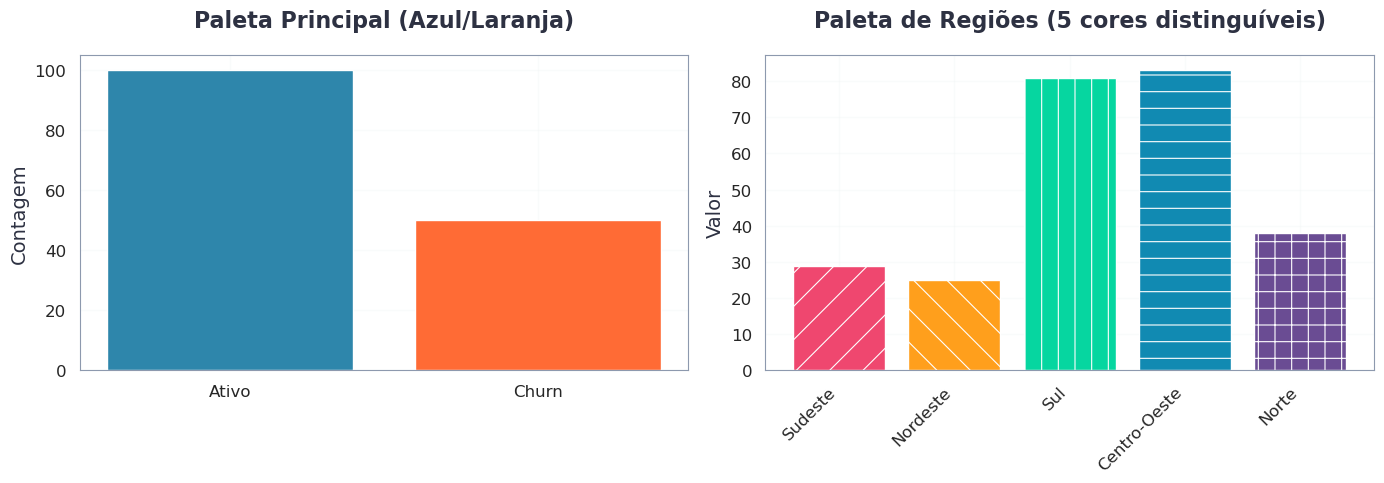

In [4]:
# -----------------------------------------
# 1. PALETA DE CORES
# -----------------------------------------

# PALETA PRINCIPAL 
PALETA_CHURN = {
    # --- Cores para variável target (churn) ---
    'ativo': '#2E86AB',       # Azul moderado
    'churn': '#FF6B35',       # Laranja terroso 
    'risco_alto': '#D1495B',  # Vermelho-rosado 
    'risco_medio': '#FF9F1C', # Laranja amarelado
    'risco_baixo': '#4A90E2', # Azul diferente do ativo
    
    # --- Cores para segmentação ---
    'novo_cliente': '#00A8B5',  # Turquesa/ciano
    'cliente_fiel': '#6A4C93',  # Roxo/índigo
    
    # --- Cores neutras ---
    'neutro_escuro': '#2D3142',   # Azul escuro quase preto
    'neutro_medio': '#8D99AE',    # Cinza azulado
    'neutro_claro': '#EDF2F4',    # Cinza muito claro
    'fundo_branco': '#FFFFFF',
}

# PALETA PARA CATEGORIAS 
PALETA_CATEGORIAS = {
    'genero': {
        'Feminino': '#EF476F',    # Rosa avermelhado
        'Masculino': '#118AB2',   # Azul
        'Outros': '#6A4C93',      # Roxo
        'Não informado': '#8D99AE' # Cinza
    },
    
    'plano_assinatura': {
        'Básico': '#8D99AE',      # Cinza
        'Padrão': '#118AB2',      # Azul
        'Premium': '#6A4C93',     # Roxo
    },
    
    'regiao': {
        'Sudeste': '#EF476F',     # Rosa
        'Nordeste': '#FF9F1C',    # Laranja
        'Sul': '#06D6A0',         # Verde azulado 
        'Centro-Oeste': '#118AB2', # Azul
        'Norte': '#6A4C93',       # Roxo
    },
    
    'tipo_contrato': {
        'Mensal': '#EF476F',      # Rosa/vermelho
        'Anual': '#06D6A0',       # Verde azulado 
    },
    
    'categoria_favorita': {
        'Séries': '#118AB2',      # Azul
        'Filmes': '#6A4C93',      # Roxo
        'Esportes': '#06D6A0',    # Verde azulado
        'Documentários': '#FF9F1C', # Laranja
        'Variedades': '#EF476F',  # Rosa
    },
    
    'dispositivo_principal': {
        'TV': '#EF476F',          # Rosa
        'Mobile': '#118AB2',      # Azul
        'Desktop': '#06D6A0',     # Verde azulado
        'Tablet': '#FF9F1C',      # Laranja
        'tv': '#EF476F',          
        'mobile': '#118AB2',
        'desktop': '#06D6A0',
    }
}

# GRADIENTES SEGUROS
GRADIENTES_ACESSIVEIS = {
    'engajamento': 'viridis',
    'risco': 'plasma',
    'satisfacao': 'summer',  # Amarelo-verde
    'valor': 'cool',
}

# -----------------------------------------
# 2. CONFIGURAÇÕES DE ESTILO E TAMANHOS
# -----------------------------------------

TAMANHOS_GRAFICOS = {
    'univariada': (10, 4),
    'bivariada': (12, 6),
    'multivariada': (14, 7),
    'churn_barras': (10, 6),
    'churn_evolucao': (14, 5),
    'churn_correlacao': (12, 10),
    'churn_heatmap': (10, 8),
    'dashboard': (16, 8),
    'slide': (12, 6),
}

CONFIG_TECNICA = {
    'dpi_tela': 100,
    'dpi_exportacao': 300,
    'transparencia': 0.85,
    'linha_espessura': 1.5,
}

# -----------------------------------------
# 3. FUNÇÃO DE CONFIGURAÇÃO GLOBAL
# -----------------------------------------

def configurar_estilo_global():
    """
    Aplica configurações visuais globais 
    """
    # 1. Usar estilo com bom contraste
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_style("whitegrid")
    
    # 2. Contexto para legibilidade
    sns.set_context("notebook", font_scale=1.1)
    
    # 3. PALETA PADRÃO 
    sns.set_palette([PALETA_CHURN['ativo'], PALETA_CHURN['churn']])
    
    # 4. Configurar matplotlib
    rcParams.update({
        # FONTES
        'font.family': 'DejaVu Sans',
        'font.size': 12,
        'axes.labelsize': 14,
        'axes.titlesize': 16,
        'axes.titleweight': 'bold',
        'axes.titlepad': 20,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12,
        
        # CORES E CONTRASTE
        'axes.edgecolor': PALETA_CHURN['neutro_medio'],
        'axes.labelcolor': PALETA_CHURN['neutro_escuro'],
        'axes.linewidth': 0.8,
        'grid.color': PALETA_CHURN['neutro_claro'],
        'grid.alpha': 0.3,
        'text.color': PALETA_CHURN['neutro_escuro'],
        
        # FIGURAS
        'figure.figsize': TAMANHOS_GRAFICOS['bivariada'],
        'figure.dpi': CONFIG_TECNICA['dpi_tela'],
        'figure.facecolor': PALETA_CHURN['fundo_branco'],
        'savefig.dpi': CONFIG_TECNICA['dpi_exportacao'],
        'savefig.bbox': 'tight',
        
        # LINHAS
        'lines.linewidth': CONFIG_TECNICA['linha_espessura'],
        
        # HATCHES para diferenciar sem depender apenas de cor
        'hatch.linewidth': 0.8,
    })
    
# -----------------------------------------
# 5. FUNÇÕES UTILITÁRIAS ACESSÍVEIS
# -----------------------------------------

def criar_figura(tipo_grafico='bivariada', **kwargs):
    """Cria figura com tamanho pré-definido."""
    figsize = TAMANHOS_GRAFICOS.get(tipo_grafico, TAMANHOS_GRAFICOS['bivariada'])
    fig, ax = plt.subplots(figsize=figsize, **kwargs)
    fig.patch.set_facecolor(PALETA_CHURN['fundo_branco'])
    ax.set_facecolor(PALETA_CHURN['fundo_branco'])
    return fig, ax

def aplicar_paleta_segura(ax, coluna, dados, usar_hatch=False):
    """
    Aplica paleta acessível e opcionalmente hatches para diferenciar.
    
    Parâmetros:
    -----------
    usar_hatch : bool
        Se True, adiciona padrões às barras (útil para impressão P&B)
    """
    if coluna in PALETA_CATEGORIAS:
        categorias = dados.unique()
        cores = []
        
        for categoria in categorias:
            # Padronizar categoria (tratar 'tv' e 'TV' como iguais)
            cat_key = categoria
            if isinstance(categoria, str):
                cat_key = categoria.capitalize() if categoria in ['tv', 'mobile', 'desktop'] else categoria
            
            if cat_key in PALETA_CATEGORIAS[coluna]:
                cores.append(PALETA_CATEGORIAS[coluna][cat_key])
            else:
                cores.append(PALETA_CHURN['neutro_medio'])
        
        # Aplicar cores
        for i, (patch, cor) in enumerate(zip(ax.patches, cores * (len(ax.patches) // len(cores)))):
            patch.set_color(cor)
            patch.set_edgecolor(PALETA_CHURN['neutro_medio'])
            
            # Adicionar hatch se solicitado (para diferenciação extra)
            if usar_hatch:
                hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']
                patch.set_hatch(hatches[i % len(hatches)])
    
    return ax

def criar_grafico_acessivel(tipo, dados, variavel_categoria=None, **kwargs):
    """
    Função de alto nível para criar gráficos acessíveis.
    
    Tipos suportados: 'barra', 'boxplot', 'dispersao', 'histograma'
    """
    fig, ax = criar_figura(tipo_grafico='bivariada')
    
    if tipo == 'barra' and variavel_categoria:
        # Gráfico de barras com paleta segura
        contagem = dados[variavel_categoria].value_counts()
        ax.bar(contagem.index, contagem.values)
        aplicar_paleta_segura(ax, variavel_categoria, contagem.index)
        
    elif tipo == 'boxplot' and 'x' in kwargs and 'y' in kwargs:
        # Boxplot com cores acessíveis
        sns.boxplot(
            x=kwargs['x'],
            y=kwargs['y'],
            data=dados,
            ax=ax,
            palette=[PALETA_CHURN['ativo'], PALETA_CHURN['churn']]
        )
    
    return fig, ax

def testar_configuracoes():
    """
    Verifica visualmente se a paleta é acessível.
    Cria um gráfico de teste.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Teste 1: Paleta principal (churn vs ativo)
    cores_churn = [PALETA_CHURN['ativo'], PALETA_CHURN['churn']]
    axes[0].bar(['Ativo', 'Churn'], [100, 50], color=cores_churn)
    axes[0].set_title('Paleta Principal (Azul/Laranja)')
    axes[0].set_ylabel('Contagem') 
 
    # Teste 2: Paleta de regiões
    regioes = list(PALETA_CATEGORIAS['regiao'].keys())
    valores = np.random.randint(20, 100, size=len(regioes))
    cores_regioes = [PALETA_CATEGORIAS['regiao'][r] for r in regioes]
    
    bars = axes[1].bar(regioes, valores, color=cores_regioes)
    axes[1].set_title('Paleta de Regiões (5 cores distinguíveis)')
    axes[1].set_ylabel('Valor')
    plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Adicionar hatches para diferenciação extra
    for i, bar in enumerate(bars):
        bar.set_hatch(['/', '\\', '|', '-', '+'][i % 5])
    
    plt.tight_layout()


# -----------------------------------------
# 6. EXECUTAR CONFIGURAÇÃO
# -----------------------------------------

# Executar configuração global
configurar_estilo_global()

# Testar configurações
testar_configuracoes()

print("\n" + "="*60)
print("PARAMETROS GLOBAIS DE VISUALISAÇÃO CONFIGURADOS")
print("="*60)
print("\nPRINCÍPIOS APLICADOS:")
print("1. 🔵 AZUL vs 🟠 LARANJA (nunca vermelho vs verde)")
print("2. Contraste mínimo 4.5:1 para texto/fundo")
print("3. Múltiplos diferenciadores: cor, padrão, posição")
print("4. Cores com acessibilidade \n")
print("TESTE:")

##

###### =============================================================
### `CARREGANDO O DATASET E OVERVIEW INICIAL`
###### =============================================================

In [4]:
# ---------------------------------------------------------------------------------------------
# 1. CARREGANDO O DATASET COM O NOME DADOS_STREAMING E REALIZANDO UMA COPIA DF PARA EXPLORAÇÃO 
# ---------------------------------------------------------------------------------------------
dados_streaming = pd.read_csv('https://raw.githubusercontent.com/rafaelreisramos/oracle-one-g8-hackathon/refs/heads/main/data/dados_streamingV4.csv')
df = dados_streaming.copy()

In [5]:
# -----------------------
# 2. PRIMEIRAS 5 LINHAS
# -----------------------
df.head()

,cliente_id,idade,genero,regiao,tipo_contrato,metodo_pagamento,plano_assinatura,valor_mensal,tempo_assinatura_meses,dias_ultimo_acesso,acessibilidade,contatos_suporte,visualizacoes_mes,tempo_medio_sessao_min,dispositivo_principal,categoria_favorita,avaliacao_conteudo_media,avaliacao_conteudo_ultimo_mes,avaliacao_plataforma,churn
0,CLI_000001,44,Feminino,Sudeste,Mensal,Pix,Padrão,38.0,42,27,0,2,15,169,Mobile,Séries,"5,0","3,0","2,0",0
1,CLI_000002,36,Feminino,Sudeste,Mensal,Crédito Recorrente,Premium,49.9,20,23,0,1,15,97,Mobile,Filmes,"2,0",NaN,"3,0",0
2,CLI_000003,46,Feminino,Sudeste,Mensal,Cartão de Crédito,Básico,24.9,6,14,0,2,56,118,Desktop,Séries,"1,5",NaN,NaN,0
3,CLI_000004,57,Masculino,Nordeste,Mensal,Crédito Recorrente,Básico,24.9,10,70,0,0,0,31,TV,Séries,"4,0",NaN,NaN,1
4,CLI_000005,34,Outros,Nordeste,Mensal,Crédito Recorrente,Premium,49.9,22,31,0,1,0,46,mobile,Esportes,"4,0",NaN,"1,5",0


In [6]:
# --------------------
# 2. ULTIMAS 5 LINHAS
# --------------------
df.tail()

,cliente_id,idade,genero,regiao,tipo_contrato,metodo_pagamento,plano_assinatura,valor_mensal,tempo_assinatura_meses,dias_ultimo_acesso,acessibilidade,contatos_suporte,visualizacoes_mes,tempo_medio_sessao_min,dispositivo_principal,categoria_favorita,avaliacao_conteudo_media,avaliacao_conteudo_ultimo_mes,avaliacao_plataforma,churn
29995,CLI_029996,30,Feminino,Nordeste,Anual,Crédito Recorrente,Padrão,32.0,0,1,0,2,87,121,Desktop,Filmes,NaN,"3,5","2,0",0
29996,CLI_029997,56,Feminino,Nordeste,Mensal,Crédito Recorrente,Básico,24.9,0,0,0,1,71,76,tv,Séries,NaN,"3,5",NaN,0
29997,CLI_029998,31,Feminino,Nordeste,Anual,Crédito Recorrente,Premium,38.0,0,1,0,5,80,29,Tablet,Infantil,NaN,"3,5","4,5",0
29998,CLI_029999,18,Masculino,Sudeste,Anual,Crédito Recorrente,Premium,38.0,9,29,0,3,11,135,mobile,Séries,"4,0","4,0","4,5",0
29999,CLI_030000,35,Feminino,Sul,Anual,Crédito Recorrente,Premium,38.0,24,24,0,0,6,88,Mobile,Documentários,NaN,NaN,"3,0",0


In [8]:
# --------------------------
# 3. AMOSTRAS DOS REGISTROS
# --------------------------
amostra = pd.concat([df.iloc[i*len(df)//4:(i+1)*len(df)//4].sample(10, random_state=42) 
                     for i in range(4)])
amostra

,cliente_id,idade,genero,regiao,tipo_contrato,metodo_pagamento,plano_assinatura,valor_mensal,tempo_assinatura_meses,dias_ultimo_acesso,acessibilidade,contatos_suporte,visualizacoes_mes,tempo_medio_sessao_min,dispositivo_principal,categoria_favorita,avaliacao_conteudo_media,avaliacao_conteudo_ultimo_mes,avaliacao_plataforma,churn
970,CLI_000971,39,NaN,Sudeste,Mensal,Cartão de Crédito,Básico,24.9,0,0,0,2,31,96,Mobile,Documentários,NaN,"3,0","5,0",0
6279,CLI_006280,38,Feminino,Sudeste,Mensal,Cartão de Crédito,Básico,24.9,48,16,0,0,86,69,mobile,Esportes,NaN,"5,0","1,0",0
1859,CLI_001860,41,NaN,Sudeste,Mensal,Crédito Recorrente,Básico,24.9,7,25,0,3,9,134,TV,Documentários,NaN,"4,0","3,0",0
6803,CLI_006804,59,Feminino,Sudeste,Mensal,Cartão de Crédito,Premium,49.9,13,34,0,2,0,48,tv,Filmes,NaN,NaN,NaN,1
6305,CLI_006306,50,Masculino,Sul,Mensal,Pix,Básico,24.9,15,20,0,0,65,95,Desktop,Filmes,"1,5","4,5","2,0",0
3039,CLI_003040,35,Masculino,Sudeste,Mensal,Crédito Recorrente,Padrão,38.0,12,58,0,2,0,43,Mobile,Infantil,"4,0",NaN,"2,5",1
7194,CLI_007195,47,Feminino,Sul,Mensal,Crédito Recorrente,Premium,49.9,14,16,0,2,69,120,Mobile,Infantil,"4,5",NaN,"2,5",0
1446,CLI_001447,31,Masculino,Centro-Oeste,Mensal,Crédito Recorrente,Básico,24.9,26,68,0,2,0,20,mobile,Filmes,"2,0",NaN,"1,5",1
5199,CLI_005200,50,Masculino,Sudeste,Mensal,Crédito Recorrente,Padrão,38.0,29,24,0,0,10,132,tv,Séries,"3,5","3,0","2,5",0
6234,CLI_006235,35,Feminino,Nordeste,Mensal,Cartão de Crédito,Básico,24.9,3,46,0,1,0,28,Tablet,Documentários,NaN,NaN,"1,5",0


In [9]:
# ------------------------
# 5. Dimensões do dataset
# ------------------------
print(f'Linhas: {df.shape[0]}')
print(f'Colunas: {df.shape[1]}')

Linhas: 30000
Colunas: 20


In [10]:
# ------------------------------------
# 4. Verificação de duplicidade no ID
# ------------------------------------
print(f'Total de clientes: {df['cliente_id'].size}')
print(f'CLientes duplicados: {df['cliente_id'].duplicated().sum()}')
print(f'Clientes Unicos: {df['cliente_id'].nunique()}')

Total de clientes: 30000
CLientes duplicados: 0
Clientes Unicos: 30000


In [11]:
# --------------------------
# 5. Informações do dataset
# --------------------------
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   cliente_id                     30000 non-null  object 
 1   idade                          30000 non-null  int64  
 2   genero                         27000 non-null  object 
 3   regiao                         30000 non-null  object 
 4   tipo_contrato                  30000 non-null  object 
 5   metodo_pagamento               30000 non-null  object 
 6   plano_assinatura               30000 non-null  object 
 7   valor_mensal                   30000 non-null  float64
 8   tempo_assinatura_meses         30000 non-null  int64  
 9   dias_ultimo_acesso             30000 non-null  int64  
 10  acessibilidade                 30000 non-null  int64  
 11  contatos_suporte               30000 non-null  int64  
 12  visualizacoes_mes              30000 non-null 

In [12]:
# -----------------------------------------
# 6. Resumo estatístico (somente numéricas)
# -----------------------------------------
df.describe()

,idade,valor_mensal,tempo_assinatura_meses,dias_ultimo_acesso,acessibilidade,contatos_suporte,visualizacoes_mes,tempo_medio_sessao_min,churn
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.0000,30000.000000,30000.000000,30000.000000
mean,37.870033,32.248543,13.058233,24.850167,0.051567,1.1996,27.978700,73.533933,0.249067
std,12.240975,7.818732,12.388886,17.957359,0.221154,1.0973,31.946358,44.548880,0.432480
min,18.000000,22.000000,0.000000,0.000000,0.000000,0.0000,0.000000,5.000000,0.000000
25%,29.000000,24.900000,3.000000,12.000000,0.000000,0.0000,0.000000,35.000000,0.000000
50%,38.000000,32.000000,9.000000,22.000000,0.000000,1.0000,13.000000,73.000000,0.000000
75%,46.000000,38.000000,19.000000,34.000000,0.000000,2.0000,54.000000,106.000000,0.000000
max,85.000000,49.900000,48.000000,112.000000,1.000000,7.0000,159.000000,249.000000,1.000000


In [13]:
# ---------------------------------------------------
# 7. Resumo estatístico para variáveis categóricas
# ---------------------------------------------------
df.describe(include = 'object')

,cliente_id,genero,regiao,tipo_contrato,metodo_pagamento,plano_assinatura,dispositivo_principal,categoria_favorita,avaliacao_conteudo_media,avaliacao_conteudo_ultimo_mes,avaliacao_plataforma
count,30000,27000,30000,30000,30000,30000,30000,30000,18223,12403,23959
unique,30000,4,5,2,6,3,6,6,9,9,9
top,CLI_000001,Feminino,Sudeste,Mensal,Crédito Recorrente,Básico,Tablet,Séries,"4,0","5,0","3,5"
freq,1,12169,13475,21574,15872,13771,5054,9030,7997,2161,2728


##

###### ============================================
### `ANALISE DE QUALIDADE DOS DADOS`
###### ============================================

In [14]:
# -----------------------------------
# 1. Verificação de valores ausentes
# -----------------------------------
df.isnull().sum().sort_values(ascending = False)

avaliacao_conteudo_ultimo_mes    17597
avaliacao_conteudo_media         11777
avaliacao_plataforma              6041
genero                            3000
cliente_id                           0
contatos_suporte                     0
categoria_favorita                   0
dispositivo_principal                0
tempo_medio_sessao_min               0
visualizacoes_mes                    0
acessibilidade                       0
idade                                0
dias_ultimo_acesso                   0
tempo_assinatura_meses               0
valor_mensal                         0
plano_assinatura                     0
metodo_pagamento                     0
tipo_contrato                        0
regiao                               0
churn                                0
dtype: int64

In [15]:
# --------------------------------------------------------
# 2. VERIFICANDO SE HA COLUNAS COM VALORES NAO PREENCHIDOS
# --------------------------------------------------------
print('COLUNAS COM VALORES VAZIOS')
for coluna in list(df.columns):
    if df[coluna].dtype == object:
        if df[coluna].str.strip().eq('').sum() > 0:
            print(f'{coluna} : {df[coluna].str.strip().eq("").sum()}')

COLUNAS COM VALORES VAZIOS


In [16]:
# ----------------------------------------
# 3. VERIFICANDO QUANTIDADE VALORES NULOS
# ----------------------------------------
df.isnull().sum().sort_values(ascending = False)

avaliacao_conteudo_ultimo_mes    17597
avaliacao_conteudo_media         11777
avaliacao_plataforma              6041
genero                            3000
cliente_id                           0
contatos_suporte                     0
categoria_favorita                   0
dispositivo_principal                0
tempo_medio_sessao_min               0
visualizacoes_mes                    0
acessibilidade                       0
idade                                0
dias_ultimo_acesso                   0
tempo_assinatura_meses               0
valor_mensal                         0
plano_assinatura                     0
metodo_pagamento                     0
tipo_contrato                        0
regiao                               0
churn                                0
dtype: int64

In [17]:
# ------------------------------------------------------------------
# 4. VERIFICANDO A PROPORÇÃO DE CHURN EM MISSING E VALORES AUSENTES
# ------------------------------------------------------------------
def analise_missing_com_churn(df, variaveis_avaliacao):
    """
    Analisa se missing values estão associados com churn
    """
    
    for var in variaveis_avaliacao:        
        df[f'{var}_missing'] = df[var].isna().astype(int)        
        
        churn_missing = df.groupby(f'{var}_missing')['churn'].agg(['mean', 'count'])
        
        print(f"\n{var}:")
        print("Churn rate quando valor presente:", f"{churn_missing.loc[0, 'mean']*100:.1f}%")
        print("Churn rate quando missing:", f"{churn_missing.loc[1, 'mean']*100:.1f}%")
        print("Diferença:", f"{(churn_missing.loc[1, 'mean'] - churn_missing.loc[0, 'mean'])*100:.1f}%")
        print("Total missing:", churn_missing.loc[1, 'count'])

var_miss = ['avaliacao_conteudo_ultimo_mes', 'avaliacao_conteudo_media',
                   'avaliacao_plataforma', 'genero']
analise_missing_com_churn(df, var_miss)


avaliacao_conteudo_ultimo_mes:
Churn rate quando valor presente: 14.7%
Churn rate quando missing: 32.1%
Diferença: 17.4%
Total missing: 17597

avaliacao_conteudo_media:
Churn rate quando valor presente: 27.0%
Churn rate quando missing: 21.7%
Diferença: -5.2%
Total missing: 11777

avaliacao_plataforma:
Churn rate quando valor presente: 24.9%
Churn rate quando missing: 24.8%
Diferença: -0.2%
Total missing: 6041

genero:
Churn rate quando valor presente: 24.8%
Churn rate quando missing: 25.7%
Diferença: 0.8%
Total missing: 3000


--------------------------
### `MÉTODO QUE IRA SER ADOTADO NO TRATAMENTO DOS VALORES MISSING:`

Considerando o problema de negócio, o dicionario de dados e a exploração dos dados. Optou-se por preencher todos os valore missing pelas seguintes justificativas e da seguinte forma:

#### **Variável `genero`**:  
Emmbora ela possa ser tratando no tipo MNAR por envolver perguntas pessoais, ela sera tratada como MAR(Missing at random; Missing aleatório). Pois se trata de uma variavel optativa, ou seja o cliente preenche se quer ou não e em principio não ha nenhum motivo para que ele preencha.
 - `Valor adotado:` 'Nao_preenchido'

#### **Variáveis `avaliacao_conteudo_ultimo_mes`; `avaliacao_conteudo_media`; `avaliacao_plataforma`**: 
Todas as variaveis foram tratadas como tipo MNAR(Not missing at random; Missing não aleatório), pois foi adotado as seguintes `hipoteses:`

1. Efeito do descontentamento extremo:
   - "Não vou perder tempo respondendo"
   - Resultado: Missing super-representa notas baixas

2. Efeito da satisfação extrema:
    - "Já estou tão satisfeito que não preciso reclamar/elogiar"
    - Resultado: Missing super-representa notas altas

3. Efeito da indiferença:
    - "Tanto faz, não respondo"
    - Resultado: Missing super-representa notas médias

- `Valor adotado:` 'Nao_preenchido'
--------------------------------

In [18]:
# ---------------------------------
# 5. SUBSTITUINDO VALORES MISSING
# ---------------------------------
df[['avaliacao_conteudo_ultimo_mes','avaliacao_conteudo_media','avaliacao_plataforma']] = df[['avaliacao_conteudo_ultimo_mes',
                                                                                              'avaliacao_conteudo_media',
                                                                                              'avaliacao_plataforma']].fillna('Nao_avaliado')
df['genero'] = df['genero'].fillna('Nao_preenchido')

In [19]:
# ---------------------------------------------------
# 6. VERIFICAÇÃO DE VALORES MISSING APOS PREENCIMENTO
# ---------------------------------------------------
df.isnull().sum().sort_values(ascending = False)

cliente_id                               0
idade                                    0
avaliacao_plataforma_missing             0
avaliacao_conteudo_media_missing         0
avaliacao_conteudo_ultimo_mes_missing    0
churn                                    0
avaliacao_plataforma                     0
avaliacao_conteudo_ultimo_mes            0
avaliacao_conteudo_media                 0
categoria_favorita                       0
dispositivo_principal                    0
tempo_medio_sessao_min                   0
visualizacoes_mes                        0
contatos_suporte                         0
acessibilidade                           0
dias_ultimo_acesso                       0
tempo_assinatura_meses                   0
valor_mensal                             0
plano_assinatura                         0
metodo_pagamento                         0
tipo_contrato                            0
regiao                                   0
genero                                   0
genero_miss

In [20]:
# ----------------------------------------------
# 6. VERIFICANDO INCONCISTENCIA E VALORES UNICOS
# ----------------------------------------------
grupo = ('regiao', 'tipo_contrato', 'plano_assinatura', 'acessibilidade', 'metodo_pagamento',
        'dispositivo_principal', 'categoria_favorita', 'genero', 'avaliacao_plataforma', 'avaliacao_conteudo_media',
         'avaliacao_conteudo_ultimo_mes'  )
for i in grupo:
    print(f'{df.groupby(i).size().sort_values(ascending=False)}')
    print(15 * '_')
    print('\n')

regiao
Sudeste         13475
Sul              6033
Nordeste         6026
Centro-Oeste     3000
Norte            1466
dtype: int64
_______________


tipo_contrato
Mensal    21574
Anual      8426
dtype: int64
_______________


plano_assinatura
Básico     13771
Padrão      9027
Premium     7202
dtype: int64
_______________


acessibilidade
0    28453
1     1547
dtype: int64
_______________


metodo_pagamento
Crédito Recorrente    15872
Cartão de Crédito      5413
Débito                 3342
Pix                    2570
Débito Automático      1715
Boleto                 1088
dtype: int64
_______________


dispositivo_principal
Tablet     5054
Mobile     5025
mobile     4999
tv         4993
Desktop    4980
TV         4949
dtype: int64
_______________


categoria_favorita
Séries           9030
Filmes           7464
Documentários    4552
Esportes         4442
Infantil         3032
Novelas          1480
dtype: int64
_______________


genero
Feminino          12169
Masculino         12148
Nao_pr

In [21]:
# --------------------------------------------------------------
# 7. TRATANDO INCONCISTENCIA DA VARIAVEL 'dispositivo_principal'
# -----------------------------------------------------------
print(10*'-', 'ANTES', 10*'-')
print(df.groupby('dispositivo_principal')['cliente_id'].count())

df['dispositivo_principal'] = df['dispositivo_principal'].str.title().str.strip()

print('\n\n',10*'-', 'DEPOIS', 10*'-')
print(df.groupby('dispositivo_principal')['cliente_id'].count())

---------- ANTES ----------
dispositivo_principal
Desktop    4980
Mobile     5025
TV         4949
Tablet     5054
mobile     4999
tv         4993
Name: cliente_id, dtype: int64


 ---------- DEPOIS ----------
dispositivo_principal
Desktop     4980
Mobile     10024
Tablet      5054
Tv          9942
Name: cliente_id, dtype: int64


##

###### ==============================================
### `ANÁLISE A VARIÁVEL TARGET (CHURN)`
###### ==============================================

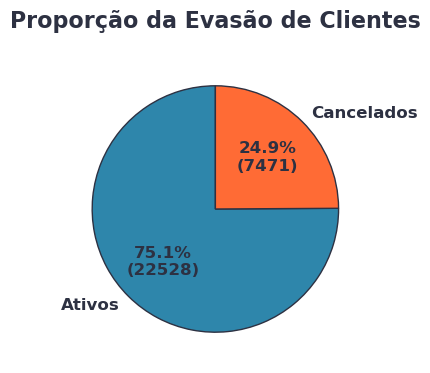

In [22]:
# ---------------------------------------------------
# 1. Grafico distribuição da variável target (Churn)
# ---------------------------------------------------
cores_pizza = [PALETA_CHURN['ativo'], PALETA_CHURN['churn']]

fig, ax = criar_figura(tipo_grafico='univariada') 

contagem_churn = df['churn'].value_counts()
labels_churn = contagem_churn.index.map({0: 'Ativos', 1: 'Cancelados'})

ax.pie(
    contagem_churn,
    labels=labels_churn,
    autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100*sum(contagem_churn))})',
    textprops = {'fontweight': 'bold'},
    startangle=90,
    colors=cores_pizza,
    wedgeprops={'edgecolor': PALETA_CHURN['neutro_escuro'], 'linewidth': 1}
)

ax.set_title(
    'Proporção da Evasão de Clientes',
    fontsize=16,
    fontweight='bold',
    color=PALETA_CHURN['neutro_escuro'],
    pad=20
)

fig.savefig('Grafico proporção de churn', dpi=300)
plt.show()

In [23]:
# ----------------------------------------------------
# 2 Relação entre churn e várias variáveis categóricas
# ----------------------------------------------------
for col in df.select_dtypes(include=['object', 'category']).columns:
    if col != 'churn' and col != 'cliente_id':
        print(f"\nChurn x {col}:")
        print(pd.crosstab(df['churn'], df[col], normalize='index').round(3))


Churn x genero:
genero  Feminino  Masculino  Nao_preenchido  Não Informar  Outros
churn                                                            
0          0.405      0.406           0.099         0.072   0.018
1          0.409      0.400           0.103         0.072   0.016

Churn x regiao:
regiao  Centro-Oeste  Nordeste  Norte  Sudeste    Sul
churn                                                
0                0.1     0.200  0.050    0.449  0.201
1                0.1     0.205  0.045    0.448  0.202

Churn x tipo_contrato:
tipo_contrato  Anual  Mensal
churn                       
0              0.325   0.675
1              0.148   0.852

Churn x metodo_pagamento:
metodo_pagamento  Boleto  Cartão de Crédito  Crédito Recorrente  Débito  \
churn                                                                     
0                  0.026              0.163               0.578   0.104   
1                  0.069              0.232               0.382   0.134   

metodo_pagamento  

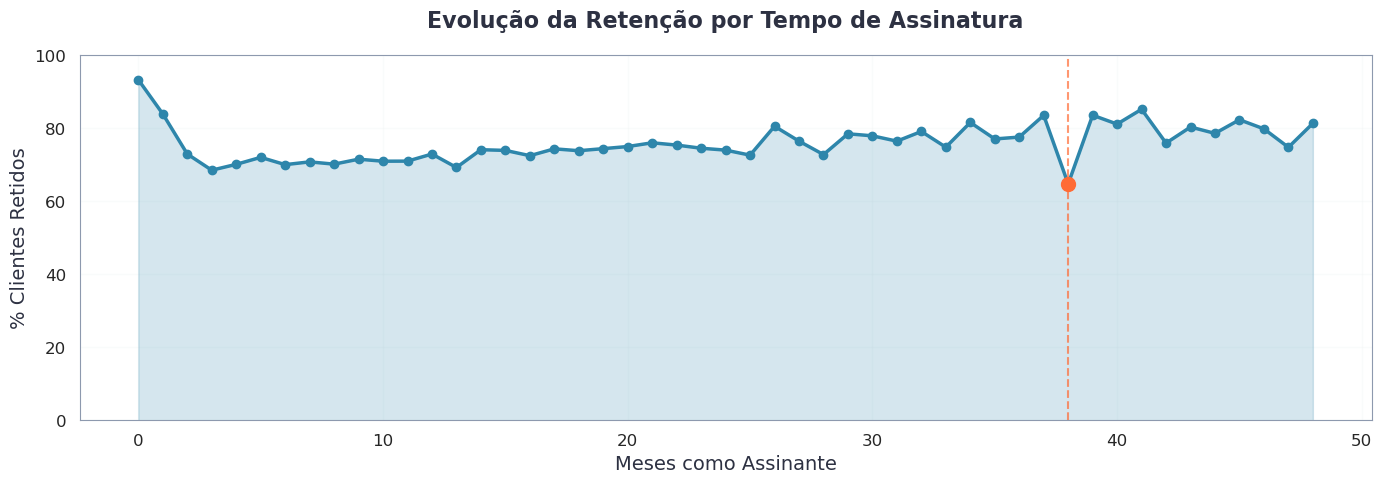

💡 Ponto crítico: 38 meses
📉 Retenção mínima: 64.7%
📈 Retenção máxima: 93.2%


In [24]:
# -----------------
# 3 GRAFICO CORHORT
# -----------------
fig, ax = criar_figura('churn_evolucao')
retencao_por_mes = df.groupby('tempo_assinatura_meses')['churn'].apply(lambda x: (1-x.mean())*100)

# Linha principal
ax.plot(retencao_por_mes.index, retencao_por_mes.values, 
        color=PALETA_CHURN['ativo'], linewidth=2.5, marker='o')

# Destacar ponto crítico
ponto_critico = retencao_por_mes.idxmin()
ax.axvline(ponto_critico, color=PALETA_CHURN['churn'], linestyle='--', alpha=0.7)
ax.scatter(ponto_critico, retencao_por_mes.min(), 
           color=PALETA_CHURN['churn'], s=100, zorder=5)

# Área sob a curva
ax.fill_between(retencao_por_mes.index, retencao_por_mes.values, 
                alpha=0.2, color=PALETA_CHURN['ativo'])

# Configurações finais
ax.set_title('Evolução da Retenção por Tempo de Assinatura', pad=20)
ax.set_xlabel('Meses como Assinante')
ax.set_ylabel('% Clientes Retidos')
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 100)

plt.tight_layout()
fig.savefig('Grafico corhot', dpi=300)
plt.show()

# Informações complementares
print(f"💡 Ponto crítico: {ponto_critico} meses")
print(f"📉 Retenção mínima: {retencao_por_mes.min():.1f}%")
print(f"📈 Retenção máxima: {retencao_por_mes.max():.1f}%")

In [25]:
# ----------------------------------------
# 4 TOTAL DE CHURN NO MES DE ASSINATURA 38
# ----------------------------------------
soma38 = df[df['tempo_assinatura_meses'] == 38]['churn'].sum()
print(f"Soma de churn para 38 meses de assinatura: {soma38}")

Soma de churn para 38 meses de assinatura: 47


## 

###### ============================================
### `ANALISE DEMOGRAFICA DE CADASTRO`
###### ============================================

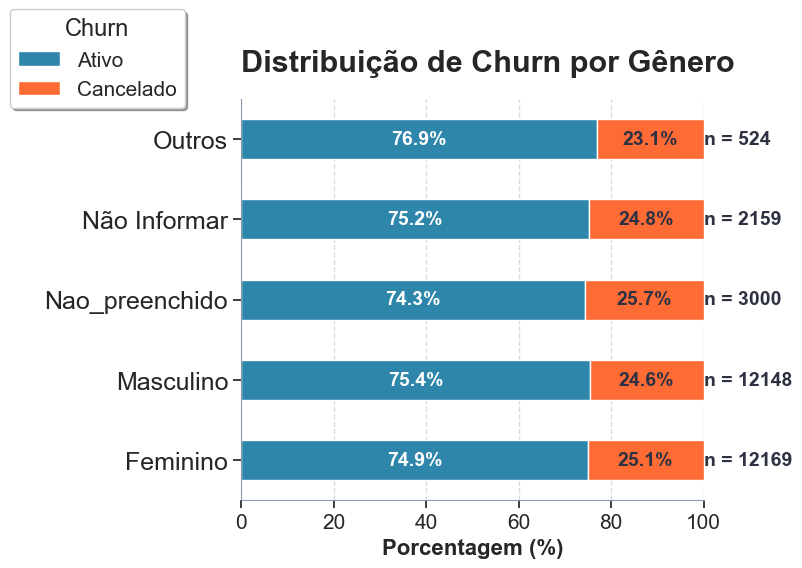

In [26]:
# ----------------------------------
# 1 DISTRIBUIÇÃO DE CHURN POR GENERO
# ----------------------------------
# Configurar estilo e criar figura
sns.set_style("ticks")
fig, ax = criar_figura('churn_barras')

# Calcular dados
cont = df.groupby(['genero', 'churn']).size().unstack()
percent = cont.div(cont.sum(axis=1), axis=0) * 100
total = cont.sum(axis=1)

# Plot com paleta apropriada
percent.plot(kind='barh', stacked=True, 
             color=[PALETA_CHURN['ativo'], PALETA_CHURN['churn']], ax=ax)

# Configurações do gráfico
ax.set_title('Distribuição de Churn por Gênero', fontsize=22, pad=20, loc='left', fontweight='bold')
ax.set_xlabel('Porcentagem (%)', fontsize=16, fontweight='bold')
ax.set_ylabel('')
ax.yaxis.set_tick_params(labelsize=18)
ax.xaxis.set_tick_params(labelsize=15)
ax.grid(axis='x', linestyle='--', alpha=0.7)
ax.set_xlim(0, 100)

# Legenda
leg = ax.legend(title='Churn', labels=['Ativo', 'Cancelado'], 
                bbox_to_anchor=(-0.1, 1.25), loc='upper right',
                frameon=True,
                title_fontsize=17, prop={'size':15}, shadow=True)

# Adicionar contagem total
for i, (idx, row) in enumerate(percent.iterrows()):
    ax.text(100.1, i, f'n = {total[idx]}', va='center', ha='left',
            fontsize=14, fontweight='bold', color=PALETA_CHURN['neutro_escuro'])

# Adicionar porcentagens nas barras
for i, (idx, row) in enumerate(percent.iterrows()):
    acumulado = 0
    for churn, val in row.items():
        if val > 5:  # Só mostra se tiver espaço suficiente
            ax.text(acumulado + val/2, i, f'{val:.1f}%', 
                   ha='center', va='center', 
                   color='white' if val > 30 else PALETA_CHURN['neutro_escuro'],
                   fontweight='bold', fontsize=14)
        acumulado += val

# Remover bordas desnecessárias
ax.spines[['top', 'right']].set_visible(False)
ax.spines['left'].set_color(PALETA_CHURN['neutro_medio'])
ax.spines['bottom'].set_color(PALETA_CHURN['neutro_medio'])

plt.tight_layout(rect=[0, 0, 0.85, 1])
fig.savefig('Grafico Churn por Genero', dpi=300)
plt.show()

RESUMO ESTATÍSTICO: IDADE vs CHURN
Média de idade - Clientes Ativos: 37.8 anos
Média de idade - Clientes Churn:  37.9 anos
Diferença: 0.1 anos

Faixa etária com MAIOR taxa de churn: 56-65 (26.1%)
Faixa etária com MENOR taxa de churn: 66+ (22.1%)

Correlação idade-churn: 0.003

Teste t (idade ativos vs churn):
  Estatística t: -0.523
  Valor-p: 0.601
  Diferença estatisticamente não significativa


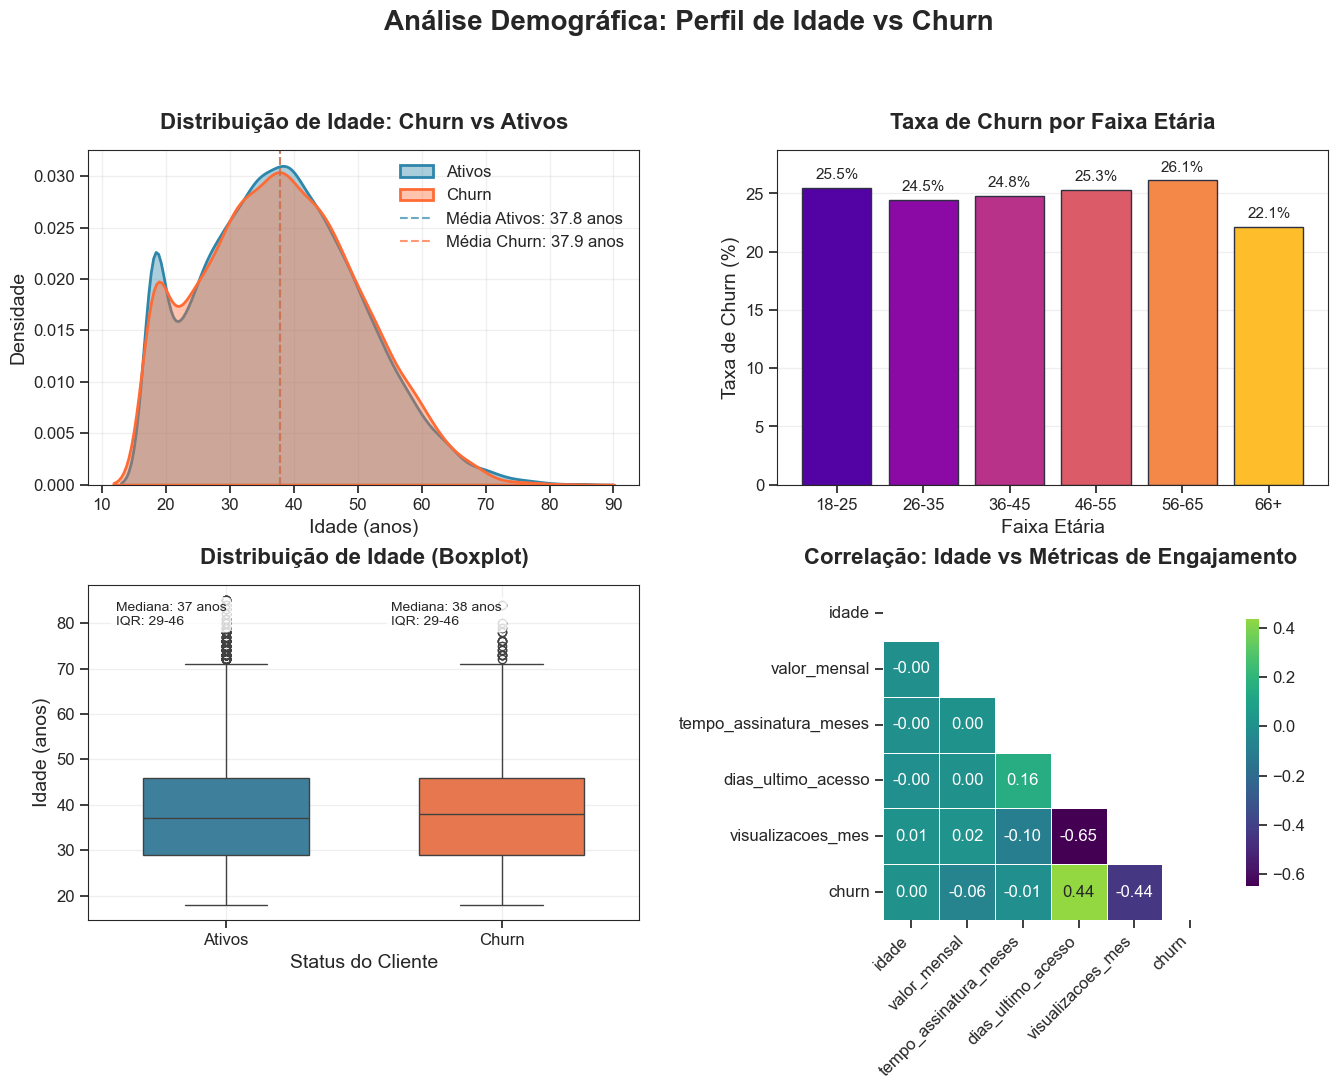

In [27]:
# -------------------------------------------------
# 2 ANÁLISE DE PERFIL DEMOGRÁFICO: IDADE vs CHURN
# -------------------------------------------------

# 1. PREPARAR OS DADOS
# Criar faixas etárias para análise categórica
df['faixa_etaria'] = pd.cut(
    df['idade'],
    bins=[18, 25, 35, 45, 55, 65, 85],
    labels=['18-25', '26-35', '36-45', '46-55', '56-65', '66+']
)

# 2. CALCULAR TAXA DE CHURN POR FAIXA ETÁRIA
churn_por_faixa = df.groupby('faixa_etaria')['churn'].agg(['count', 'sum'])
churn_por_faixa['taxa_churn'] = churn_por_faixa['sum'] / churn_por_faixa['count'] * 100
churn_por_faixa['taxa_retencao'] = 100 - churn_por_faixa['taxa_churn']

# 3. CRIAR FIGURA COM SUBPLOTS
fig = plt.figure(figsize=(16, 10))

# Layout dos subplots
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], hspace=0.3, wspace=0.25)

# Subplot 1: Distribuição de idade por churn (KDE)
ax1 = fig.add_subplot(gs[0, 0])
# Separar idades por status de churn
idades_ativos = df[df['churn'] == 0]['idade']
idades_churn = df[df['churn'] == 1]['idade']

# Plotar KDE
sns.kdeplot(data=idades_ativos, label='Ativos', color=PALETA_CHURN['ativo'], 
            fill=True, alpha=0.4, linewidth=2)
sns.kdeplot(data=idades_churn, label='Churn', color=PALETA_CHURN['churn'], 
            fill=True, alpha=0.4, linewidth=2)

ax1.set_title('Distribuição de Idade: Churn vs Ativos', fontsize=16, fontweight='bold', pad=15)
ax1.set_xlabel('Idade (anos)', fontsize=14)
ax1.set_ylabel('Densidade', fontsize=14)
ax1.legend(title='Status', title_fontsize=12)
ax1.grid(True, alpha=0.3)

# Adicionar linhas verticais para as médias
ax1.axvline(idades_ativos.mean(), color=PALETA_CHURN['ativo'], linestyle='--', 
            alpha=0.7, label=f'Média Ativos: {idades_ativos.mean():.1f} anos')
ax1.axvline(idades_churn.mean(), color=PALETA_CHURN['churn'], linestyle='--', 
            alpha=0.7, label=f'Média Churn: {idades_churn.mean():.1f} anos')
ax1.legend()

# Subplot 2: Taxa de churn por faixa etária (barras)
ax2 = fig.add_subplot(gs[0, 1])
# Definir cores para as barras (gradiente de risco)
cores_faixas = sns.color_palette(GRADIENTES_ACESSIVEIS['risco'], n_colors=len(churn_por_faixa))

bars = ax2.bar(churn_por_faixa.index.astype(str), churn_por_faixa['taxa_churn'], 
               color=cores_faixas, edgecolor=PALETA_CHURN['neutro_escuro'], linewidth=1)

# Adicionar valores nas barras
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.1f}%', ha='center', va='bottom', fontsize=11)

ax2.set_title('Taxa de Churn por Faixa Etária', fontsize=16, fontweight='bold', pad=15)
ax2.set_xlabel('Faixa Etária', fontsize=14)
ax2.set_ylabel('Taxa de Churn (%)', fontsize=14)
ax2.set_ylim(0, churn_por_faixa['taxa_churn'].max() * 1.1)
ax2.grid(True, axis='y', alpha=0.3)

# Subplot 3: Boxplot de idade por churn
ax3 = fig.add_subplot(gs[1, 0])
sns.boxplot(x='churn', y='idade', data=df, ax=ax3, 
            palette=[PALETA_CHURN['ativo'], PALETA_CHURN['churn']],
            width=0.6)

# Substituir labels numéricos por descritivos
ax3.set_xticklabels(['Ativos', 'Churn'])
ax3.set_title('Distribuição de Idade (Boxplot)', fontsize=16, fontweight='bold', pad=15)
ax3.set_xlabel('Status do Cliente', fontsize=14)
ax3.set_ylabel('Idade (anos)', fontsize=14)
ax3.grid(True, alpha=0.3)

# Adicionar anotações com estatísticas
stats_ativos = df[df['churn'] == 0]['idade'].describe()
stats_churn = df[df['churn'] == 1]['idade'].describe()

ax3.text(0.05, 0.95, f'Mediana: {stats_ativos["50%"]:.0f} anos\nIQR: {stats_ativos["25%"]:.0f}-{stats_ativos["75%"]:.0f}',
         transform=ax3.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax3.text(0.55, 0.95, f'Mediana: {stats_churn["50%"]:.0f} anos\nIQR: {stats_churn["25%"]:.0f}-{stats_churn["75%"]:.0f}',
         transform=ax3.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Subplot 4: Heatmap de correlação idade vs métricas relacionadas
ax4 = fig.add_subplot(gs[1, 1])
# Selecionar métricas relacionadas à idade
variaveis_correlacao = ['idade', 'valor_mensal', 'tempo_assinatura_meses', 
                        'dias_ultimo_acesso', 'visualizacoes_mes', 'churn']

corr_matrix = df[variaveis_correlacao].corr()

# Mascarar a diagonal superior
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Criar heatmap
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap=GRADIENTES_ACESSIVEIS['engajamento'],
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=ax4)

ax4.set_title('Correlação: Idade vs Métricas de Engajamento', fontsize=16, fontweight='bold', pad=15)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha='right')
ax4.set_yticklabels(ax4.get_yticklabels(), rotation=0)

# 4. AJUSTES GERAIS E TÍTULO PRINCIPAL
fig.suptitle('Análise Demográfica: Perfil de Idade vs Churn', 
             fontsize=20, fontweight='bold', y=1.02)

plt.tight_layout()

# 5. ANÁLISE NUMÉRICA RESUMO (para referência)
print("=" * 70)
print("RESUMO ESTATÍSTICO: IDADE vs CHURN")
print("=" * 70)
print(f"Média de idade - Clientes Ativos: {idades_ativos.mean():.1f} anos")
print(f"Média de idade - Clientes Churn:  {idades_churn.mean():.1f} anos")
print(f"Diferença: {abs(idades_ativos.mean() - idades_churn.mean()):.1f} anos")
print(f"\nFaixa etária com MAIOR taxa de churn: {churn_por_faixa['taxa_churn'].idxmax()} "
      f"({churn_por_faixa['taxa_churn'].max():.1f}%)")
print(f"Faixa etária com MENOR taxa de churn: {churn_por_faixa['taxa_churn'].idxmin()} "
      f"({churn_por_faixa['taxa_churn'].min():.1f}%)")
print("\nCorrelação idade-churn:", f"{corr_matrix.loc['idade', 'churn']:.3f}")

# Teste estatístico simples (teste t para amostras independentes)
from scipy import stats
t_stat, p_value = stats.ttest_ind(idades_ativos, idades_churn, equal_var=False)
print(f"\nTeste t (idade ativos vs churn):")
print(f"  Estatística t: {t_stat:.3f}")
print(f"  Valor-p: {p_value:.3f}")
print(f"  Diferença estatisticamente {'significativa' if p_value < 0.05 else 'não significativa'}")

print("=" * 70)
fig.savefig('Grafico Churn por Idade', dpi=300)
plt.show()

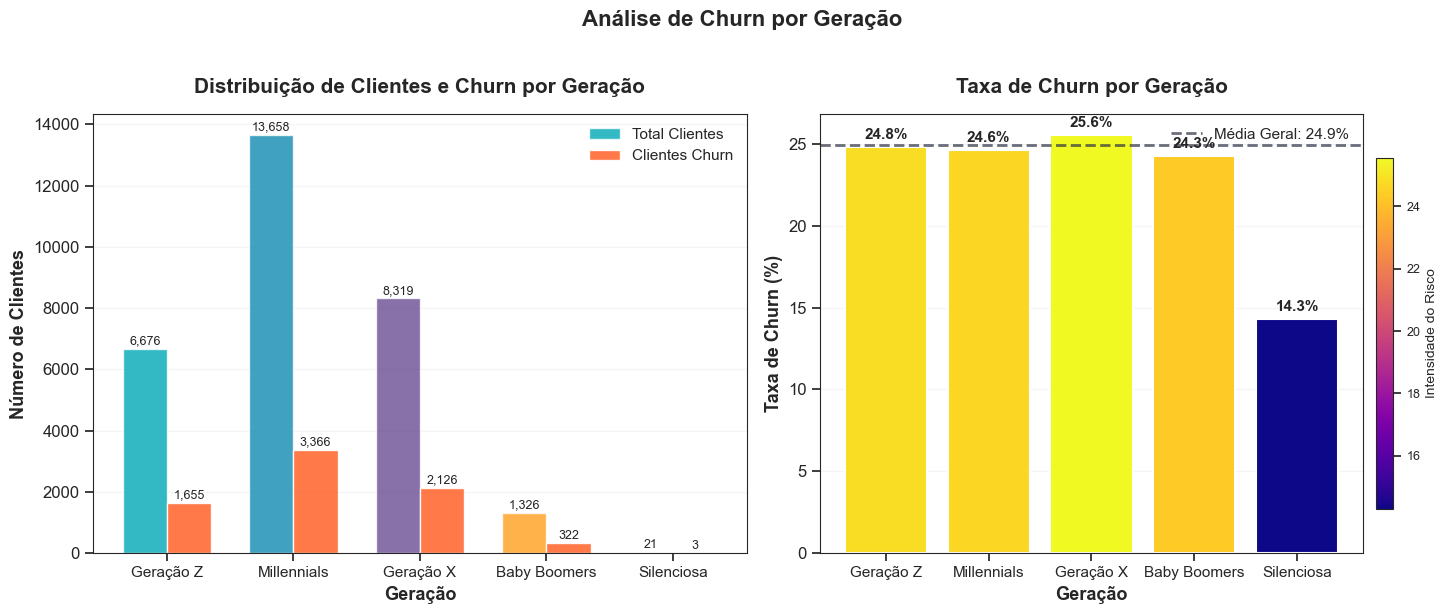


══════════════════════════════════════════════════
RESUMO: TAXA DE CHURN POR GERAÇÃO
══════════════════════════════════════════════════
Geração Z       →  24.8% (-0.1pts)
Millennials     →  24.6% (-0.3pts)
Geração X       →  25.6% (+0.6pts)
Baby Boomers    →  24.3% (-0.6pts)
Silenciosa      →  14.3% (-10.6pts)
══════════════════════════════════════════════════
Média geral: 24.9%
══════════════════════════════════════════════════


In [28]:
# -------------------------------------------
# 3 GRAFICO GERAÇÕES vs CHURN
# ------------------------------------------

# 1. PREPARAR DADOS DE FORMA SIMPLIFICADA
# Classificar gerações (mantendo função anterior)
def classificar_geracao(idade):
    """Classifica a geração com base na idade."""
    if idade >= 79:
        return 'Silenciosa'
    elif idade >= 60:
        return 'Baby Boomers'
    elif idade >= 44:
        return 'Geração X'
    elif idade >= 28:
        return 'Millennials'
    else:
        return 'Geração Z'

df['geracao_simples'] = df['idade'].apply(classificar_geracao)

# Ordem simplificada para labels (do mais jovem para o mais velho)
ordem_simplificada = ['Geração Z', 'Millennials', 'Geração X', 'Baby Boomers', 'Silenciosa']

# Calcular métricas básicas, garantindo a ordem e preenchendo com 0 se não houver dados
distribuicao = df['geracao_simples'].value_counts().reindex(ordem_simplificada, fill_value=0)
churn_data = df.groupby('geracao_simples')['churn'].agg(['count', 'sum']).reindex(ordem_simplificada, fill_value=0)
churn_data['taxa_churn'] = churn_data['sum'] / churn_data['count'] * 100

# 2. PALETA SIMPLIFICADA
cores_simplificadas = {
    'Geração Z': '#00A8B5',     # Turquesa
    'Millennials': '#118AB2',   # Azul
    'Geração X': '#6A4C93',     # Roxo
    'Baby Boomers': '#FF9F1C',  # Laranja
    'Silenciosa': '#EF476F'     # Rosa
}

# 3. CRIAR FIGURA LIMPA
fig = plt.figure(figsize=(15, 6))

# Subplot 1: Distribuição e Churn lado a lado
ax1 = plt.subplot(1, 2, 1)

# Barras para distribuição
x = np.arange(len(ordem_simplificada))
largura = 0.35

# Barras de distribuição
bars1 = ax1.bar(x - largura/2, distribuicao.values, largura, 
                label='Total Clientes', alpha=0.8,
                color=[cores_simplificadas[g] for g in ordem_simplificada])

# Barras de churn
bars2 = ax1.bar(x + largura/2, churn_data['sum'], largura,
                label='Clientes Churn', alpha=0.9,
                color=PALETA_CHURN['churn'])

# Configurações do gráfico
ax1.set_xlabel('Geração', fontsize=13, fontweight='semibold')
ax1.set_ylabel('Número de Clientes', fontsize=13, fontweight='semibold')
ax1.set_title('Distribuição de Clientes e Churn por Geração', 
              fontsize=15, fontweight='bold', pad=15)
ax1.set_xticks(x)
ax1.set_xticklabels(ordem_simplificada, fontsize=11)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.2, axis='y')

# Adicionar valores nas barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        # Verificar se a altura é válida (não é NaN) e maior que 0
        if not np.isnan(height) and height > 0:
            ax1.text(bar.get_x() + bar.get_width()/2., height + 50,
                    f'{int(height):,}', ha='center', va='bottom', fontsize=9)

# Subplot 2: Taxa de Churn por Geração
ax2 = plt.subplot(1, 2, 2)

# Criar barras com cores gradiente baseadas na taxa
taxa_churn_ordenada = churn_data['taxa_churn'].reindex(ordem_simplificada)

# Usar gradiente de cor baseado na taxa
# Como a taxa de churn pode ser NaN se count for 0, substituir por 0
taxa_churn_ordenada = taxa_churn_ordenada.fillna(0)

norm = plt.Normalize(taxa_churn_ordenada.min(), taxa_churn_ordenada.max())
cmap = plt.cm.plasma  # Gradiente de risco
cores_barras = cmap(norm(taxa_churn_ordenada.values))

bars3 = ax2.bar(ordem_simplificada, taxa_churn_ordenada, 
                color=cores_barras, edgecolor='white', linewidth=1.5)

# Linha da média geral
media_geral = df['churn'].mean() * 100
ax2.axhline(y=media_geral, color=PALETA_CHURN['neutro_escuro'], 
            linestyle='--', linewidth=2, alpha=0.7,
            label=f'Média Geral: {media_geral:.1f}%')

# Configurações do gráfico
ax2.set_xlabel('Geração', fontsize=13, fontweight='semibold')
ax2.set_ylabel('Taxa de Churn (%)', fontsize=13, fontweight='semibold')
ax2.set_title('Taxa de Churn por Geração', 
              fontsize=15, fontweight='bold', pad=15)
ax2.set_xticklabels(ordem_simplificada, fontsize=11)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.2, axis='y')

# Adicionar valores nas barras
for bar, taxa in zip(bars3, taxa_churn_ordenada):
    height = bar.get_height()
    # Se a taxa for 0, não exibir o texto (ou exibir 0.0%)
    if not np.isnan(taxa) and taxa != 0:
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.3,
                f'{taxa:.1f}%', ha='center', va='bottom', 
                fontsize=11, fontweight='bold')

# Colorbar para indicar intensidade do risco
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax2, orientation='vertical', shrink=0.8, pad=0.02)
cbar.set_label('Intensidade do Risco', fontsize=10)
cbar.ax.tick_params(labelsize=9)

# 4. AJUSTES FINAIS
plt.suptitle('Análise de Churn por Geração', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()

fig.savefig('Grafico Churn por Gerações', dpi=300)

plt.show()

# 5. RESUMO ESTATÍSTICO 
print("\n" + "═" * 50)
print("RESUMO: TAXA DE CHURN POR GERAÇÃO")
print("═" * 50)

for geracao in ordem_simplificada:
    taxa = churn_data.loc[geracao, 'taxa_churn']
    if not np.isnan(taxa):
        diff_media = taxa - media_geral
        sinal = "+" if diff_media > 0 else ""
        print(f"{geracao:15} → {taxa:5.1f}% ({sinal}{diff_media:.1f}pts)")
    else:
        print(f"{geracao:15} → Nenhum dado")

print("═" * 50)
print(f"Média geral: {media_geral:.1f}%")
print("═" * 50)

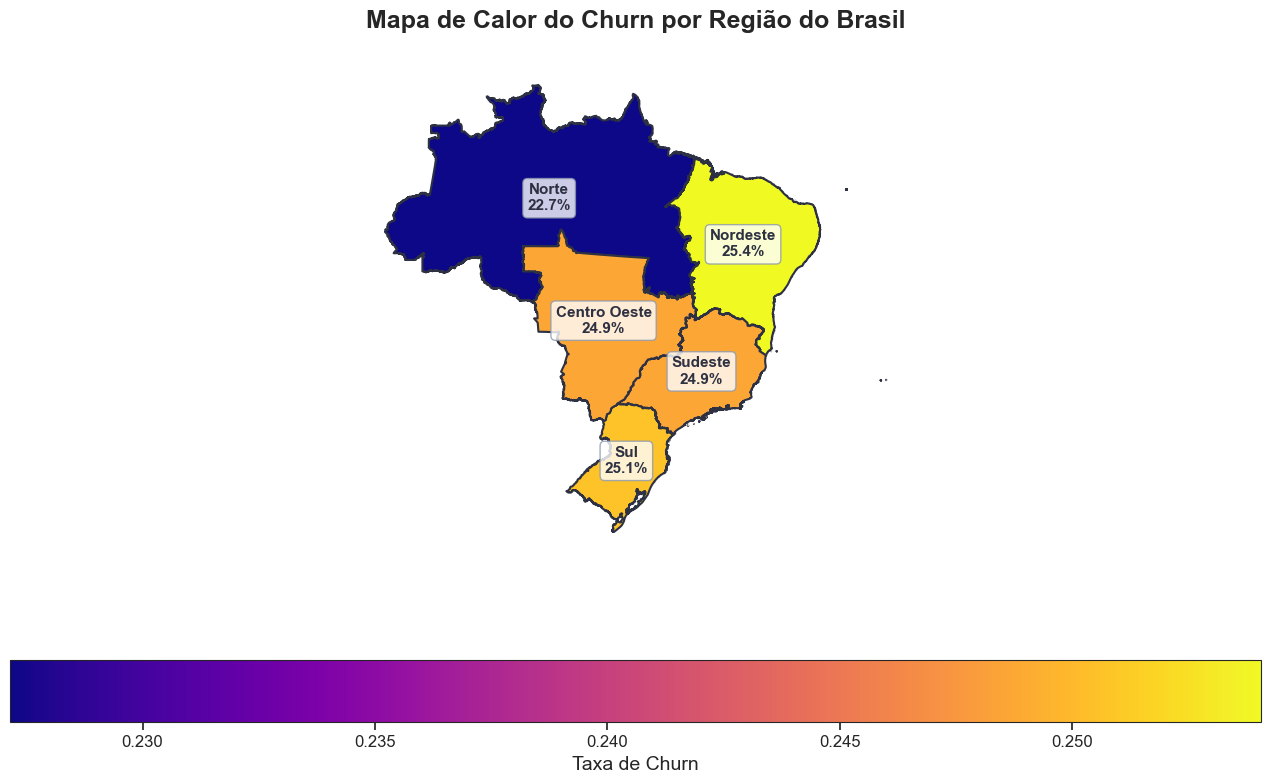

📊 Taxa de Churn por Região:
  Nordeste: 25.4%
  Sul: 25.1%
  Centro Oeste: 24.9%
  Sudeste: 24.9%
  Norte: 22.7%

📊 Taxa de Churn por Região (ordenado):
regiao
Nordeste        25.4%
Sul             25.1%
Centro Oeste    24.9%
Sudeste         24.9%
Norte           22.7%
Name: churn, dtype: object


In [29]:
# ------------------------------------
# 4 MAPA DE CALOR GEOGRÁFICO DO CHURN
# -----------------------------------
# Criar figura
fig, ax = criar_figura('dashboard')

# 1. Calcular taxa de churn por região 
churn_por_regiao = df.groupby('regiao')['churn'].mean().reset_index()

# 2. Padronizar nomes das regiões 
mapeamento_regioes = {
    'sul': 'Sul', 'Sul': 'Sul',
    'sudeste': 'Sudeste', 'Sudeste': 'Sudeste',
    'centro-oeste': 'Centro-Oeste', 'Centro Oeste': 'Centro-Oeste', 'Centro-Oeste': 'Centro Oeste',
    'nordeste': 'Nordeste', 'Nordeste': 'Nordeste',
    'norte': 'Norte', 'Norte': 'Norte'
}

churn_por_regiao['regiao'] = churn_por_regiao['regiao'].map(mapeamento_regioes)

# 3. Carregar mapa das regiões brasileiras usando geobr
try: 
    # Garantindo geobr
    import geobr
    
    # Baixar mapa das regiões
    regioes_br = geobr.read_region(year=2020)
    
    # 4. Juntar dados com o mapa
    mapa_com_dados = regioes_br.merge(
        churn_por_regiao, 
        left_on='name_region', 
        right_on='regiao',
        how='left'
    )
    
    # 5. Plotar mapa de calor
    mapa_com_dados.plot(
        column='churn',
        cmap=GRADIENTES_ACESSIVEIS['risco'],  
        linewidth=1.5,
        edgecolor=PALETA_CHURN['neutro_escuro'],
        legend=True,
        legend_kwds={
            'label': 'Taxa de Churn',
            'orientation': 'horizontal',
            'shrink': 0.8
        },
        ax=ax,
        missing_kwds={
            'color': PALETA_CHURN['neutro_claro'],
            'label': 'Sem dados',
            'hatch': '///'
        }
    )
    
    # 6. Adicionar rótulos das regiões
    for idx, row in mapa_com_dados.iterrows():
        if pd.notna(row['churn']):
            # Centro do polígono
            centroid = row['geometry'].centroid
            ax.text(
                centroid.x, centroid.y,
                f"{row['regiao']}\n{row['churn']:.1%}",
                ha='center', va='center',
                fontsize=11,
                fontweight='bold',
                color=PALETA_CHURN['neutro_escuro'],
                bbox=dict(boxstyle="round,pad=0.3", 
                         facecolor='white', 
                         alpha=0.8,
                         edgecolor=PALETA_CHURN['neutro_medio'])
            )
    
    ax.set_title('Mapa de Calor do Churn por Região do Brasil', 
                 fontsize=18, pad=25, fontweight='bold')
    ax.axis('off')

except ImportError:
    # Fallback: gráfico de barras se geobr não estiver instalado
    print("Instale geobr: pip install geobr")
    
    # Ordenar regiões de Norte a Sul
    ordem_regioes = ['Norte', 'Nordeste', 'Centro-Oeste', 'Sudeste', 'Sul']
    churn_ordenado = churn_por_regiao.set_index('regiao').reindex(ordem_regioes).reset_index()
    
    # Gráfico de barras coloridas
    bars = ax.bar(
        churn_ordenado['regiao'],
        churn_ordenado['churn'],
        color=[PALETA_CATEGORIAS['regiao'][r] for r in churn_ordenado['regiao']]
    )
    
    # Adicionar valores
    for bar, valor in zip(bars, churn_ordenado['churn']):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2,
            height + 0.01,
            f'{valor:.1%}',
            ha='center', va='bottom',
            fontweight='bold',
            color=PALETA_CHURN['neutro_escuro']
        )
    
    ax.set_title('Taxa de Churn por Região', fontsize=16, pad=20)
    ax.set_ylabel('Taxa de Churn', fontweight='bold')
    ax.set_xlabel('Região', fontweight='bold')
    ax.set_ylim(0, churn_ordenado['churn'].max() * 1.2)
    plt.xticks(rotation=0)

plt.tight_layout()
fig.savefig('Grafico Mapa de Calor Regiões', dpi=300)
plt.show()

# Estatísticas resumidas (CORRIGIDO)
print("📊 Taxa de Churn por Região:")
for _, row in churn_por_regiao.sort_values('churn', ascending=False).iterrows():
    print(f"  {row['regiao']}: {row['churn']:.1%}")

# Ou ainda mais simples:
print("\n📊 Taxa de Churn por Região (ordenado):")
print(churn_por_regiao.sort_values('churn', ascending=False)
      .set_index('regiao')['churn']
      .apply(lambda x: f"{x:.1%}"))

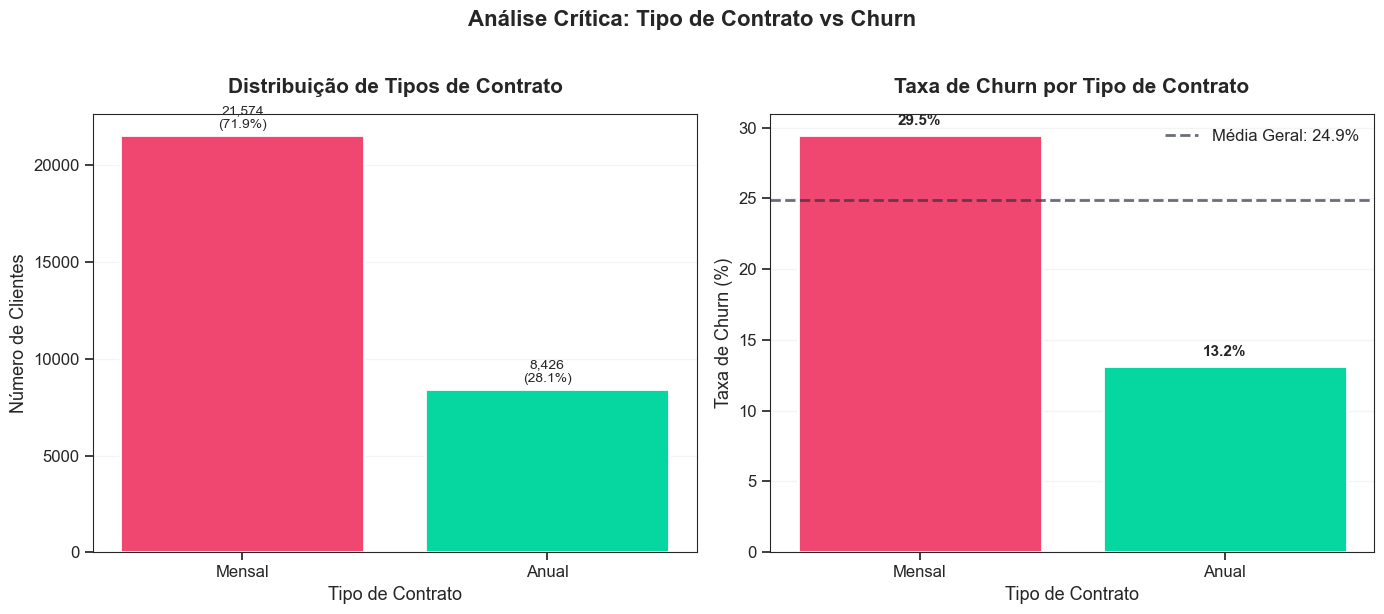

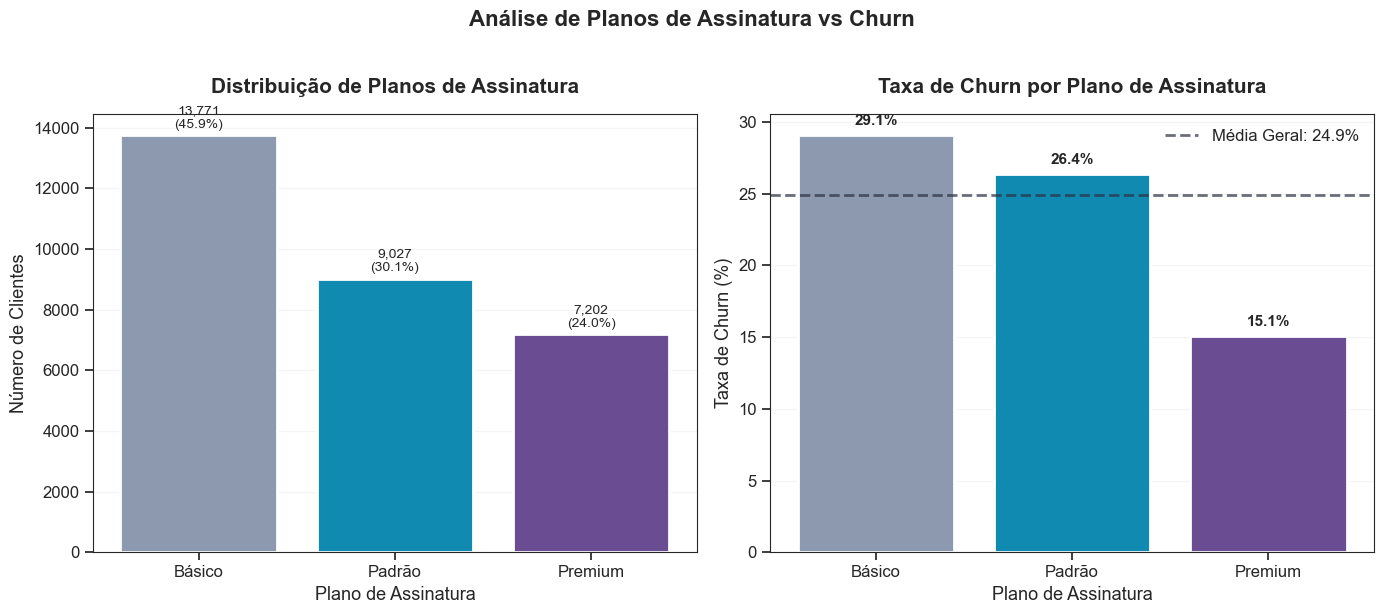

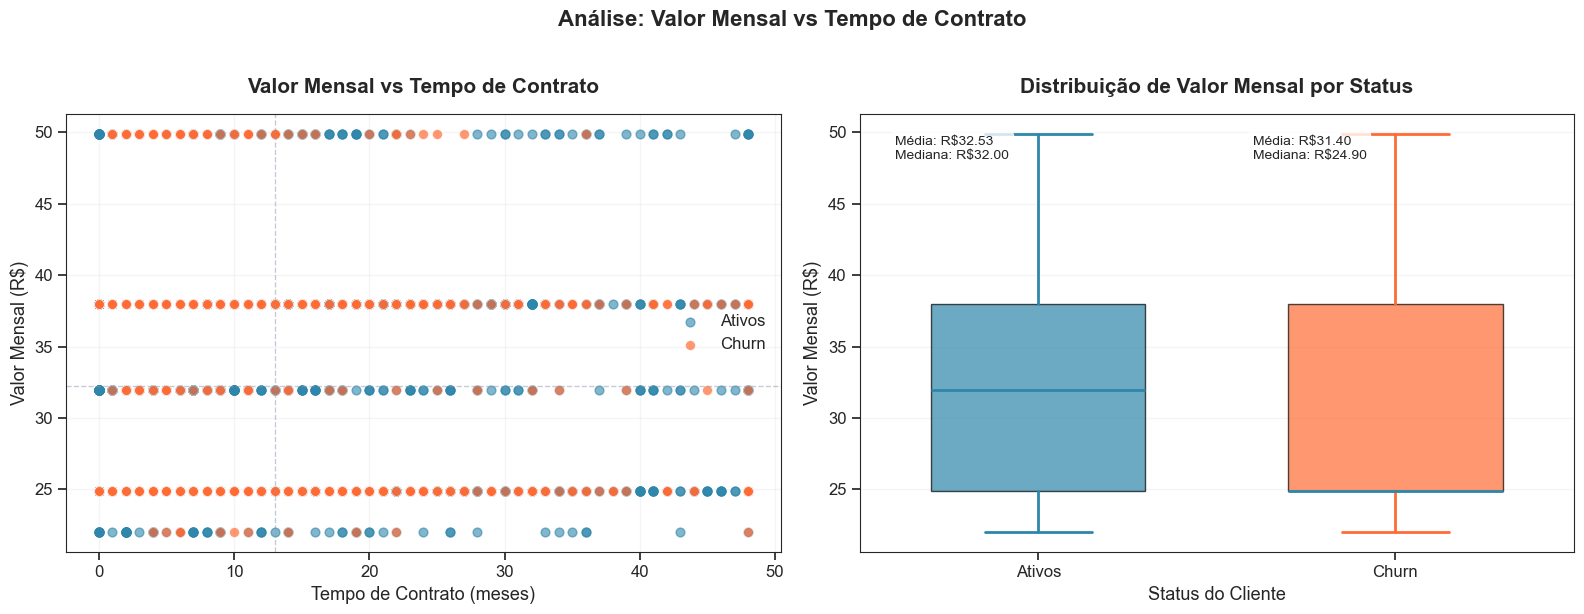

ANÁLISE NUMÉRICA: CORRELAÇÕES

Correlação entre variáveis:
                        valor_mensal  tempo_assinatura_meses  churn
valor_mensal                   1.000                   0.004 -0.062
tempo_assinatura_meses         0.004                   1.000 -0.008
churn                         -0.062                  -0.008  1.000

TAXAS DE CHURN DETALHADAS:
Mensal     →   29.5% de churn (21,574 clientes)
Anual      →   13.2% de churn (8,426 clientes)

TAXAS DE CHURN POR PLANO:
Padrão     →   26.4% de churn (9,027 clientes)
Premium    →   15.1% de churn (7,202 clientes)
Básico     →   29.1% de churn (13,771 clientes)


In [30]:
# ------------------------------------------------
# 5 ANÁLISE DE TIPO DE CONTRATO E PLANOS vs CHURN
# ------------------------------------------------

# 1. ANÁLISE DE TIPO DE CONTRATO
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Distribuição de contratos
contrato_counts = df['tipo_contrato'].value_counts()
bars_contrato = ax1.bar(contrato_counts.index, contrato_counts.values, 
                        color=[PALETA_CATEGORIAS['tipo_contrato'][c] for c in contrato_counts.index],
                        edgecolor='white', linewidth=2)

ax1.set_title('Distribuição de Tipos de Contrato', fontsize=15, fontweight='bold', pad=15)
ax1.set_xlabel('Tipo de Contrato', fontsize=13)
ax1.set_ylabel('Número de Clientes', fontsize=13)
ax1.grid(True, alpha=0.2, axis='y')

# Adicionar valores e porcentagens
for bar in bars_contrato:
    height = bar.get_height()
    percentage = (height / len(df)) * 100
    ax1.text(bar.get_x() + bar.get_width()/2., height + max(contrato_counts.values)*0.01,
             f'{height:,}\n({percentage:.1f}%)', ha='center', va='bottom', fontsize=10)

# Subplot 2: Taxa de churn por tipo de contrato
contrato_churn = df.groupby('tipo_contrato')['churn'].agg(['count', 'mean']).sort_values('mean', ascending=False)
contrato_churn['mean'] = contrato_churn['mean'] * 100

bars_churn_contrato = ax2.bar(contrato_churn.index, contrato_churn['mean'],
                              color=[PALETA_CATEGORIAS['tipo_contrato'][c] for c in contrato_churn.index],
                              edgecolor='white', linewidth=2)

ax2.set_title('Taxa de Churn por Tipo de Contrato', fontsize=15, fontweight='bold', pad=15)
ax2.set_xlabel('Tipo de Contrato', fontsize=13)
ax2.set_ylabel('Taxa de Churn (%)', fontsize=13)
ax2.grid(True, alpha=0.2, axis='y')

# Adicionar valores
for bar, taxa in zip(bars_churn_contrato, contrato_churn['mean']):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
             f'{taxa:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Adicionar linha da média geral
media_geral_churn = df['churn'].mean() * 100
ax2.axhline(y=media_geral_churn, color=PALETA_CHURN['neutro_escuro'], 
            linestyle='--', linewidth=2, alpha=0.7,
            label=f'Média Geral: {media_geral_churn:.1f}%')
ax2.legend(loc='upper right')

plt.suptitle('Análise Crítica: Tipo de Contrato vs Churn', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
fig1.savefig('Grafico Taxa de Churn por Tipo de Contrato', dpi=300)
plt.show()

# 2. ANÁLISE DE PLANO DE ASSINATURA
fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Distribuição de planos
plano_counts = df['plano_assinatura'].value_counts()
bars_plano = ax3.bar(plano_counts.index, plano_counts.values,
                     color=[PALETA_CATEGORIAS['plano_assinatura'][p] for p in plano_counts.index],
                     edgecolor='white', linewidth=2)

ax3.set_title('Distribuição de Planos de Assinatura', fontsize=15, fontweight='bold', pad=15)
ax3.set_xlabel('Plano de Assinatura', fontsize=13)
ax3.set_ylabel('Número de Clientes', fontsize=13)
ax3.grid(True, alpha=0.2, axis='y')

# Adicionar valores e porcentagens
for bar in bars_plano:
    height = bar.get_height()
    percentage = (height / len(df)) * 100
    ax3.text(bar.get_x() + bar.get_width()/2., height + max(plano_counts.values)*0.01,
             f'{height:,}\n({percentage:.1f}%)', ha='center', va='bottom', fontsize=10)

# Subplot 2: Taxa de churn por plano
plano_churn = df.groupby('plano_assinatura')['churn'].agg(['count', 'mean']).sort_values('mean', ascending=False)
plano_churn['mean'] = plano_churn['mean'] * 100

bars_churn_plano = ax4.bar(plano_churn.index, plano_churn['mean'],
                           color=[PALETA_CATEGORIAS['plano_assinatura'][p] for p in plano_churn.index],
                           edgecolor='white', linewidth=2)

ax4.set_title('Taxa de Churn por Plano de Assinatura', fontsize=15, fontweight='bold', pad=15)
ax4.set_xlabel('Plano de Assinatura', fontsize=13)
ax4.set_ylabel('Taxa de Churn (%)', fontsize=13)
ax4.grid(True, alpha=0.2, axis='y')

# Adicionar valores
for bar, taxa in zip(bars_churn_plano, plano_churn['mean']):
    ax4.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
             f'{taxa:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Adicionar linha da média geral
ax4.axhline(y=media_geral_churn, color=PALETA_CHURN['neutro_escuro'], 
            linestyle='--', linewidth=2, alpha=0.7,
            label=f'Média Geral: {media_geral_churn:.1f}%')
ax4.legend(loc='upper right')

plt.suptitle('Análise de Planos de Assinatura vs Churn', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
fig2.savefig('Grafico Análise de Planos de Assinatura vs Churn', dpi=300)
plt.show()

# 3. ANÁLISE DE VALOR MENSAL vs TEMPO DE CONTRATO
fig3, (ax5, ax6) = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Dispersão Valor Mensal vs Tempo de Contrato (colorido por Churn)
amostra = df.sample(min(3000, len(df)), random_state=42)  # Amostra para melhor visualização

# Separar dados por status de churn
ativos = amostra[amostra['churn'] == 0]
churners = amostra[amostra['churn'] == 1]

# Plotar ativos
scatter1 = ax5.scatter(ativos['tempo_assinatura_meses'], ativos['valor_mensal'],
                      alpha=0.6, s=40, label='Ativos',
                      color=PALETA_CHURN['ativo'])

# Plotar churn
scatter2 = ax5.scatter(churners['tempo_assinatura_meses'], churners['valor_mensal'],
                      alpha=0.7, s=50, label='Churn',
                      color=PALETA_CHURN['churn'], edgecolors='white', linewidth=0.5)

ax5.set_title('Valor Mensal vs Tempo de Contrato', fontsize=15, fontweight='bold', pad=15)
ax5.set_xlabel('Tempo de Contrato (meses)', fontsize=13)
ax5.set_ylabel('Valor Mensal (R$)', fontsize=13)
ax5.legend(fontsize=12)
ax5.grid(True, alpha=0.2)

# Adicionar linhas de média
ax5.axhline(y=df['valor_mensal'].mean(), color=PALETA_CHURN['neutro_medio'], 
            linestyle='--', alpha=0.5, linewidth=1)
ax5.axvline(x=df['tempo_assinatura_meses'].mean(), color=PALETA_CHURN['neutro_medio'], 
            linestyle='--', alpha=0.5, linewidth=1)

# Subplot 2: Boxplot comparativo
dados_boxplot = []
labels_boxplot = []
cores_boxplot = []

for status, label, cor in [(0, 'Ativos', PALETA_CHURN['ativo']), (1, 'Churn', PALETA_CHURN['churn'])]:
    dados_status = df[df['churn'] == status]
    dados_boxplot.append(dados_status['valor_mensal'])
    labels_boxplot.append(label)
    cores_boxplot.append(cor)

# Criar boxplot
box = ax6.boxplot(dados_boxplot, labels=labels_boxplot, patch_artist=True, widths=0.6)

# Colorir as caixas
for patch, color in zip(box['boxes'], cores_boxplot):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Configurar cores das outras partes do boxplot
for element in ['whiskers', 'caps', 'medians']:
    for i, line in enumerate(box[element]):
        line.set_color(cores_boxplot[i//2])
        line.set_linewidth(2)

ax6.set_title('Distribuição de Valor Mensal por Status', fontsize=15, fontweight='bold', pad=15)
ax6.set_xlabel('Status do Cliente', fontsize=13)
ax6.set_ylabel('Valor Mensal (R$)', fontsize=13)
ax6.grid(True, alpha=0.2, axis='y')

# Adicionar estatísticas
stats_ativos = df[df['churn'] == 0]['valor_mensal'].describe()
stats_churn = df[df['churn'] == 1]['valor_mensal'].describe()

ax6.text(0.05, 0.95, f'Média: R${stats_ativos["mean"]:.2f}\nMediana: R${stats_ativos["50%"]:.2f}',
         transform=ax6.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax6.text(0.55, 0.95, f'Média: R${stats_churn["mean"]:.2f}\nMediana: R${stats_churn["50%"]:.2f}',
         transform=ax6.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle('Análise: Valor Mensal vs Tempo de Contrato', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
fig3.savefig('Grafico Análise Valor Mensal vs Tempo de Contrato', dpi=300)
plt.show()

# 4. ANÁLISE ADICIONAL: Correlação entre variáveis
print("=" * 70)
print("ANÁLISE NUMÉRICA: CORRELAÇÕES")
print("=" * 70)

# Calcular correlações
correlacoes = df[['valor_mensal', 'tempo_assinatura_meses',  'churn']].corr()
print("\nCorrelação entre variáveis:")
print(correlacoes.round(3))

# Análise específica por tipo de contrato
print("\n" + "=" * 70)
print("TAXAS DE CHURN DETALHADAS:")
print("=" * 70)

for contrato in df['tipo_contrato'].unique():
    taxa = df[df['tipo_contrato'] == contrato]['churn'].mean() * 100
    total = len(df[df['tipo_contrato'] == contrato])
    print(f"{contrato:<10} → {taxa:6.1f}% de churn ({total:,} clientes)")

print("\n" + "=" * 70)
print("TAXAS DE CHURN POR PLANO:")
print("=" * 70)

for plano in df['plano_assinatura'].unique():
    taxa = df[df['plano_assinatura'] == plano]['churn'].mean() * 100
    total = len(df[df['plano_assinatura'] == plano])
    print(f"{plano:<10} → {taxa:6.1f}% de churn ({total:,} clientes)")

print("=" * 70)

## 

###### ============================================
### `ANALISE DE COMPORTAMENTO DE USO`
###### ============================================

ANÁLISE DE RISCO POR ÚLTIMO ACESSO

Ativo (≤ 7 dias):
  • Clientes: 4,452 (14.8%)
  • Taxa de churn: 6.6%
  • Risco relativo: 0.3x 🟢 BAIXO RISCO

Inativo (8-30 dias):
  • Clientes: 16,364 (54.5%)
  • Taxa de churn: 16.7%
  • Risco relativo: 0.7x 🟢 BAIXO RISCO

Risco Médio (31-60 dias):
  • Clientes: 7,837 (26.1%)
  • Taxa de churn: 42.7%
  • Risco relativo: 1.7x 🟠 RISCO ELEVADO

Churn Iminente (> 60 dias):
  • Clientes: 1,347 (4.5%)
  • Taxa de churn: 81.7%
  • Risco relativo: 3.3x 🔴 ALTO RISCO

ESTATÍSTICAS GERAIS:
• Média de dias desde último acesso: 24.9 dias
• Mediana: 22 dias
• Clientes com mais de 30 dias sem acesso: 9,184
• % de clientes inativos (>7 dias): 85.2%


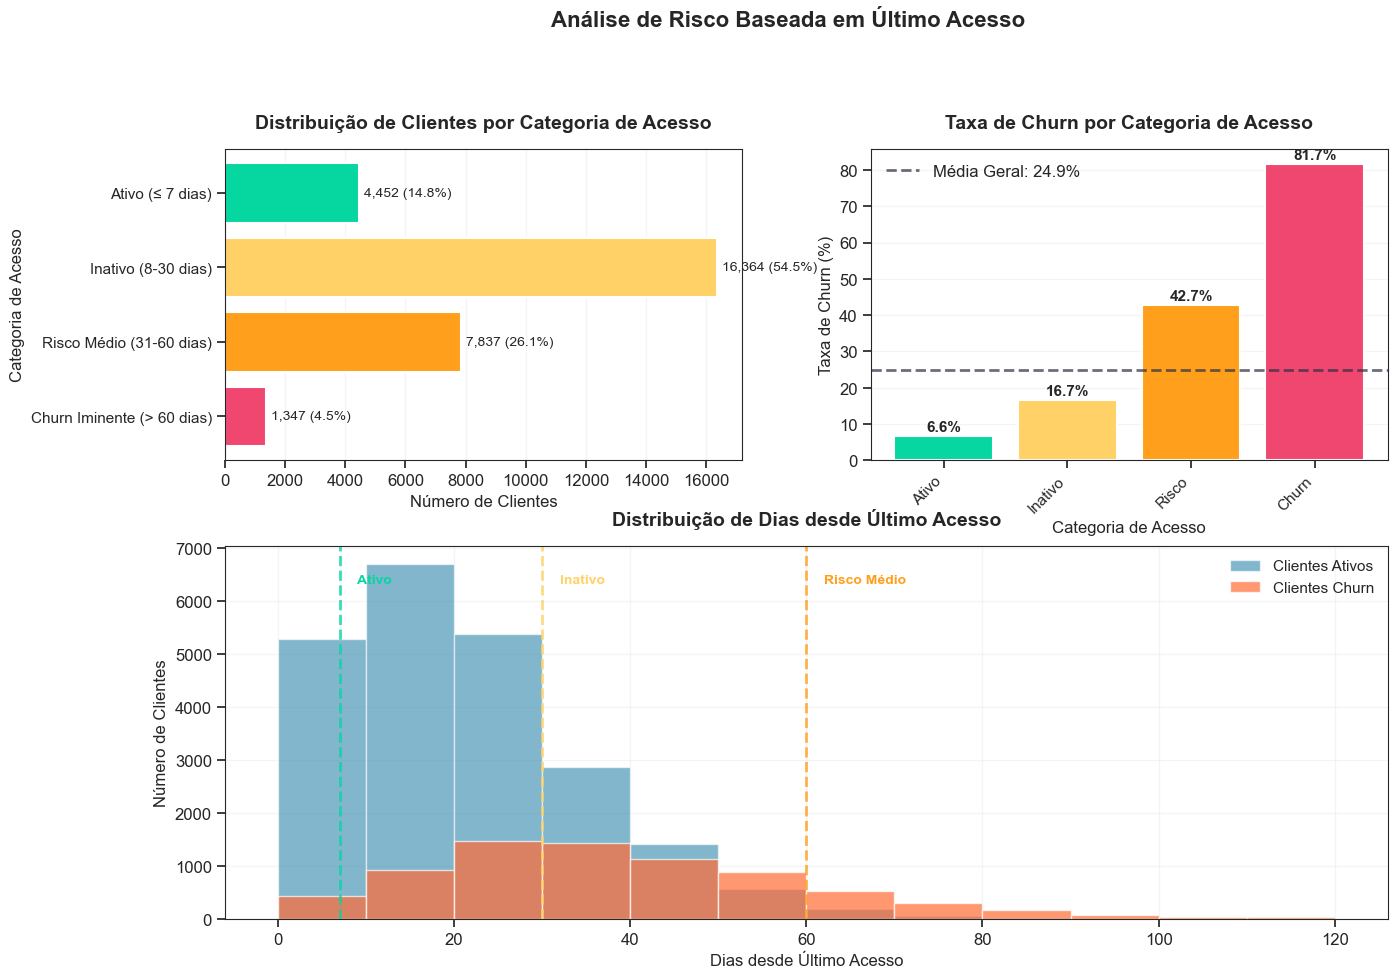

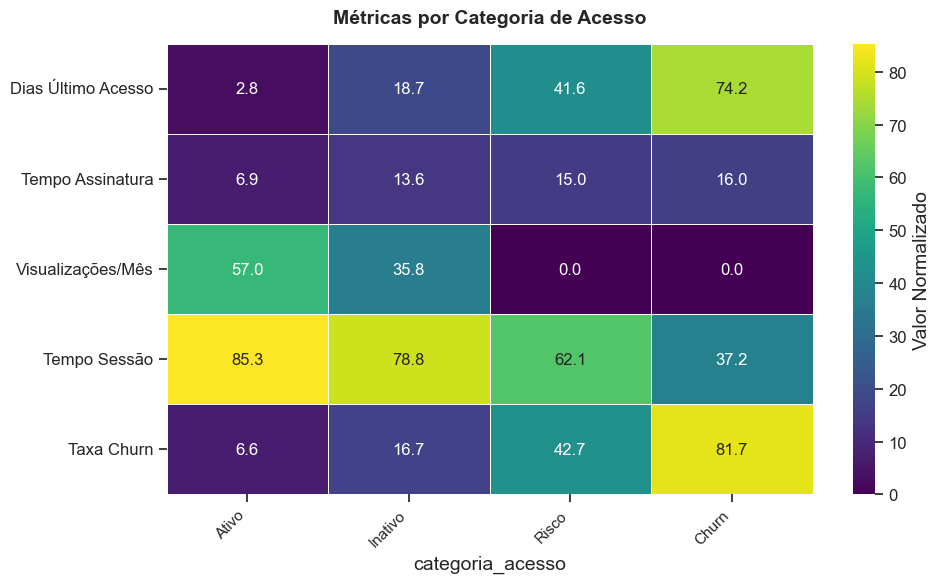

In [31]:
# ------------------------------------------------
# 1 ANÁLISE DE ÚLTIMO ACESSO: CATEGORIZAÇÃO DE RISCO
# ------------------------------------------------

# 1. CRIAR CATEGORIAS BASEADAS NO ÚLTIMO ACESSO
def categorizar_risco_acesso(dias):
    """Categoriza clientes baseado em dias desde o último acesso."""
    if dias <= 7:
        return 'Ativo (≤ 7 dias)'
    elif dias <= 30:
        return 'Inativo (8-30 dias)'
    elif dias <= 60:
        return 'Risco Médio (31-60 dias)'
    else:
        return 'Churn Iminente (> 60 dias)'

# Aplicar categorização
df['categoria_acesso'] = df['dias_ultimo_acesso'].apply(categorizar_risco_acesso)

# Definir ordem lógica das categorias
ordem_categorias = ['Ativo (≤ 7 dias)', 'Inativo (8-30 dias)', 
                    'Risco Médio (31-60 dias)', 'Churn Iminente (> 60 dias)']

# Criar paleta para categorias de acesso
paleta_acesso = {
    'Ativo (≤ 7 dias)': '#06D6A0',         # Verde - baixo risco
    'Inativo (8-30 dias)': '#FFD166',      # Amarelo - atenção
    'Risco Médio (31-60 dias)': '#FF9F1C', # Laranja - médio risco
    'Churn Iminente (> 60 dias)': '#EF476F' # Vermelho - alto risco
}

# 2. CRIAR VISUALIZAÇÃO PRINCIPAL
fig = plt.figure(figsize=(15, 10))

# Layout: 2 linhas, 2 colunas
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.2], hspace=0.25, wspace=0.25)

# ------------------------------------------------------------
# SUBPLOT 1: Distribuição por categoria de acesso
# ------------------------------------------------------------
ax1 = fig.add_subplot(gs[0, 0])

# Contar clientes por categoria
categoria_counts = df['categoria_acesso'].value_counts().reindex(ordem_categorias)

# Criar barras horizontais para melhor leitura dos labels
bars = ax1.barh(range(len(categoria_counts)), categoria_counts.values,
                color=[paleta_acesso[cat] for cat in categoria_counts.index],
                edgecolor='white', linewidth=1.5)

ax1.set_title('Distribuição de Clientes por Categoria de Acesso', 
              fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('Número de Clientes', fontsize=12)
ax1.set_ylabel('Categoria de Acesso', fontsize=12)
ax1.set_yticks(range(len(categoria_counts)))
ax1.set_yticklabels(categoria_counts.index, fontsize=11)
ax1.invert_yaxis()  # Colocar Ativo no topo
ax1.grid(True, alpha=0.2, axis='x')

# Adicionar valores e porcentagens
for i, (bar, count) in enumerate(zip(bars, categoria_counts.values)):
    percentage = (count / len(df)) * 100
    ax1.text(bar.get_width() + max(categoria_counts.values)*0.01, 
             bar.get_y() + bar.get_height()/2,
             f'{count:,} ({percentage:.1f}%)', 
             va='center', fontsize=10)

# ------------------------------------------------------------
# SUBPLOT 2: Taxa de churn por categoria de acesso
# ------------------------------------------------------------
ax2 = fig.add_subplot(gs[0, 1])

# Calcular taxa de churn por categoria
churn_por_categoria = df.groupby('categoria_acesso')['churn'].agg(['count', 'mean'])
churn_por_categoria = churn_por_categoria.reindex(ordem_categorias)
churn_por_categoria['mean'] = churn_por_categoria['mean'] * 100

# Criar barras
bars_churn = ax2.bar(churn_por_categoria.index, churn_por_categoria['mean'],
                     color=[paleta_acesso[cat] for cat in churn_por_categoria.index],
                     edgecolor='white', linewidth=1.5)

ax2.set_title('Taxa de Churn por Categoria de Acesso', 
              fontsize=14, fontweight='bold', pad=15)
ax2.set_xlabel('Categoria de Acesso', fontsize=12)
ax2.set_ylabel('Taxa de Churn (%)', fontsize=12)
ax2.set_xticklabels([cat.split(' ')[0] for cat in churn_por_categoria.index], 
                    rotation=45, ha='right', fontsize=11)
ax2.grid(True, alpha=0.2, axis='y')

# Adicionar valores nas barras
for bar, taxa in zip(bars_churn, churn_por_categoria['mean']):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
             f'{taxa:.1f}%', ha='center', va='bottom', 
             fontsize=11, fontweight='bold')

# Linha da média geral
media_geral = df['churn'].mean() * 100
ax2.axhline(y=media_geral, color=PALETA_CHURN['neutro_escuro'], 
            linestyle='--', linewidth=2, alpha=0.7,
            label=f'Média Geral: {media_geral:.1f}%')
ax2.legend(loc='upper left')

# ------------------------------------------------------------
# SUBPLOT 3: Histograma comparativo de dias desde último acesso
# ------------------------------------------------------------
ax3 = fig.add_subplot(gs[1, :])

# Separar dados por status de churn
ativos_acesso = df[df['churn'] == 0]['dias_ultimo_acesso']
churn_acesso = df[df['churn'] == 1]['dias_ultimo_acesso']

# Criar histograma sobreposto
bins = np.arange(0, df['dias_ultimo_acesso'].max() + 10, 10)

ax3.hist(ativos_acesso, bins=bins, alpha=0.6, label='Clientes Ativos',
         color=PALETA_CHURN['ativo'], edgecolor='white')
ax3.hist(churn_acesso, bins=bins, alpha=0.7, label='Clientes Churn',
         color=PALETA_CHURN['churn'], edgecolor='white')

# Adicionar linhas verticais para os limites das categorias
limites = [7, 30, 60]
cores_limites = ['#06D6A0', '#FFD166', '#FF9F1C']
labels_limites = ['Ativo', 'Inativo', 'Risco Médio']

for limite, cor, label in zip(limites, cores_limites, labels_limites):
    ax3.axvline(x=limite, color=cor, linestyle='--', linewidth=2, alpha=0.8)
    ax3.text(limite + 2, ax3.get_ylim()[1] * 0.9, label, 
             color=cor, fontsize=10, fontweight='bold')

ax3.set_title('Distribuição de Dias desde Último Acesso', 
              fontsize=14, fontweight='bold', pad=15)
ax3.set_xlabel('Dias desde Último Acesso', fontsize=12)
ax3.set_ylabel('Número de Clientes', fontsize=12)
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.2)

# ------------------------------------------------------------
# SUBPLOT 4: Heatmap de correlação com outras métricas
# ------------------------------------------------------------
# Criar figura adicional para heatmap
fig2, ax4 = plt.subplots(figsize=(10, 6))

# Calcular estatísticas por categoria
estatisticas_por_categoria = pd.DataFrame({
    'Dias Último Acesso': df.groupby('categoria_acesso')['dias_ultimo_acesso'].mean(),
    'Tempo Assinatura': df.groupby('categoria_acesso')['tempo_assinatura_meses'].mean(),
    'Visualizações/Mês': df.groupby('categoria_acesso')['visualizacoes_mes'].mean(),
    'Tempo Sessão': df.groupby('categoria_acesso')['tempo_medio_sessao_min'].mean(),
    'Taxa Churn': churn_por_categoria['mean']
})

# Reordenar as categorias
estatisticas_por_categoria = estatisticas_por_categoria.reindex(ordem_categorias)

# Criar heatmap
sns.heatmap(estatisticas_por_categoria.T, annot=True, fmt='.1f',
            cmap=GRADIENTES_ACESSIVEIS['engajamento'], 
            linewidths=0.5, linecolor='white',
            cbar_kws={'label': 'Valor Normalizado'}, ax=ax4)

ax4.set_title('Métricas por Categoria de Acesso', 
              fontsize=14, fontweight='bold', pad=15)
ax4.set_xticklabels([cat.split(' ')[0] for cat in estatisticas_por_categoria.index], 
                    rotation=45, ha='right', fontsize=11)

# 3. AJUSTES FINAIS
fig.suptitle('Análise de Risco Baseada em Último Acesso', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()

# Ajustar layout da segunda figura
fig2.tight_layout()

fig.savefig('Grafico Análise de Risco Baseada em Último Acesso', dpi=300)
fig2.savefig('Grafico metricas por cataegoria de acesso', dpi=300)

# 4. EXIBIR ESTATÍSTICAS RESUMIDAS
print("=" * 70)
print("ANÁLISE DE RISCO POR ÚLTIMO ACESSO")
print("=" * 70)

for categoria in ordem_categorias:
    dados_categoria = df[df['categoria_acesso'] == categoria]
    total = len(dados_categoria)
    churn_count = dados_categoria['churn'].sum()
    taxa_churn = (churn_count / total) * 100
    
    # Calcular risco relativo
    risco_relativo = taxa_churn / media_geral
    
    if risco_relativo > 2.0:
        risco_label = "🔴 ALTO RISCO"
    elif risco_relativo > 1.5:
        risco_label = "🟠 RISCO ELEVADO"
    elif risco_relativo > 1.0:
        risco_label = "🟡 RISCO MODERADO"
    else:
        risco_label = "🟢 BAIXO RISCO"
    
    print(f"\n{categoria}:")
    print(f"  • Clientes: {total:,} ({total/len(df)*100:.1f}%)")
    print(f"  • Taxa de churn: {taxa_churn:.1f}%")
    print(f"  • Risco relativo: {risco_relativo:.1f}x {risco_label}")

# Estatísticas gerais
print("\n" + "=" * 70)
print("ESTATÍSTICAS GERAIS:")
print("=" * 70)
print(f"• Média de dias desde último acesso: {df['dias_ultimo_acesso'].mean():.1f} dias")
print(f"• Mediana: {df['dias_ultimo_acesso'].median():.0f} dias")
print(f"• Clientes com mais de 30 dias sem acesso: {(df['dias_ultimo_acesso'] > 30).sum():,}")
print(f"• % de clientes inativos (>7 dias): {(df['dias_ultimo_acesso'] > 7).sum()/len(df)*100:.1f}%")
print("=" * 70)

plt.show()
fig2.show()

posx and posy should be finite values


ANÁLISE DE ENGAJAMENTO: VISUALIZAÇÕES vs TEMPO DE SESSÃO

Correlação entre variáveis:
                        visualizacoes_mes  tempo_medio_sessao_min  churn
visualizacoes_mes                   1.000                   0.278 -0.441
tempo_medio_sessao_min              0.278                   1.000 -0.627
churn                              -0.441                  -0.627  1.000

COMPARAÇÃO ATIVOS vs CHURN:

VISUALIZAÇÕES NO MÊS:
Ativos:   Média = 36.1, Mediana = 29
Churn:    Média = 3.5, Mediana = 0
Diferença: 32.6 visualizações

TEMPO MÉDIO DE SESSÃO (min):
Ativos:   Média = 89.6, Mediana = 89
Churn:    Média = 25.0, Mediana = 24
Diferença: 64.6 minutos

CATEGORIAS DE ENGAJAMENTO:

Alto Engajamento:
  • Clientes: 2,480.0 (8.3%)
  • Taxa de churn: 0.0%
  • Risco relativo: 0.0x

Médio Engajamento:
  • Clientes: 14,170.0 (47.2%)
  • Taxa de churn: 4.3%
  • Risco relativo: 0.2x

Baixo Engajamento:
  • Clientes: 13,350.0 (44.5%)
  • Taxa de churn: 51.4%
  • Risco relativo: 2.1x

Engajamento I

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


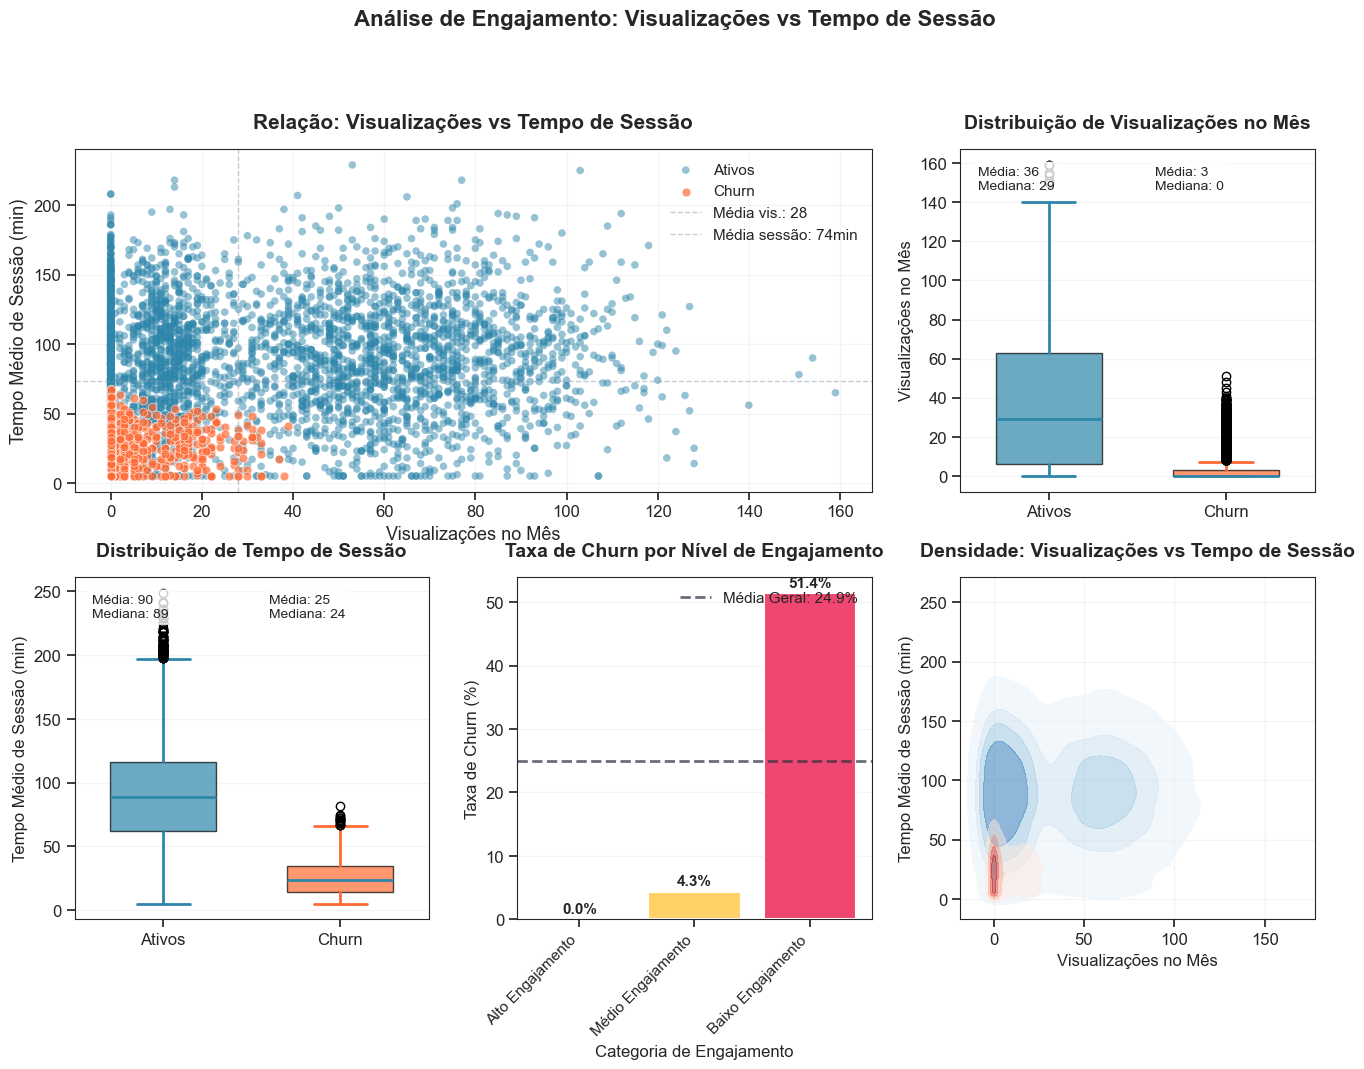

In [32]:
style='--', alpha=0.5, linewidth=1, label=f'Média sessão: {df["tempo_medio_sessao_min"].mean():.0f}min')
ax1.legend(fontsize=11)

# ------------------------------------------------------------
# SUBPLOT 2: Boxplot - distribuição de visualizações
# ------------------------------------------------------------
ax2 = fig.add_subplot(gs[0, 2])

# Preparar dados para boxplot
dados_boxplot_viz = [df[df['churn'] == 0]['visualizacoes_mes'], 
                     df[df['churn'] == 1]['visualizacoes_mes']]

box_viz = ax2.boxplot(dados_boxplot_viz, labels=['Ativos', 'Churn'], 
                      patch_artist=True, widths=0.6)

# Colorir as caixas
box_viz['boxes'][0].set_facecolor(PALETA_CHURN['ativo'])
box_viz['boxes'][1].set_facecolor(PALETA_CHURN['churn'])

# Configurar transparência
for box in box_viz['boxes']:
    box.set_alpha(0.7)

# Configurar cores das outras partes
for element in ['whiskers', 'caps', 'medians']:
    for i, line in enumerate(box_viz[element]):
        line.set_color([PALETA_CHURN['ativo'], PALETA_CHURN['churn']][i//2])
        line.set_linewidth(2)

ax2.set_title('Distribuição de Visualizações no Mês', 
              fontsize=14, fontweight='bold', pad=15)
ax2.set_ylabel('Visualizações no Mês', fontsize=12)
ax2.grid(True, alpha=0.2, axis='y')

# Adicionar estatísticas
stats_viz_ativos = df[df['churn'] == 0]['visualizacoes_mes'].describe()
stats_viz_churn = df[df['churn'] == 1]['visualizacoes_mes'].describe()

ax2.text(0.05, 0.95, f'Média: {stats_viz_ativos["mean"]:.0f}\nMediana: {stats_viz_ativos["50%"]:.0f}',
         transform=ax2.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax2.text(0.55, 0.95, f'Média: {stats_viz_churn["mean"]:.0f}\nMediana: {stats_viz_churn["50%"]:.0f}',
         transform=ax2.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# ------------------------------------------------------------
# SUBPLOT 3: Boxplot - distribuição de tempo de sessão
# ------------------------------------------------------------
ax3 = fig.add_subplot(gs[1, 0])

# Preparar dados para boxplot
dados_boxplot_sessao = [df[df['churn'] == 0]['tempo_medio_sessao_min'], 
                        df[df['churn'] == 1]['tempo_medio_sessao_min']]

box_sessao = ax3.boxplot(dados_boxplot_sessao, labels=['Ativos', 'Churn'], 
                         patch_artist=True, widths=0.6)

# Colorir as caixas
box_sessao['boxes'][0].set_facecolor(PALETA_CHURN['ativo'])
box_sessao['boxes'][1].set_facecolor(PALETA_CHURN['churn'])

# Configurar transparência
for box in box_sessao['boxes']:
    box.set_alpha(0.7)

# Configurar cores das outras partes
for element in ['whiskers', 'caps', 'medians']:
    for i, line in enumerate(box_sessao[element]):
        line.set_color([PALETA_CHURN['ativo'], PALETA_CHURN['churn']][i//2])
        line.set_linewidth(2)

ax3.set_title('Distribuição de Tempo de Sessão', 
              fontsize=14, fontweight='bold', pad=15)
ax3.set_ylabel('Tempo Médio de Sessão (min)', fontsize=12)
ax3.grid(True, alpha=0.2, axis='y')

# Adicionar estatísticas
stats_sessao_ativos = df[df['churn'] == 0]['tempo_medio_sessao_min'].describe()
stats_sessao_churn = df[df['churn'] == 1]['tempo_medio_sessao_min'].describe()

ax3.text(0.05, 0.95, f'Média: {stats_sessao_ativos["mean"]:.0f}\nMediana: {stats_sessao_ativos["50%"]:.0f}',
         transform=ax3.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax3.text(0.55, 0.95, f'Média: {stats_sessao_churn["mean"]:.0f}\nMediana: {stats_sessao_churn["50%"]:.0f}',
         transform=ax3.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# ------------------------------------------------------------
# SUBPLOT 4: Categorizar clientes por engajamento
# ------------------------------------------------------------
# Definir categorias baseadas nos quartis
def categorizar_engajamento(viz, tempo):
    """Categoriza clientes baseado em visualizações e tempo de sessão."""
    if viz > df['visualizacoes_mes'].quantile(0.75) and tempo > df['tempo_medio_sessao_min'].quantile(0.75):
        return 'Alto Engajamento'
    elif viz > df['visualizacoes_mes'].quantile(0.25) and tempo > df['tempo_medio_sessao_min'].quantile(0.25):
        return 'Médio Engajamento'
    elif viz <= df['visualizacoes_mes'].quantile(0.25) or tempo <= df['tempo_medio_sessao_min'].quantile(0.25):
        return 'Baixo Engajamento'
    else:
        return 'Engajamento Irregular'

# Aplicar categorização
df['categoria_engajamento'] = df.apply(
    lambda row: categorizar_engajamento(row['visualizacoes_mes'], row['tempo_medio_sessao_min']), 
    axis=1
)

# Ordem das categorias
ordem_engajamento = ['Alto Engajamento', 'Médio Engajamento', 'Baixo Engajamento', 'Engajamento Irregular']

# Paleta para categorias de engajamento
paleta_engajamento = {
    'Alto Engajamento': '#06D6A0',      # Verde
    'Médio Engajamento': '#FFD166',     # Amarelo
    'Baixo Engajamento': '#EF476F',     # Vermelho
    'Engajamento Irregular': '#8D99AE'  # Cinza
}

ax4 = fig.add_subplot(gs[1, 1])

# Calcular taxa de churn por categoria de engajamento
engajamento_churn = df.groupby('categoria_engajamento')['churn'].agg(['count', 'mean'])
engajamento_churn = engajamento_churn.reindex(ordem_engajamento)
engajamento_churn['mean'] = engajamento_churn['mean'] * 100

bars_engajamento = ax4.bar(engajamento_churn.index, engajamento_churn['mean'],
                          color=[paleta_engajamento[cat] for cat in engajamento_churn.index],
                          edgecolor='white', linewidth=1.5)

ax4.set_title('Taxa de Churn por Nível de Engajamento', 
              fontsize=14, fontweight='bold', pad=15)
ax4.set_xlabel('Categoria de Engajamento', fontsize=12)
ax4.set_ylabel('Taxa de Churn (%)', fontsize=12)
ax4.set_xticklabels(engajamento_churn.index, rotation=45, ha='right', fontsize=11)
ax4.grid(True, alpha=0.2, axis='y')

# Adicionar valores nas barras
for bar, taxa in zip(bars_engajamento, engajamento_churn['mean']):
    ax4.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
             f'{taxa:.1f}%', ha='center', va='bottom', 
             fontsize=11, fontweight='bold')

# Linha da média geral
ax4.axhline(y=media_geral_churn, color=PALETA_CHURN['neutro_escuro'], 
            linestyle='--', linewidth=2, alpha=0.7,
            label=f'Média Geral: {media_geral_churn:.1f}%')
ax4.legend(loc='upper right', fontsize=11)

# ------------------------------------------------------------
# SUBPLOT 5: Heatmap de densidade (KDE 2D)
# ------------------------------------------------------------
ax5 = fig.add_subplot(gs[1, 2])

# Criar KDE 2D separado para ativos e churn
# Para ativos
x_ativos = df[df['churn'] == 0]['visualizacoes_mes']
y_ativos = df[df['churn'] == 0]['tempo_medio_sessao_min']

# Para churn
x_churn = df[df['churn'] == 1]['visualizacoes_mes']
y_churn = df[df['churn'] == 1]['tempo_medio_sessao_min']

# Plotar KDE para ativos
sns.kdeplot(x=x_ativos, y=y_ativos, ax=ax5, 
            fill=True, alpha=0.5, cmap='Blues',
            label='Ativos', levels=5)

# Plotar KDE para churn
sns.kdeplot(x=x_churn, y=y_churn, ax=ax5,
            fill=True, alpha=0.5, cmap='Reds',
            label='Churn', levels=5)

ax5.set_title('Densidade: Visualizações vs Tempo de Sessão', 
              fontsize=14, fontweight='bold', pad=15)
ax5.set_xlabel('Visualizações no Mês', fontsize=12)
ax5.set_ylabel('Tempo Médio de Sessão (min)', fontsize=12)
ax5.legend(fontsize=11)
ax5.grid(True, alpha=0.2)

# 3. AJUSTES FINAIS
fig.suptitle('Análise de Engajamento: Visualizações vs Tempo de Sessão', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()

# 4. ANÁLISE ESTATÍSTICA
print("=" * 70)
print("ANÁLISE DE ENGAJAMENTO: VISUALIZAÇÕES vs TEMPO DE SESSÃO")
print("=" * 70)

# Correlação entre as variáveis
correlacao_geral = df[['visualizacoes_mes', 'tempo_medio_sessao_min', 'churn']].corr()
print("\nCorrelação entre variáveis:")
print(correlacao_geral.round(3))

# Estatísticas por status
print("\n" + "=" * 70)
print("COMPARAÇÃO ATIVOS vs CHURN:")
print("=" * 70)

print("\nVISUALIZAÇÕES NO MÊS:")
print(f"Ativos:   Média = {stats_viz_ativos['mean']:.1f}, Mediana = {stats_viz_ativos['50%']:.0f}")
print(f"Churn:    Média = {stats_viz_churn['mean']:.1f}, Mediana = {stats_viz_churn['50%']:.0f}")
print(f"Diferença: {abs(stats_viz_ativos['mean'] - stats_viz_churn['mean']):.1f} visualizações")

print("\nTEMPO MÉDIO DE SESSÃO (min):")
print(f"Ativos:   Média = {stats_sessao_ativos['mean']:.1f}, Mediana = {stats_sessao_ativos['50%']:.0f}")
print(f"Churn:    Média = {stats_sessao_churn['mean']:.1f}, Mediana = {stats_sessao_churn['50%']:.0f}")
print(f"Diferença: {abs(stats_sessao_ativos['mean'] - stats_sessao_churn['mean']):.1f} minutos")

# Análise por categoria de engajamento
print("\n" + "=" * 70)
print("CATEGORIAS DE ENGAJAMENTO:")
print("=" * 70)

for categoria in ordem_engajamento:
    if categoria in engajamento_churn.index:
        total = engajamento_churn.loc[categoria, 'count']
        taxa = engajamento_churn.loc[categoria, 'mean']
        print(f"\n{categoria}:")
        print(f"  • Clientes: {total:,} ({total/len(df)*100:.1f}%)")
        print(f"  • Taxa de churn: {taxa:.1f}%")
        print(f"  • Risco relativo: {taxa/media_geral_churn:.1f}x")

# Definição dos limites
print("\n" + "=" * 70)
print("DEFINIÇÃO DAS CATEGORIAS:")
print("=" * 70)
print(f"• Visualizações (Q1): {df['visualizacoes_mes'].quantile(0.25):.0f}")
print(f"• Visualizações (Q3): {df['visualizacoes_mes'].quantile(0.75):.0f}")
print(f"• Tempo de sessão (Q1): {df['tempo_medio_sessao_min'].quantile(0.25):.0f} min")
print(f"• Tempo de sessão (Q3): {df['tempo_medio_sessao_min'].quantile(0.75):.0f} min")
print("=" * 70)
fig.savefig('ANÁLISE DE ENGAJAMENTO VISUALIZAÇÕES vs TEMPO DE SESSÃO', dpi=300)
plt.show()

Categorias encontradas: ['Séries' 'Filmes' 'Esportes' 'Documentários' 'Novelas' 'Infantil']
ANÁLISE DE CHURN POR CATEGORIA FAVORITA

Total de clientes analisados: 30,000
Média geral de churn: 24.9%

Número de categorias distintas: 6

DETALHAMENTO POR CATEGORIA:

Séries:
  • Total de clientes: 9,030 (30.1%)
  • Clientes com churn: 2,298
  • Taxa de churn: 25.4%
  • Risco relativo: 1.02x → 🟡 RISCO MODERADO

Documentários:
  • Total de clientes: 4,552 (15.2%)
  • Clientes com churn: 1,146
  • Taxa de churn: 25.2%
  • Risco relativo: 1.01x → 🟡 RISCO MODERADO

Infantil:
  • Total de clientes: 3,032 (10.1%)
  • Clientes com churn: 749
  • Taxa de churn: 24.7%
  • Risco relativo: 0.99x → 🟢 RISCO BAIXO

Novelas:
  • Total de clientes: 1,480 (4.9%)
  • Clientes com churn: 363
  • Taxa de churn: 24.5%
  • Risco relativo: 0.98x → 🟢 RISCO BAIXO

Filmes:
  • Total de clientes: 7,464 (24.9%)
  • Clientes com churn: 1,830
  • Taxa de churn: 24.5%
  • Risco relativo: 0.98x → 🟢 RISCO BAIXO

Esportes:
 

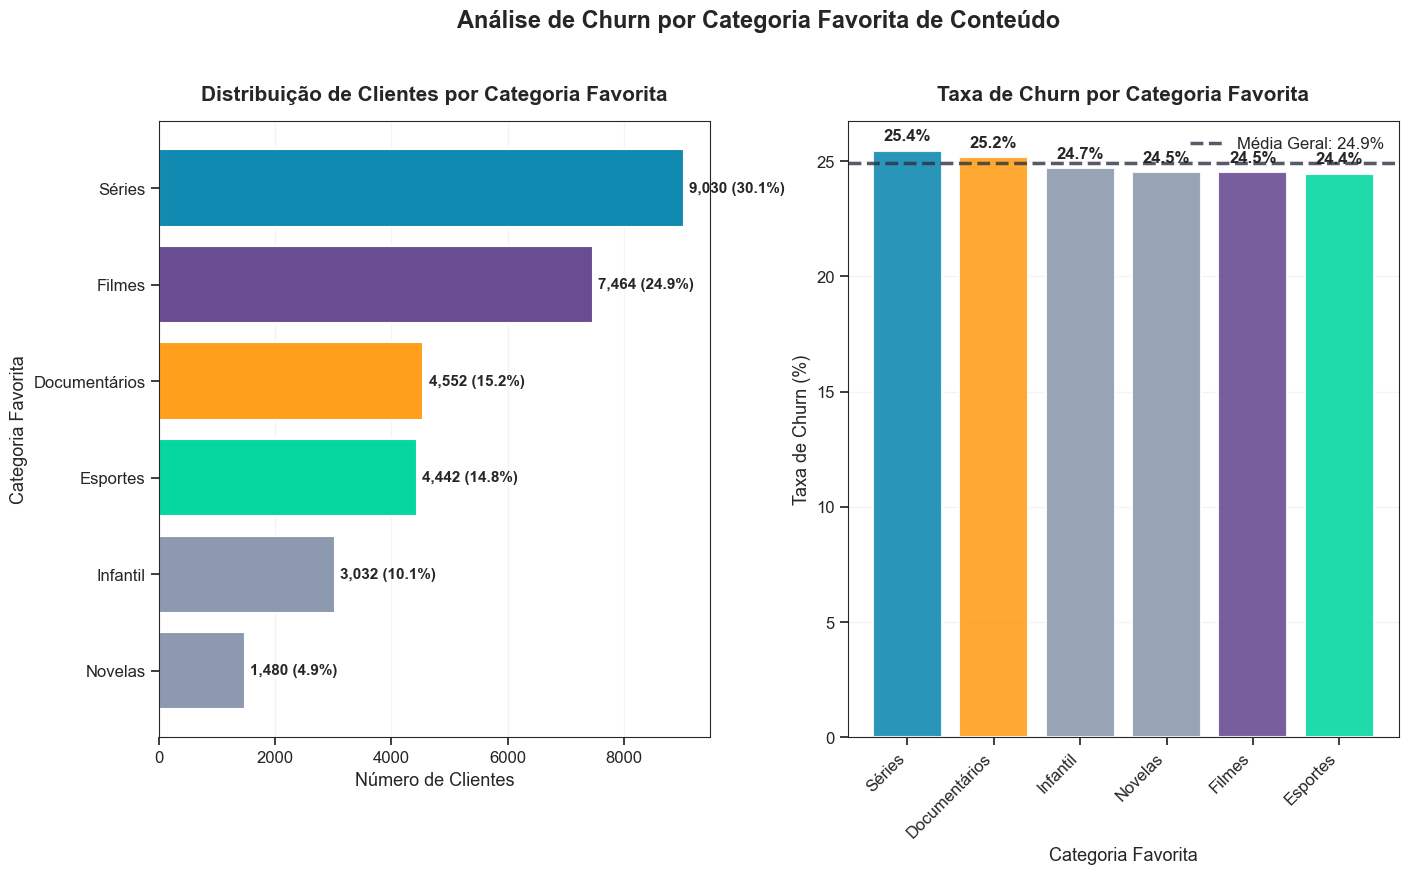

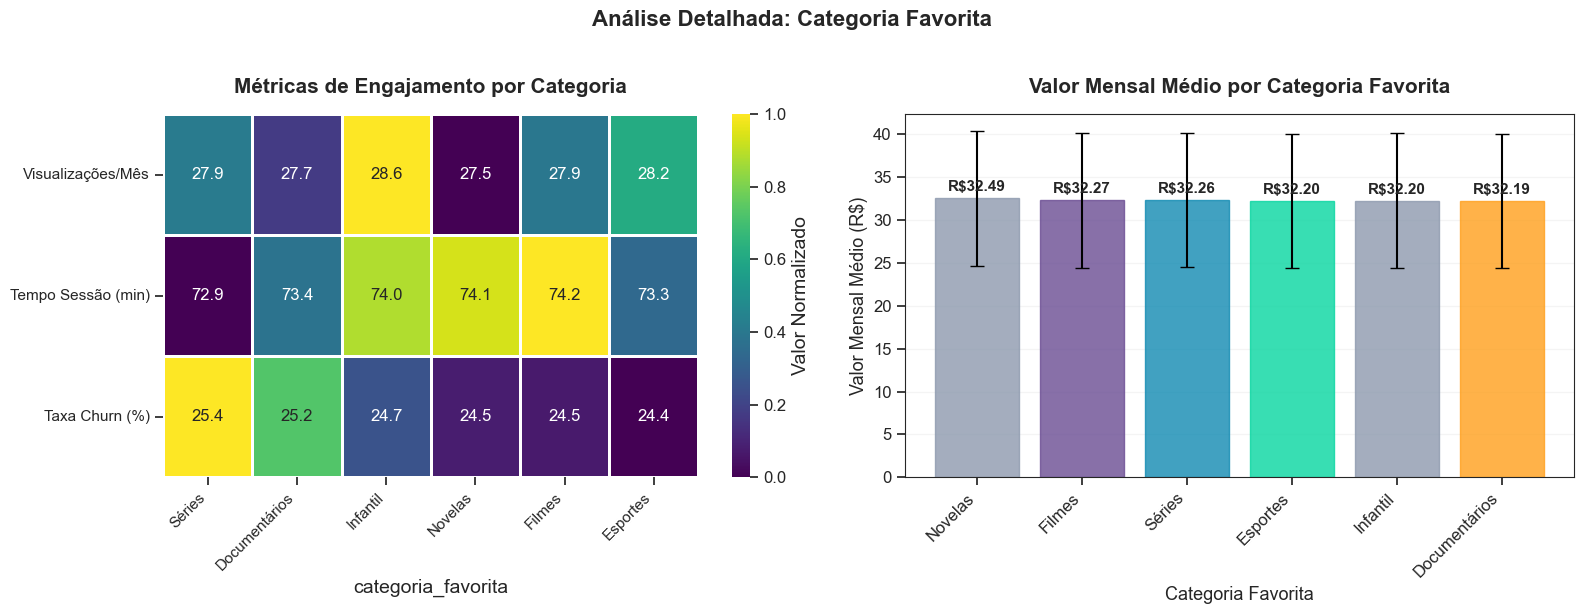

In [33]:
# -----------------------------------------
# 3 ANÁLISE DE CATEGORIA FAVORITA vs CHURN
# -----------------------------------------

# 1. PREPARAR OS DADOS
# Garantir uniformidade nas categorias (maiúsculas/minúsculas)
df['categoria_favorita'] = df['categoria_favorita'].str.capitalize()

# Verificar categorias únicas
categorias_unicas = df['categoria_favorita'].unique()
print(f"Categorias encontradas: {categorias_unicas}")

# 2. CRIAR FIGURA PRINCIPAL
fig = plt.figure(figsize=(16, 8))

# Layout: 1 linha, 2 colunas
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1], wspace=0.25)

# ------------------------------------------------------------
# SUBPLOT 1: Distribuição de clientes por categoria favorita
# ------------------------------------------------------------
ax1 = fig.add_subplot(gs[0, 0])

# Contar clientes por categoria
categoria_counts = df['categoria_favorita'].value_counts()

# Ordenar pelo número de clientes (do maior para o menor)
categoria_counts = categoria_counts.sort_values(ascending=False)

# Criar barras horizontais para melhor legibilidade
bars1 = ax1.barh(range(len(categoria_counts)), categoria_counts.values)

# Aplicar cores da paleta
for i, (bar, categoria) in enumerate(zip(bars1, categoria_counts.index)):
    if categoria in PALETA_CATEGORIAS['categoria_favorita']:
        bar.set_color(PALETA_CATEGORIAS['categoria_favorita'][categoria])
    else:
        bar.set_color(PALETA_CHURN['neutro_medio'])
    bar.set_edgecolor('white')
    bar.set_linewidth(1.5)

ax1.set_title('Distribuição de Clientes por Categoria Favorita', 
              fontsize=15, fontweight='bold', pad=15)
ax1.set_xlabel('Número de Clientes', fontsize=13)
ax1.set_ylabel('Categoria Favorita', fontsize=13)
ax1.set_yticks(range(len(categoria_counts)))
ax1.set_yticklabels(categoria_counts.index, fontsize=12)
ax1.invert_yaxis()  # Maior categoria no topo
ax1.grid(True, alpha=0.2, axis='x')

# Adicionar valores e porcentagens
for i, (bar, count) in enumerate(zip(bars1, categoria_counts.values)):
    percentage = (count / len(df)) * 100
    ax1.text(bar.get_width() + max(categoria_counts.values) * 0.01, 
             bar.get_y() + bar.get_height()/2,
             f'{count:,} ({percentage:.1f}%)', 
             va='center', fontsize=11, fontweight='semibold')

# ------------------------------------------------------------
# SUBPLOT 2: Taxa de churn por categoria favorita
# ------------------------------------------------------------
ax2 = fig.add_subplot(gs[0, 1])

# Calcular taxa de churn por categoria
churn_por_categoria = df.groupby('categoria_favorita')['churn'].agg(['count', 'sum', 'mean'])
churn_por_categoria = churn_por_categoria.sort_values('mean', ascending=False)
churn_por_categoria['taxa_churn'] = churn_por_categoria['mean'] * 100

# Criar barras
bars2 = ax2.bar(range(len(churn_por_categoria)), churn_por_categoria['taxa_churn'])

# Aplicar cores da paleta
for i, (bar, categoria) in enumerate(zip(bars2, churn_por_categoria.index)):
    if categoria in PALETA_CATEGORIAS['categoria_favorita']:
        bar.set_color(PALETA_CATEGORIAS['categoria_favorita'][categoria])
    else:
        bar.set_color(PALETA_CHURN['neutro_medio'])
    bar.set_edgecolor('white')
    bar.set_linewidth(1.5)
    bar.set_alpha(0.9)

ax2.set_title('Taxa de Churn por Categoria Favorita', 
              fontsize=15, fontweight='bold', pad=15)
ax2.set_xlabel('Categoria Favorita', fontsize=13)
ax2.set_ylabel('Taxa de Churn (%)', fontsize=13)
ax2.set_xticks(range(len(churn_por_categoria)))
ax2.set_xticklabels(churn_por_categoria.index, rotation=45, ha='right', fontsize=12)
ax2.grid(True, alpha=0.2, axis='y')

# Adicionar valores nas barras
for bar, taxa in zip(bars2, churn_por_categoria['taxa_churn']):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.3,
             f'{taxa:.1f}%', ha='center', va='bottom', 
             fontsize=12, fontweight='bold')

# Linha da média geral
media_geral_churn = df['churn'].mean() * 100
ax2.axhline(y=media_geral_churn, color=PALETA_CHURN['neutro_escuro'], 
            linestyle='--', linewidth=2.5, alpha=0.8,
            label=f'Média Geral: {media_geral_churn:.1f}%')
ax2.legend(loc='upper right', fontsize=12)

# 3. AJUSTES FINAIS
fig.suptitle('Análise de Churn por Categoria Favorita de Conteúdo', 
             fontsize=17, fontweight='bold', y=1.02)
plt.tight_layout()

# 4. VISUALIZAÇÃO ADICIONAL: Análise multivariada
fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(16, 6))

# ------------------------------------------------------------
# SUBPLOT 3: Engajamento por categoria (visualizações + tempo de sessão)
# ------------------------------------------------------------
# Calcular métricas de engajamento por categoria
engajamento_por_categoria = df.groupby('categoria_favorita').agg({
    'visualizacoes_mes': 'mean',
    'tempo_medio_sessao_min': 'mean',
    'churn': 'mean'
}).sort_values('churn', ascending=False)

engajamento_por_categoria['churn'] = engajamento_por_categoria['churn'] * 100

# Normalizar para o heatmap
engajamento_normalizado = (engajamento_por_categoria - engajamento_por_categoria.min()) / (engajamento_por_categoria.max() - engajamento_por_categoria.min())

# Criar heatmap
sns.heatmap(engajamento_normalizado.T, annot=engajamento_por_categoria.T.round(1), 
            fmt='.1f', cmap=GRADIENTES_ACESSIVEIS['engajamento'],
            linewidths=1, linecolor='white',
            cbar_kws={'label': 'Valor Normalizado'}, ax=ax3)

ax3.set_title('Métricas de Engajamento por Categoria', 
              fontsize=15, fontweight='bold', pad=15)
ax3.set_xticklabels(engajamento_por_categoria.index, rotation=45, ha='right', fontsize=11)
ax3.set_yticklabels(['Visualizações/Mês', 'Tempo Sessão (min)', 'Taxa Churn (%)'], 
                    rotation=0, fontsize=11)

# ------------------------------------------------------------
# SUBPLOT 4: Comparação de valor mensal por categoria
# ------------------------------------------------------------
# Calcular valor médio por categoria
valor_por_categoria = df.groupby('categoria_favorita')['valor_mensal'].agg(['mean', 'std', 'count'])
valor_por_categoria = valor_por_categoria.sort_values('mean', ascending=False)

# Criar barras com erro (desvio padrão)
x_pos = range(len(valor_por_categoria))
bars3 = ax4.bar(x_pos, valor_por_categoria['mean'], 
                yerr=valor_por_categoria['std'],
                capsize=5, alpha=0.8)

# Aplicar cores
for i, (bar, categoria) in enumerate(zip(bars3, valor_por_categoria.index)):
    if categoria in PALETA_CATEGORIAS['categoria_favorita']:
        bar.set_color(PALETA_CATEGORIAS['categoria_favorita'][categoria])
    else:
        bar.set_color(PALETA_CHURN['neutro_medio'])

ax4.set_title('Valor Mensal Médio por Categoria Favorita', 
              fontsize=15, fontweight='bold', pad=15)
ax4.set_xlabel('Categoria Favorita', fontsize=13)
ax4.set_ylabel('Valor Mensal Médio (R$)', fontsize=13)
ax4.set_xticks(x_pos)
ax4.set_xticklabels(valor_por_categoria.index, rotation=45, ha='right', fontsize=12)
ax4.grid(True, alpha=0.2, axis='y')

# Adicionar valores
for bar, valor in zip(bars3, valor_por_categoria['mean']):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'R${valor:.2f}', ha='center', va='bottom', 
             fontsize=11, fontweight='bold')

fig2.suptitle('Análise Detalhada: Categoria Favorita', 
              fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()

# 5. ANÁLISE ESTATÍSTICA DETALHADA
print("=" * 70)
print("ANÁLISE DE CHURN POR CATEGORIA FAVORITA")
print("=" * 70)

print(f"\nTotal de clientes analisados: {len(df):,}")
print(f"Média geral de churn: {media_geral_churn:.1f}%")
print(f"\nNúmero de categorias distintas: {len(categoria_counts)}")

print("\n" + "=" * 70)
print("DETALHAMENTO POR CATEGORIA:")
print("=" * 70)

for categoria in churn_por_categoria.index:
    dados_categoria = churn_por_categoria.loc[categoria]
    total = int(dados_categoria['count'])
    churn_count = int(dados_categoria['sum'])
    taxa = dados_categoria['taxa_churn']
    
    # Calcular risco relativo
    risco_relativo = taxa / media_geral_churn
    
    # Classificar risco
    if risco_relativo > 1.3:
        risco_label = "🔴 ALTO RISCO"
    elif risco_relativo > 1.0:
        risco_label = "🟡 RISCO MODERADO"
    elif risco_relativo > 0.7:
        risco_label = "🟢 RISCO BAIXO"
    else:
        risco_label = "🟢 BAIXO RISCO"
    
    print(f"\n{categoria}:")
    print(f"  • Total de clientes: {total:,} ({total/len(df)*100:.1f}%)")
    print(f"  • Clientes com churn: {churn_count:,}")
    print(f"  • Taxa de churn: {taxa:.1f}%")
    print(f"  • Risco relativo: {risco_relativo:.2f}x → {risco_label}")

# Análise de correlação
print("\n" + "=" * 70)
print("INSIGHTS E RECOMENDAÇÕES:")
print("=" * 70)

# Encontrar categoria com maior e menor taxa de churn
categoria_maior_churn = churn_por_categoria['taxa_churn'].idxmax()
taxa_maior_churn = churn_por_categoria['taxa_churn'].max()
categoria_menor_churn = churn_por_categoria['taxa_churn'].idxmin()
taxa_menor_churn = churn_por_categoria['taxa_churn'].min()

print(f"\n• Categoria com MAIOR risco de churn: {categoria_maior_churn} ({taxa_maior_churn:.1f}%)")
print(f"• Categoria com MENOR risco de churn: {categoria_menor_churn} ({taxa_menor_churn:.1f}%)")
print(f"• Diferença: {taxa_maior_churn - taxa_menor_churn:.1f} pontos percentuais")

# Encontrar categoria mais popular
categoria_mais_popular = categoria_counts.index[0]
print(f"\n• Categoria mais popular: {categoria_mais_popular} ({categoria_counts.iloc[0]:,} clientes)")

print("\n• Recomendações estratégicas:")
print("  1. Investigar motivos do alto churn em " + categoria_maior_churn)
print("  2. Reforçar conteúdo e promoções para " + categoria_menor_churn)
print("  3. Criar campanhas cross-sell entre categorias")
print("  4. Personalizar recomendações baseadas na categoria favorita")

print("=" * 70)
fig.savefig('Grafico Análise de Churn por Categoria Favorita de Conteúdo', dpi=300)
fig2.savefig('Grafico Análise Detalhada Categoria Favorita', dpi=300)
plt.show()

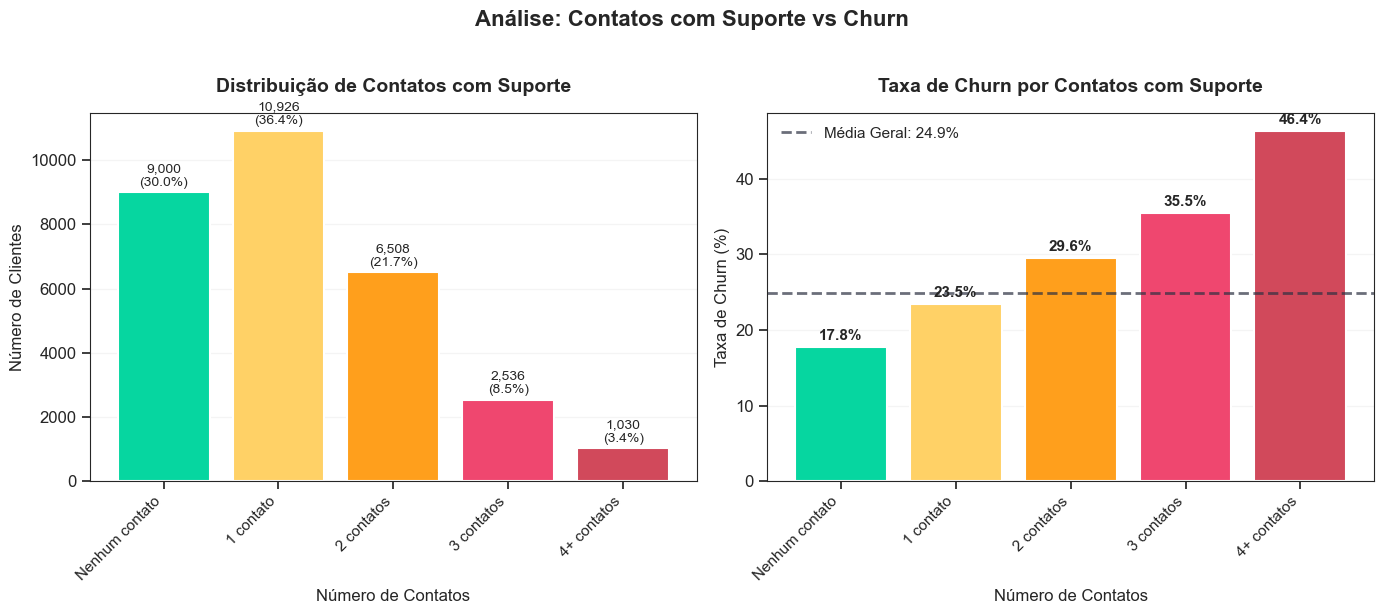

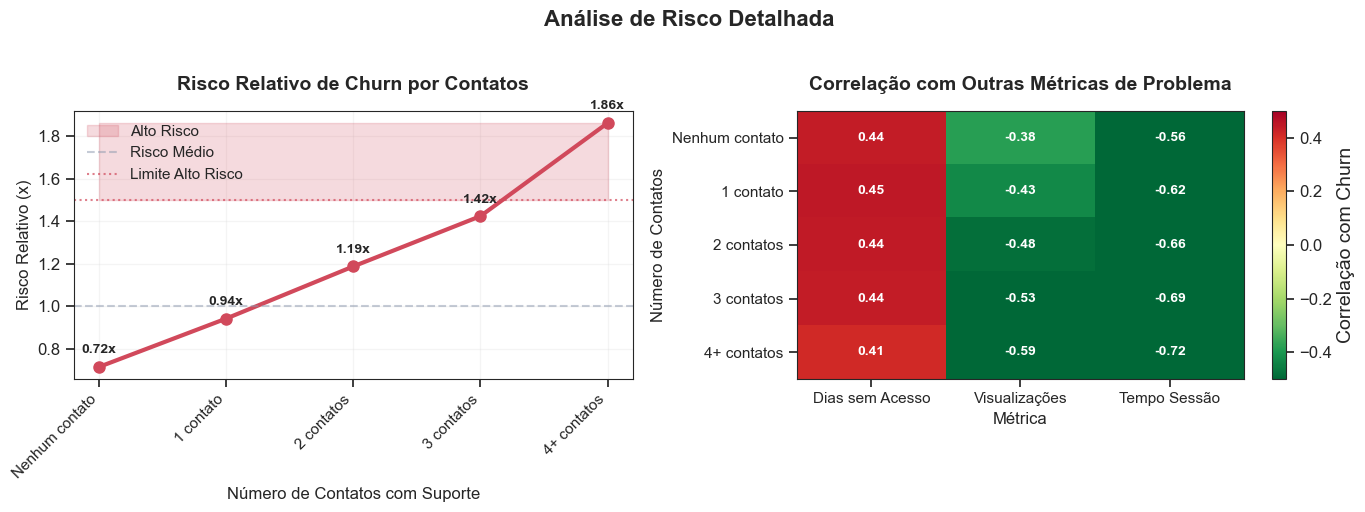

ANÁLISE: CONTATOS COM SUPORTE vs CHURN

📞 RESUMO GERAL:
• Clientes que nunca contataram suporte: 9,000 (30.0%)
• Clientes com 1+ contatos: 21,000 (70.0%)
• Média de contatos: 1.20
• Máximo de contatos: 7

📊 TAXA DE CHURN POR NÚMERO DE CONTATOS:

Nenhum contato:
  • Clientes: 9,000 (30.0%)
  • Taxa de churn: 17.8%
  • Risco relativo: 0.72x → 🟢 BAIXO RISCO

1 contato:
  • Clientes: 10,926 (36.4%)
  • Taxa de churn: 23.5%
  • Risco relativo: 0.94x → 🟢 RISCO NORMAL

2 contatos:
  • Clientes: 6,508 (21.7%)
  • Taxa de churn: 29.6%
  • Risco relativo: 1.19x → 🟢 RISCO NORMAL

3 contatos:
  • Clientes: 2,536 (8.5%)
  • Taxa de churn: 35.5%
  • Risco relativo: 1.42x → 🟡 RISCO ELEVADO

4+ contatos:
  • Clientes: 1,030 (3.4%)
  • Taxa de churn: 46.4%
  • Risco relativo: 1.86x → 🔴 ALTO RISCO

🎯 PONTOS CRÍTICOS DE RISCO:
⚠️  Aumento crítico: Nenhum contato → 1 contato
   Risco aumenta de 0.72x para 0.94x
   (+32% de risco)
⚠️  Aumento crítico: 3 contatos → 4+ contatos
   Risco aumenta de 1.42x para

In [34]:
# ============================================================================
# 4 ANÁLISE DE CONTATOS COM SUPORTE vs CHURN
# ============================================================================

# 1. PREPARAR OS DADOS
# Criar categorias baseadas no número de contatos com suporte
def categorizar_contatos_suporte(contatos):
    """Categoriza clientes baseado no número de contatos com suporte."""
    if contatos == 0:
        return 'Nenhum contato'
    elif contatos == 1:
        return '1 contato'
    elif contatos == 2:
        return '2 contatos'
    elif contatos == 3:
        return '3 contatos'
    else:  # 4 ou mais contatos
        return '4+ contatos'

# Aplicar categorização
df['categoria_contatos'] = df['contatos_suporte'].apply(categorizar_contatos_suporte)

# Ordem lógica das categorias
ordem_categorias = ['Nenhum contato', '1 contato', '2 contatos', '3 contatos', '4+ contatos']

# Criar paleta para categorias (gradiente de risco)
paleta_contatos = {
    'Nenhum contato': '#06D6A0',    # Verde - baixo risco
    '1 contato': '#FFD166',         # Amarelo - risco moderado
    '2 contatos': '#FF9F1C',        # Laranja - risco médio-alto
    '3 contatos': '#EF476F',        # Vermelho - alto risco
    '4+ contatos': '#D1495B'        # Vermelho escuro - risco muito alto
}

# 2. VISUALIZAÇÃO PRINCIPAL: DISTRIBUIÇÃO E TAXA DE CHURN
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# --- GRÁFICO 1: Distribuição de contatos com suporte ---
contatos_counts = df['categoria_contatos'].value_counts().reindex(ordem_categorias)

bars1 = ax1.bar(contatos_counts.index, contatos_counts.values, 
                color=[paleta_contatos[cat] for cat in contatos_counts.index],
                edgecolor='white', linewidth=1.5)

ax1.set_title('Distribuição de Contatos com Suporte', 
              fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('Número de Contatos', fontsize=12)
ax1.set_ylabel('Número de Clientes', fontsize=12)
ax1.set_xticklabels(contatos_counts.index, rotation=45, ha='right', fontsize=11)
ax1.grid(True, alpha=0.2, axis='y')

# Adicionar valores e porcentagens
for bar, count in zip(bars1, contatos_counts.values):
    percentage = (count / len(df)) * 100
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + max(contatos_counts.values)*0.01,
             f'{count:,}\n({percentage:.1f}%)', ha='center', va='bottom', fontsize=10)

# --- GRÁFICO 2: Taxa de churn por número de contatos ---
churn_por_contatos = df.groupby('categoria_contatos')['churn'].agg(['count', 'mean'])
churn_por_contatos = churn_por_contatos.reindex(ordem_categorias)
churn_por_contatos['mean'] = churn_por_contatos['mean'] * 100

bars2 = ax2.bar(churn_por_contatos.index, churn_por_contatos['mean'],
                color=[paleta_contatos[cat] for cat in churn_por_contatos.index],
                edgecolor='white', linewidth=1.5)

ax2.set_title('Taxa de Churn por Contatos com Suporte', 
              fontsize=14, fontweight='bold', pad=15)
ax2.set_xlabel('Número de Contatos', fontsize=12)
ax2.set_ylabel('Taxa de Churn (%)', fontsize=12)
ax2.set_xticklabels(churn_por_contatos.index, rotation=45, ha='right', fontsize=11)
ax2.grid(True, alpha=0.2, axis='y')

# Linha da média geral
media_geral = df['churn'].mean() * 100
ax2.axhline(y=media_geral, color=PALETA_CHURN['neutro_escuro'], 
            linestyle='--', linewidth=2, alpha=0.7,
            label=f'Média Geral: {media_geral:.1f}%')
ax2.legend(loc='upper left', fontsize=11)

# Adicionar valores nas barras
for bar, taxa in zip(bars2, churn_por_contatos['mean']):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
             f'{taxa:.1f}%', ha='center', va='bottom', 
             fontsize=11, fontweight='bold')

plt.suptitle('Análise: Contatos com Suporte vs Churn', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
fig.savefig('Grafico Análise Contatos com Suporte vs Churn', dpi=300)
plt.show()

# 3. VISUALIZAÇÃO ADICIONAL: ANÁLISE DE RISCO DETALHADA
fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(14, 5))

# --- GRÁFICO 3: Evolução do risco com mais contatos ---
# Calcular risco relativo
churn_por_contatos['risco_relativo'] = churn_por_contatos['mean'] / media_geral

# Gráfico de linha para mostrar evolução
ax3.plot(churn_por_contatos.index, churn_por_contatos['risco_relativo'], 
         'o-', color=PALETA_CHURN['risco_alto'], linewidth=3, markersize=8)

# Preencher área de alto risco (acima de 1.5x)
ax3.fill_between(churn_por_contatos.index, 1.5, churn_por_contatos['risco_relativo'].max(), 
                 alpha=0.2, color=PALETA_CHURN['risco_alto'], label='Alto Risco')

# Linhas de referência
ax3.axhline(y=1.0, color=PALETA_CHURN['neutro_medio'], linestyle='--', alpha=0.5, label='Risco Médio')
ax3.axhline(y=1.5, color=PALETA_CHURN['risco_alto'], linestyle=':', alpha=0.7, label='Limite Alto Risco')

ax3.set_title('Risco Relativo de Churn por Contatos', 
              fontsize=14, fontweight='bold', pad=15)
ax3.set_xlabel('Número de Contatos com Suporte', fontsize=12)
ax3.set_ylabel('Risco Relativo (x)', fontsize=12)
ax3.set_xticklabels(churn_por_contatos.index, rotation=45, ha='right', fontsize=11)
ax3.legend(loc='upper left', fontsize=11)
ax3.grid(True, alpha=0.2)

# Adicionar valores nos pontos
for i, (categoria, risco) in enumerate(zip(churn_por_contatos.index, churn_por_contatos['risco_relativo'])):
    ax3.text(i, risco + 0.05, f'{risco:.2f}x', ha='center', va='bottom', 
             fontsize=10, fontweight='bold')

# --- GRÁFICO 4: Motivos potenciais (correlação com outras métricas) ---
# Calcular correlação com outras métricas problemáticas
metricas_problema = ['dias_ultimo_acesso', 'visualizacoes_mes', 'tempo_medio_sessao_min']
correlacoes = []

for contatos_cat in ordem_categorias:
    dados_categoria = df[df['categoria_contatos'] == contatos_cat]
    correl_categoria = []
    for metrica in metricas_problema:
        correl = dados_categoria[metrica].corr(dados_categoria['churn'])
        correl_categoria.append(correl)
    correlacoes.append(correl_categoria)

# Criar heatmap simples
im = ax4.imshow(correlacoes, cmap='RdYlGn_r', aspect='auto', vmin=-0.5, vmax=0.5)

ax4.set_title('Correlação com Outras Métricas de Problema', 
              fontsize=14, fontweight='bold', pad=15)
ax4.set_xlabel('Métrica', fontsize=12)
ax4.set_ylabel('Número de Contatos', fontsize=12)
ax4.set_xticks(range(len(metricas_problema)))
ax4.set_xticklabels(['Dias sem Acesso', 'Visualizações', 'Tempo Sessão'], fontsize=11)
ax4.set_yticks(range(len(ordem_categorias)))
ax4.set_yticklabels(ordem_categorias, fontsize=11)

# Adicionar valores no heatmap
for i in range(len(ordem_categorias)):
    for j in range(len(metricas_problema)):
        ax4.text(j, i, f'{correlacoes[i][j]:.2f}', ha='center', va='center', 
                color='white' if abs(correlacoes[i][j]) > 0.25 else 'black',
                fontsize=10, fontweight='bold')

plt.colorbar(im, ax=ax4, label='Correlação com Churn')
plt.suptitle('Análise de Risco Detalhada', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
fig2.savefig('Grafico Análise de Risco Detalhada', dpi=300)
plt.show()

# 4. ANÁLISE ESTATÍSTICA DETALHADA
print("=" * 70)
print("ANÁLISE: CONTATOS COM SUPORTE vs CHURN")
print("=" * 70)

print(f"\n📞 RESUMO GERAL:")
print(f"• Clientes que nunca contataram suporte: {len(df[df['contatos_suporte'] == 0]):,} ({len(df[df['contatos_suporte'] == 0])/len(df)*100:.1f}%)")
print(f"• Clientes com 1+ contatos: {len(df[df['contatos_suporte'] > 0]):,} ({len(df[df['contatos_suporte'] > 0])/len(df)*100:.1f}%)")
print(f"• Média de contatos: {df['contatos_suporte'].mean():.2f}")
print(f"• Máximo de contatos: {df['contatos_suporte'].max()}")

print("\n" + "=" * 70)
print("📊 TAXA DE CHURN POR NÚMERO DE CONTATOS:")
print("=" * 70)

for categoria in ordem_categorias:
    dados = churn_por_contatos.loc[categoria]
    total = int(dados['count'])
    taxa = dados['mean']
    risco = dados['risco_relativo']
    
    if risco > 2.0:
        risco_label = "🔴 RISCO MUITO ALTO"
    elif risco > 1.5:
        risco_label = "🔴 ALTO RISCO"
    elif risco > 1.2:
        risco_label = "🟡 RISCO ELEVADO"
    elif risco > 0.8:
        risco_label = "🟢 RISCO NORMAL"
    else:
        risco_label = "🟢 BAIXO RISCO"
    
    print(f"\n{categoria}:")
    print(f"  • Clientes: {total:,} ({total/len(df)*100:.1f}%)")
    print(f"  • Taxa de churn: {taxa:.1f}%")
    print(f"  • Risco relativo: {risco:.2f}x → {risco_label}")

# Análise de tipping point
print("\n" + "=" * 70)
print("🎯 PONTOS CRÍTICOS DE RISCO:")
print("=" * 70)

# Encontrar onde o risco aumenta significativamente
for i in range(1, len(ordem_categorias)):
    risco_atual = churn_por_contatos['risco_relativo'].iloc[i]
    risco_anterior = churn_por_contatos['risco_relativo'].iloc[i-1]
    
    if risco_atual / risco_anterior > 1.3:  # Aumento de 30% ou mais
        print(f"⚠️  Aumento crítico: {ordem_categorias[i-1]} → {ordem_categorias[i]}")
        print(f"   Risco aumenta de {risco_anterior:.2f}x para {risco_atual:.2f}x")
        print(f"   (+{(risco_atual/risco_anterior - 1)*100:.0f}% de risco)")

# Clientes de alto risco
clientes_alto_risco = df[df['contatos_suporte'] >= 3]
if len(clientes_alto_risco) > 0:
    print(f"\n🔴 CLIENTES DE ALTO RISCO (3+ contatos):")
    print(f"   • Total: {len(clientes_alto_risco):,} clientes")
    print(f"   • Taxa de churn: {clientes_alto_risco['churn'].mean()*100:.1f}%")
    print(f"   • Representam {len(clientes_alto_risco['churn'][clientes_alto_risco['churn'] == 1]):,} dos casos de churn")
    print(f"   • % do total de churn: {len(clientes_alto_risco['churn'][clientes_alto_risco['churn'] == 1])/df['churn'].sum()*100:.1f}%")

print("\n" + "=" * 70)
print("💡 RECOMENDAÇÕES:")
print("=" * 70)
print("1. 🔴 Clientes com 3+ contatos: Intervenção imediata")
print("2. 🟡 Clientes com 2 contatos: Monitoramento ativo")
print("3. 🟢 Clientes com 0-1 contatos: Manutenção preventiva")
print("4. 📊 Implementar sistema de alerta para múltiplos contatos")
print("5. 🎯 Criar fluxo especial para clientes de alto risco")
print("=" * 70)

## 

###### ================================================
### `ANÁLISE DE AVALIAÇÕES E SATISFAÇÃO`
###### ================================================

ANÁLISE DE AVALIAÇÕES DE CONTEÚDO
📊 DISTRIBUIÇÃO DAS AVALIAÇÕES:
   • Avaliação média histórica: 18,223 respostas
   • Avaliação último mês: 12,403 respostas
   • Avaliação plataforma: 23,959 respostas

1. QUEDA NA AVALIAÇÃO (Histórica vs Último Mês)
Clientes com ambas avaliações (histórica + último mês): 6,982


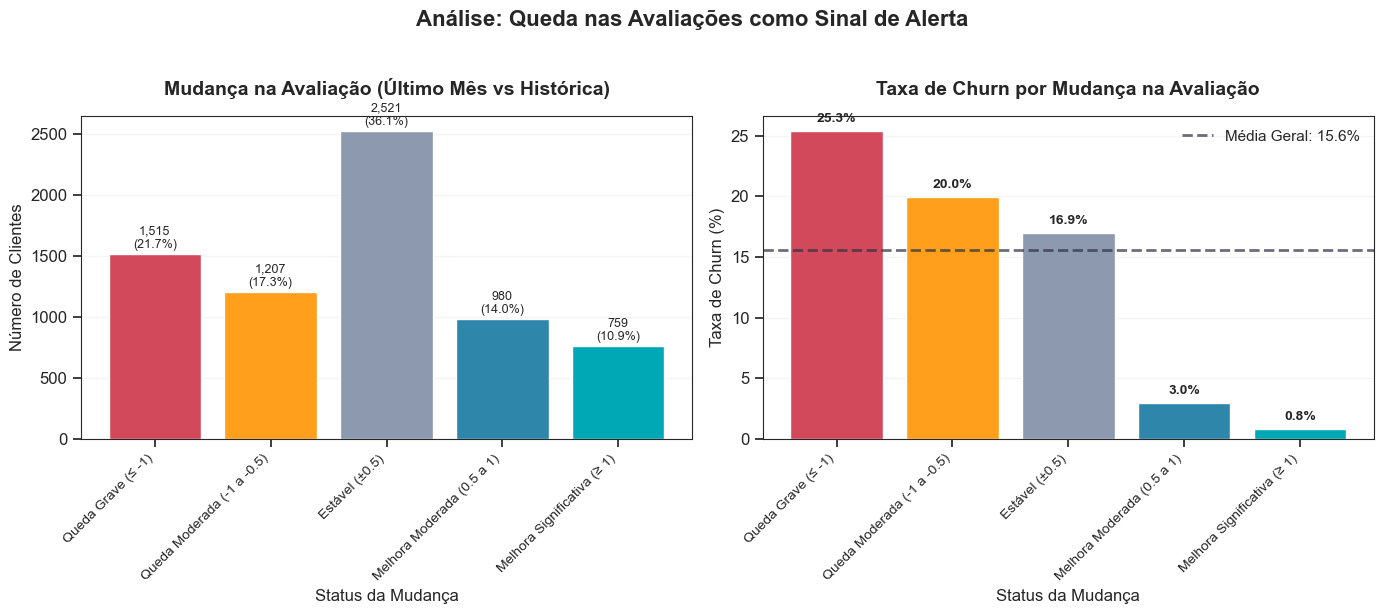


📈 ESTATÍSTICAS DA MUDANÇA DE AVALIAÇÃO:
   • Média da diferença: 0.11 pontos
   • % com queda (diferença < 0): 39.0%
   • % com melhora (diferença > 0): 42.3%

⚠️  RISCO POR CATEGORIA DE MUDANÇA:
   • Queda Grave (≤ -1): 25.3% churn (+9.8pts) 🟠 RISCO ELEVADO
   • Queda Moderada (-1 a -0.5): 20.0% churn (+4.4pts) 🟡 RISCO MODERADO
   • Estável (±0.5): 16.9% churn (+1.4pts) 🟡 RISCO MODERADO
   • Melhora Moderada (0.5 a 1): 3.0% churn (-12.6pts) 🟢 BAIXO RISCO
   • Melhora Significativa (≥ 1): 0.8% churn (-14.8pts) 🟢 BAIXO RISCO

2. CLIENTES QUE NUNCA AVALIARAM
📊 DISTRIBUIÇÃO DE AVALIADORES:
   • Clientes que NUNCA avaliaram: 1,203 (4.0%)
   • Clientes que avaliaram ≥1 vez: 28,797 (96.0%)


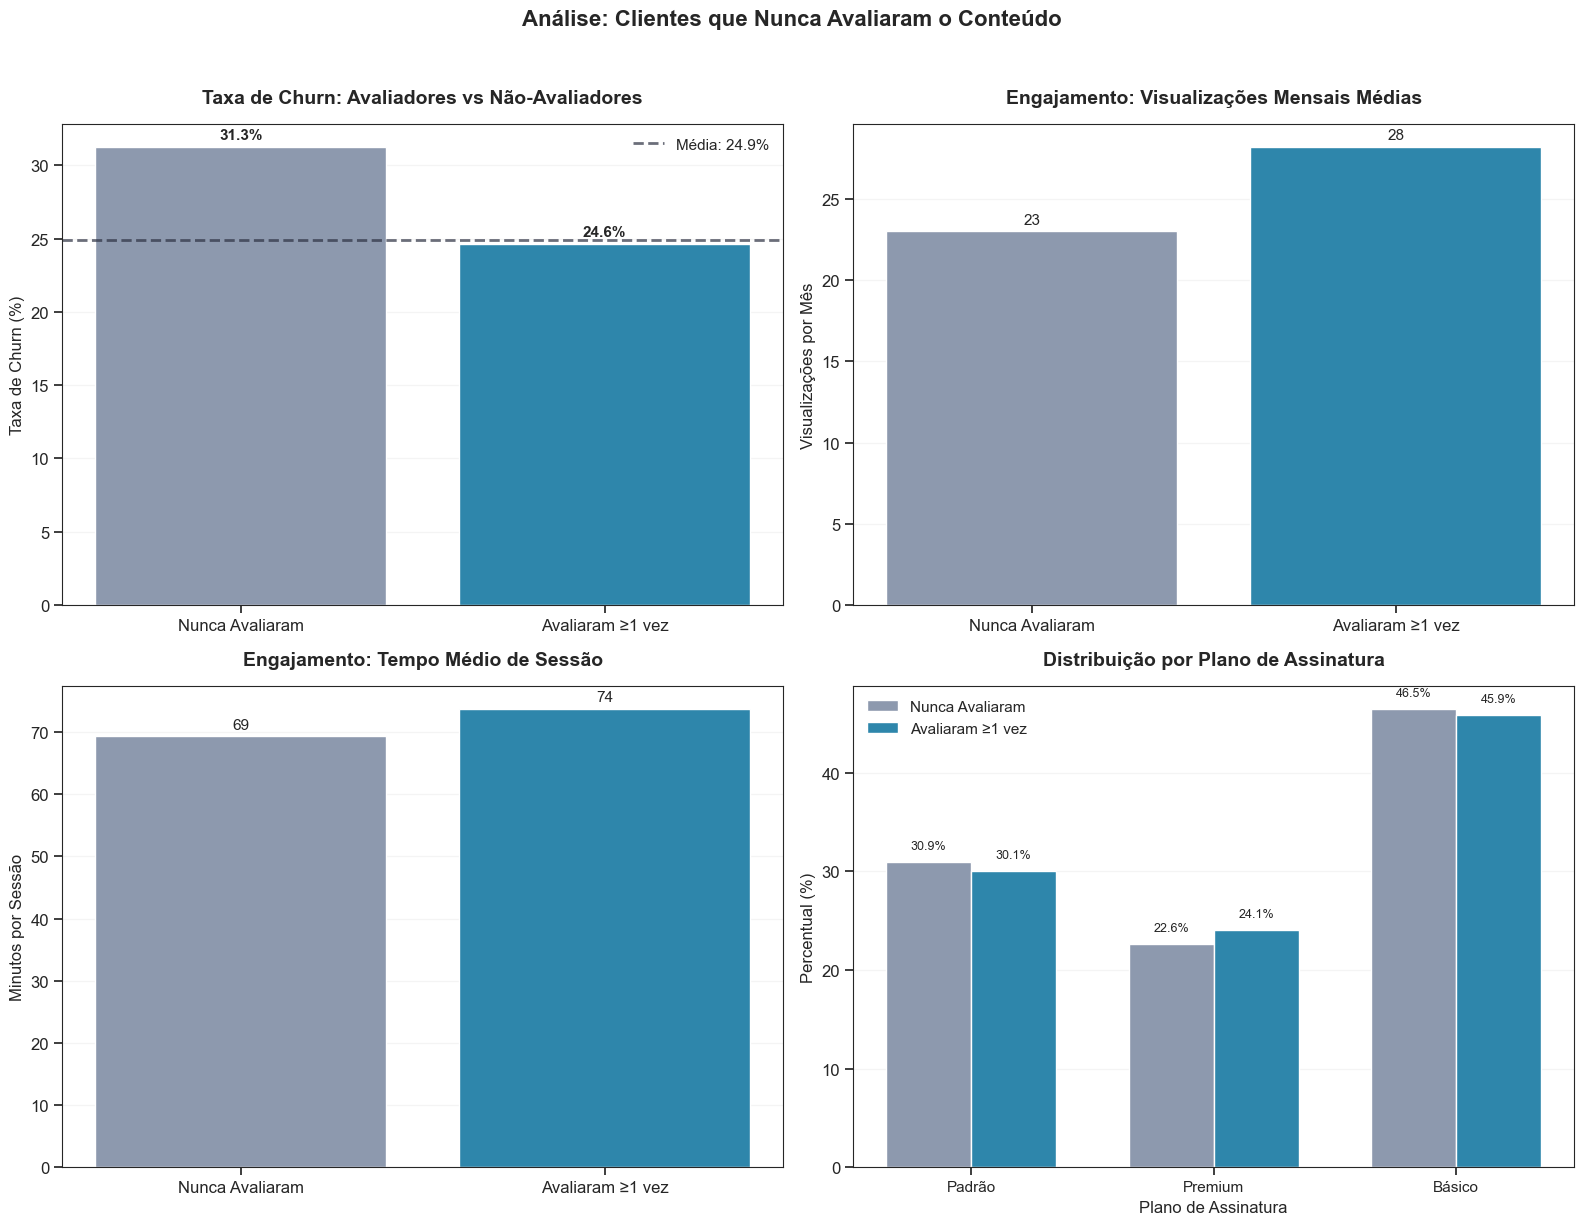


📊 COMPARAÇÃO DE ENGAJAMENTO:
   • Diferença em visualizações: +5 por mês
   • Diferença em tempo de sessão: +4 minutos
   • Diferença em churn: +6.6 pontos

📋 DISTRIBUIÇÃO POR PLANO:
   • Padrão: 30.9% nunca avaliaram vs 30.1% avaliaram
   • Premium: 22.6% nunca avaliaram vs 24.1% avaliaram
   • Básico: 46.5% nunca avaliaram vs 45.9% avaliaram

3. ANÁLISE COMBINADA: TODAS AS CATEGORIAS

📊 TAXA DE CHURN POR CATEGORIA DE AVALIAÇÃO:
   • Apenas avaliação histórica     →  34.0% (+9.1pts) | 11,241.0 clientes
   • Nunca avaliou                  →  31.3% (+6.3pts) | 1,203.0 clientes
   • Sem dados suficientes          →  28.0% (+3.1pts) | 5,153.0 clientes
   • Queda na avaliação             →  25.3% (+0.4pts) | 1,515.0 clientes
   • Apenas avaliação recente       →  13.6% (-11.3pts) | 5,421.0 clientes
   • Estável/Melhorou               →  12.9% (-12.0pts) | 5,467.0 clientes


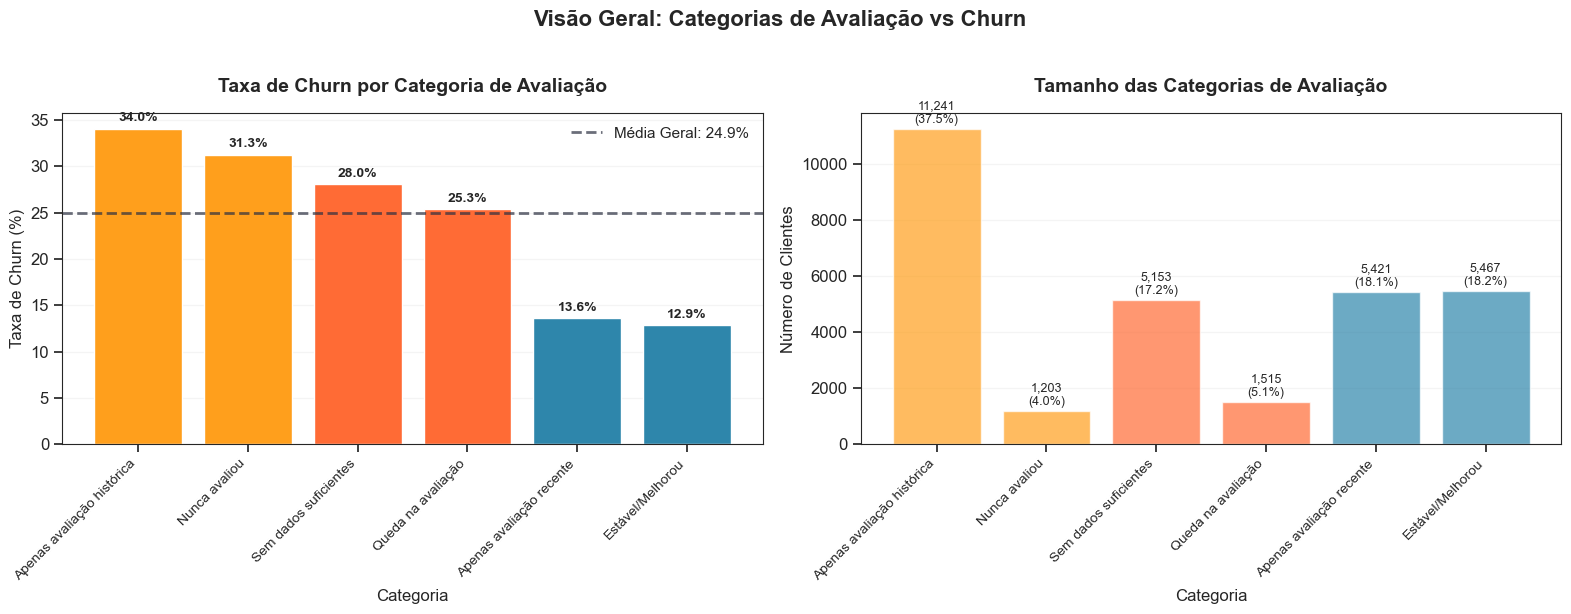


4. RECOMENDAÇÕES BASEADAS NA ANÁLISE

🎯 PRIORIDADE MÁXIMA: 'Apenas avaliação histórica'
   • Taxa de churn: 34.0% (+9.1pts vs média)
   • Clientes em risco: 11,241

📝 AÇÕES RECOMENDADAS POR CATEGORIA:

• Apenas avaliação histórica:
   1. Solicitar avaliação recente
   2. Lembrar que avaliações ajudam a personalizar recomendações
   3. Oferecer incentivo para avaliar conteúdo recente

• Nunca avaliou:
   1. Incentivos para participação (sorteios, benefícios)
   2. Simplificar processo de avaliação (1-clique)
   3. Comunicar importância do feedback para melhorias
   4. Lembretes periódicos sobre avaliação

• Queda na avaliação:
   1. Contato proativo para entender insatisfação
   2. Oferta de conteúdo personalizado baseado no histórico
   3. Pesquisa detalhada sobre experiência recente
   4. Possível upgrade gratuito por tempo limitado

• Apenas avaliação recente:
   1. Solicitar avaliação histórica para comparação
   2. Oferecer guia de como avaliar conteúdo
   3. Destacar benefícios d

In [35]:
# ============================================================================
# 1 ANÁLISE DE AVALIAÇÕES DE CONTEÚDO 
# ============================================================================

# 1. PRÉ-PROCESSAMENTO DAS AVALIAÇÕES
print("=" * 70)
print("ANÁLISE DE AVALIAÇÕES DE CONTEÚDO")
print("=" * 70)

# Criar cópia do DataFrame para não modificar o original
df_analise = df.copy()

# Converter avaliações de string (com vírgula) para float
df_analise['avaliacao_conteudo_media_num'] = pd.to_numeric(
    df_analise['avaliacao_conteudo_media'].str.replace(',', '.'), errors='coerce'
)
df_analise['avaliacao_conteudo_ultimo_mes_num'] = pd.to_numeric(
    df_analise['avaliacao_conteudo_ultimo_mes'].str.replace(',', '.'), errors='coerce'
)
df_analise['avaliacao_plataforma_num'] = pd.to_numeric(
    df_analise['avaliacao_plataforma'].str.replace(',', '.'), errors='coerce'
)

# Verificar disponibilidade dos dados
print(f"📊 DISTRIBUIÇÃO DAS AVALIAÇÕES:")
print(f"   • Avaliação média histórica: {df_analise['avaliacao_conteudo_media_num'].notna().sum():,} respostas")
print(f"   • Avaliação último mês: {df_analise['avaliacao_conteudo_ultimo_mes_num'].notna().sum():,} respostas")
print(f"   • Avaliação plataforma: {df_analise['avaliacao_plataforma_num'].notna().sum():,} respostas")

# 2. ANÁLISE 1: QUEDA NA AVALIAÇÃO (histórica vs último mês)
print("\n" + "=" * 70)
print("1. QUEDA NA AVALIAÇÃO (Histórica vs Último Mês)")
print("=" * 70)

# Filtrar clientes que têm ambas as avaliações
mask_avaliacoes_completas = (
    df_analise['avaliacao_conteudo_media_num'].notna() & 
    df_analise['avaliacao_conteudo_ultimo_mes_num'].notna()
)

df_com_avaliacoes = df_analise[mask_avaliacoes_completas].copy()
print(f"Clientes com ambas avaliações (histórica + último mês): {len(df_com_avaliacoes):,}")

if len(df_com_avaliacoes) > 0:
    # Calcular diferença
    df_com_avaliacoes['diff_avaliacao'] = (
        df_com_avaliacoes['avaliacao_conteudo_ultimo_mes_num'] - 
        df_com_avaliacoes['avaliacao_conteudo_media_num']
    )
    
    # Adicionar diferença ao DataFrame principal para análise posterior
    df_analise.loc[mask_avaliacoes_completas, 'diff_avaliacao'] = df_com_avaliacoes['diff_avaliacao']
    
    # Classificar clientes
    df_com_avaliacoes['status_avaliacao'] = pd.cut(
        df_com_avaliacoes['diff_avaliacao'],
        bins=[-float('inf'), -1, -0.5, 0.5, 1, float('inf')],
        labels=['Queda Grave (≤ -1)', 'Queda Moderada (-1 a -0.5)', 'Estável (±0.5)', 
                'Melhora Moderada (0.5 a 1)', 'Melhora Significativa (≥ 1)']
    )
    
    # Adicionar classificação ao DataFrame principal
    df_analise.loc[mask_avaliacoes_completas, 'status_avaliacao'] = df_com_avaliacoes['status_avaliacao']
    
    # 3. VISUALIZAÇÃO DA ANÁLISE 1
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Subplot 1: Distribuição das mudanças de avaliação
    status_counts = df_com_avaliacoes['status_avaliacao'].value_counts().sort_index()
    cores_status = [PALETA_CHURN['risco_alto'], PALETA_CHURN['risco_medio'], 
                    PALETA_CHURN['neutro_medio'], PALETA_CHURN['ativo'], PALETA_CHURN['novo_cliente']]
    
    bars1 = ax1.bar(range(len(status_counts)), status_counts.values, color=cores_status)
    
    ax1.set_title('Mudança na Avaliação (Último Mês vs Histórica)', 
                  fontsize=14, fontweight='bold', pad=15)
    ax1.set_xlabel('Status da Mudança', fontsize=12)
    ax1.set_ylabel('Número de Clientes', fontsize=12)
    ax1.set_xticks(range(len(status_counts)))
    ax1.set_xticklabels(status_counts.index, rotation=45, ha='right', fontsize=10)
    ax1.grid(True, alpha=0.2, axis='y')
    
    # Adicionar valores
    for bar, count in zip(bars1, status_counts.values):
        porcentagem = (count / len(df_com_avaliacoes)) * 100
        ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + max(status_counts.values)*0.01,
                 f'{count:,}\n({porcentagem:.1f}%)', ha='center', va='bottom', fontsize=9)
    
    # Subplot 2: Taxa de churn por status de avaliação
    churn_por_status = df_com_avaliacoes.groupby('status_avaliacao')['churn'].agg(['count', 'mean'])
    churn_por_status['taxa_churn'] = churn_por_status['mean'] * 100
    churn_por_status = churn_por_status.reindex(status_counts.index)
    
    bars2 = ax2.bar(range(len(churn_por_status)), churn_por_status['taxa_churn'], color=cores_status)
    
    ax2.set_title('Taxa de Churn por Mudança na Avaliação', 
                  fontsize=14, fontweight='bold', pad=15)
    ax2.set_xlabel('Status da Mudança', fontsize=12)
    ax2.set_ylabel('Taxa de Churn (%)', fontsize=12)
    ax2.set_xticks(range(len(churn_por_status)))
    ax2.set_xticklabels(churn_por_status.index, rotation=45, ha='right', fontsize=10)
    ax2.grid(True, alpha=0.2, axis='y')
    
    # Linha da média geral no subset
    media_geral_subset = df_com_avaliacoes['churn'].mean() * 100
    ax2.axhline(y=media_geral_subset, color=PALETA_CHURN['neutro_escuro'], 
                linestyle='--', linewidth=2, alpha=0.7,
                label=f'Média Geral: {media_geral_subset:.1f}%')
    ax2.legend(loc='upper right', fontsize=11)
    
    # Adicionar valores
    for bar, taxa in zip(bars2, churn_por_status['taxa_churn']):
        ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
                 f'{taxa:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.suptitle('Análise: Queda nas Avaliações como Sinal de Alerta', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    fig.savefig('Grafico Análise Queda nas Avaliações como Sinal de Alerta', dpi=300)
    plt.show()
    
    # Estatísticas da análise 1
    print(f"\n📈 ESTATÍSTICAS DA MUDANÇA DE AVALIAÇÃO:")
    print(f"   • Média da diferença: {df_com_avaliacoes['diff_avaliacao'].mean():.2f} pontos")
    print(f"   • % com queda (diferença < 0): {(df_com_avaliacoes['diff_avaliacao'] < 0).mean()*100:.1f}%")
    print(f"   • % com melhora (diferença > 0): {(df_com_avaliacoes['diff_avaliacao'] > 0).mean()*100:.1f}%")
    
    # Análise de risco por categoria
    print(f"\n⚠️  RISCO POR CATEGORIA DE MUDANÇA:")
    for status in status_counts.index:
        dados_status = churn_por_status.loc[status]
        taxa_churn_status = dados_status['taxa_churn']
        diff_vs_media = taxa_churn_status - media_geral_subset
        sinal = "+" if diff_vs_media > 0 else ""
        
        if diff_vs_media > 10:
            risco = "🔴 ALTO RISCO"
        elif diff_vs_media > 5:
            risco = "🟠 RISCO ELEVADO"
        elif diff_vs_media > 0:
            risco = "🟡 RISCO MODERADO"
        else:
            risco = "🟢 BAIXO RISCO"
        
        print(f"   • {status}: {taxa_churn_status:.1f}% churn ({sinal}{diff_vs_media:.1f}pts) {risco}")

else:
    print("⚠️  Dados insuficientes para análise de mudança de avaliação.")

# 4. ANÁLISE 2: CLIENTES QUE NUNCA AVALIARAM
print("\n" + "=" * 70)
print("2. CLIENTES QUE NUNCA AVALIARAM")
print("=" * 70)

# Identificar clientes que nunca avaliaram (todas avaliações nulas)
df_analise['nunca_avaliou'] = (
    df_analise['avaliacao_conteudo_media_num'].isna() & 
    df_analise['avaliacao_conteudo_ultimo_mes_num'].isna() & 
    df_analise['avaliacao_plataforma_num'].isna()
)

clientes_sem_avaliacao = df_analise[df_analise['nunca_avaliou']]
clientes_com_avaliacao = df_analise[~df_analise['nunca_avaliou']]

print(f"📊 DISTRIBUIÇÃO DE AVALIADORES:")
print(f"   • Clientes que NUNCA avaliaram: {len(clientes_sem_avaliacao):,} ({len(clientes_sem_avaliacao)/len(df_analise)*100:.1f}%)")
print(f"   • Clientes que avaliaram ≥1 vez: {len(clientes_com_avaliacao):,} ({len(clientes_com_avaliacao)/len(df_analise)*100:.1f}%)")

# 5. VISUALIZAÇÃO DA ANÁLISE 2
if len(clientes_sem_avaliacao) > 0 and len(clientes_com_avaliacao) > 0:
    fig2, ((ax3, ax4), (ax5, ax6)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Subplot 1: Taxa de churn comparativa
    categorias = ['Nunca Avaliaram', 'Avaliaram ≥1 vez']
    churn_nunca = clientes_sem_avaliacao['churn'].mean() * 100
    churn_com = clientes_com_avaliacao['churn'].mean() * 100
    
    bars3 = ax3.bar(categorias, [churn_nunca, churn_com], 
                    color=[PALETA_CHURN['neutro_medio'], PALETA_CHURN['ativo']])
    
    ax3.set_title('Taxa de Churn: Avaliadores vs Não-Avaliadores', 
                  fontsize=14, fontweight='bold', pad=15)
    ax3.set_ylabel('Taxa de Churn (%)', fontsize=12)
    ax3.grid(True, alpha=0.2, axis='y')
    
    # Adicionar valores
    for bar, taxa in zip(bars3, [churn_nunca, churn_com]):
        ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.3,
                 f'{taxa:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Linha da média geral
    media_geral = df_analise['churn'].mean() * 100
    ax3.axhline(y=media_geral, color=PALETA_CHURN['neutro_escuro'], 
                linestyle='--', linewidth=2, alpha=0.7, label=f'Média: {media_geral:.1f}%')
    ax3.legend(fontsize=11)
    
    # Subplot 2: Engajamento comparativo (visualizações)
    media_viz_nunca = clientes_sem_avaliacao['visualizacoes_mes'].mean()
    media_viz_com = clientes_com_avaliacao['visualizacoes_mes'].mean()
    
    bars4 = ax4.bar(categorias, [media_viz_nunca, media_viz_com],
                    color=[PALETA_CHURN['neutro_medio'], PALETA_CHURN['ativo']])
    
    ax4.set_title('Engajamento: Visualizações Mensais Médias', 
                  fontsize=14, fontweight='bold', pad=15)
    ax4.set_ylabel('Visualizações por Mês', fontsize=12)
    ax4.grid(True, alpha=0.2, axis='y')
    
    # Adicionar valores
    for bar, valor in zip(bars4, [media_viz_nunca, media_viz_com]):
        ax4.text(bar.get_x() + bar.get_width()/2., bar.get_height() + max(media_viz_nunca, media_viz_com)*0.01,
                 f'{valor:.0f}', ha='center', va='bottom', fontsize=11)
    
    # Subplot 3: Tempo de sessão comparativo
    media_sessao_nunca = clientes_sem_avaliacao['tempo_medio_sessao_min'].mean()
    media_sessao_com = clientes_com_avaliacao['tempo_medio_sessao_min'].mean()
    
    bars5 = ax5.bar(categorias, [media_sessao_nunca, media_sessao_com],
                    color=[PALETA_CHURN['neutro_medio'], PALETA_CHURN['ativo']])
    
    ax5.set_title('Engajamento: Tempo Médio de Sessão', 
                  fontsize=14, fontweight='bold', pad=15)
    ax5.set_ylabel('Minutos por Sessão', fontsize=12)
    ax5.grid(True, alpha=0.2, axis='y')
    
    # Adicionar valores
    for bar, valor in zip(bars5, [media_sessao_nunca, media_sessao_com]):
        ax5.text(bar.get_x() + bar.get_width()/2., bar.get_height() + max(media_sessao_nunca, media_sessao_com)*0.01,
                 f'{valor:.0f}', ha='center', va='bottom', fontsize=11)
    
    # Subplot 4: Distribuição por plano de assinatura
    # Agrupar por plano
    plano_nunca = clientes_sem_avaliacao['plano_assinatura'].value_counts(normalize=True) * 100
    plano_com = clientes_com_avaliacao['plano_assinatura'].value_counts(normalize=True) * 100
    
    # Garantir mesma ordem
    planos_ordem = df_analise['plano_assinatura'].unique()
    plano_nunca = plano_nunca.reindex(planos_ordem, fill_value=0)
    plano_com = plano_com.reindex(planos_ordem, fill_value=0)
    
    x = np.arange(len(planos_ordem))
    largura = 0.35
    
    bars_nunca = ax6.bar(x - largura/2, plano_nunca.values, largura, 
                         label='Nunca Avaliaram', color=PALETA_CHURN['neutro_medio'])
    bars_com = ax6.bar(x + largura/2, plano_com.values, largura, 
                       label='Avaliaram ≥1 vez', color=PALETA_CHURN['ativo'])
    
    ax6.set_title('Distribuição por Plano de Assinatura', 
                  fontsize=14, fontweight='bold', pad=15)
    ax6.set_xlabel('Plano de Assinatura', fontsize=12)
    ax6.set_ylabel('Percentual (%)', fontsize=12)
    ax6.set_xticks(x)
    ax6.set_xticklabels(planos_ordem, fontsize=11)
    ax6.legend(fontsize=11)
    ax6.grid(True, alpha=0.2, axis='y')
    
    # Adicionar valores
    for bars in [bars_nunca, bars_com]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax6.text(bar.get_x() + bar.get_width()/2., height + 1,
                         f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
    
    plt.suptitle('Análise: Clientes que Nunca Avaliaram o Conteúdo', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    fig2.savefig('Grafico Análise Clientes que Nunca Avaliaram o Conteúdo', dpi=300)
    plt.show()
    
    # Estatísticas da análise 2
    print(f"\n📊 COMPARAÇÃO DE ENGAJAMENTO:")
    print(f"   • Diferença em visualizações: {media_viz_com - media_viz_nunca:+.0f} por mês")
    print(f"   • Diferença em tempo de sessão: {media_sessao_com - media_sessao_nunca:+.0f} minutos")
    print(f"   • Diferença em churn: {churn_nunca - churn_com:+.1f} pontos")
    
    # Análise por plano
    print(f"\n📋 DISTRIBUIÇÃO POR PLANO:")
    for plano in planos_ordem:
        perc_nunca = plano_nunca.get(plano, 0)
        perc_com = plano_com.get(plano, 0)
        print(f"   • {plano}: {perc_nunca:.1f}% nunca avaliaram vs {perc_com:.1f}% avaliaram")

# 6. ANÁLISE COMBINADA: TODAS AS CATEGORIAS DE AVALIAÇÃO
print("\n" + "=" * 70)
print("3. ANÁLISE COMBINADA: TODAS AS CATEGORIAS")
print("=" * 70)

# Criar categorias combinadas para todos os clientes
df_analise['categoria_avaliacao_completa'] = 'Sem dados suficientes'

# Categoria 1: Nunca avaliou
df_analise.loc[df_analise['nunca_avaliou'], 'categoria_avaliacao_completa'] = 'Nunca avaliou'

# Categoria 2: Tem avaliações completas
if 'status_avaliacao' in df_analise.columns:
    # Para quem tem avaliações e teve queda
    mask_tem_avaliacoes = df_analise['avaliacao_conteudo_media_num'].notna() & df_analise['avaliacao_conteudo_ultimo_mes_num'].notna()
    mask_queda = mask_tem_avaliacoes & (df_analise['diff_avaliacao'] < -0.5)
    df_analise.loc[mask_queda, 'categoria_avaliacao_completa'] = 'Queda na avaliação'
    
    # Para quem tem avaliações e está estável/melhorou
    mask_estavel_melhorou = mask_tem_avaliacoes & (df_analise['diff_avaliacao'] >= -0.5)
    df_analise.loc[mask_estavel_melhorou, 'categoria_avaliacao_completa'] = 'Estável/Melhorou'

# Categoria 3: Tem apenas avaliação histórica (não tem última)
mask_apenas_historica = df_analise['avaliacao_conteudo_media_num'].notna() & df_analise['avaliacao_conteudo_ultimo_mes_num'].isna()
df_analise.loc[mask_apenas_historica, 'categoria_avaliacao_completa'] = 'Apenas avaliação histórica'

# Categoria 4: Tem apenas avaliação recente (não tem histórica)
mask_apenas_recente = df_analise['avaliacao_conteudo_media_num'].isna() & df_analise['avaliacao_conteudo_ultimo_mes_num'].notna()
df_analise.loc[mask_apenas_recente, 'categoria_avaliacao_completa'] = 'Apenas avaliação recente'

# Calcular taxas de churn por categoria
churn_categorias = df_analise.groupby('categoria_avaliacao_completa')['churn'].agg(['count', 'mean'])
churn_categorias['taxa_churn'] = churn_categorias['mean'] * 100
churn_categorias = churn_categorias.sort_values('taxa_churn', ascending=False)

print(f"\n📊 TAXA DE CHURN POR CATEGORIA DE AVALIAÇÃO:")
for categoria, dados in churn_categorias.iterrows():
    diff_vs_media = dados['taxa_churn'] - media_geral
    sinal = "+" if diff_vs_media > 0 else ""
    print(f"   • {categoria:<30} → {dados['taxa_churn']:5.1f}% ({sinal}{diff_vs_media:.1f}pts) | {dados['count']:>6,} clientes")

# 7. VISUALIZAÇÃO DA ANÁLISE COMBINADA
fig3, (ax7, ax8) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Taxa de churn por categoria
categorias_ordem = churn_categorias.index.tolist()
taxas_churn = churn_categorias['taxa_churn'].values
contagens = churn_categorias['count'].values

# Definir cores baseado no risco
cores_categorias = []
for taxa in taxas_churn:
    if taxa > media_geral + 10:
        cores_categorias.append(PALETA_CHURN['risco_alto'])
    elif taxa > media_geral + 5:
        cores_categorias.append(PALETA_CHURN['risco_medio'])
    elif taxa > media_geral:
        cores_categorias.append(PALETA_CHURN['churn'])
    else:
        cores_categorias.append(PALETA_CHURN['ativo'])

bars7 = ax7.bar(range(len(categorias_ordem)), taxas_churn, color=cores_categorias)

ax7.set_title('Taxa de Churn por Categoria de Avaliação', 
              fontsize=14, fontweight='bold', pad=15)
ax7.set_xlabel('Categoria', fontsize=12)
ax7.set_ylabel('Taxa de Churn (%)', fontsize=12)
ax7.set_xticks(range(len(categorias_ordem)))
ax7.set_xticklabels(categorias_ordem, rotation=45, ha='right', fontsize=10)
ax7.grid(True, alpha=0.2, axis='y')

# Linha da média geral
ax7.axhline(y=media_geral, color=PALETA_CHURN['neutro_escuro'], 
            linestyle='--', linewidth=2, alpha=0.7,
            label=f'Média Geral: {media_geral:.1f}%')
ax7.legend(loc='upper right', fontsize=11)

# Adicionar valores
for bar, taxa in zip(bars7, taxas_churn):
    ax7.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
             f'{taxa:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Gráfico 2: Tamanho das categorias
bars8 = ax8.bar(range(len(categorias_ordem)), contagens, color=cores_categorias, alpha=0.7)

ax8.set_title('Tamanho das Categorias de Avaliação', 
              fontsize=14, fontweight='bold', pad=15)
ax8.set_xlabel('Categoria', fontsize=12)
ax8.set_ylabel('Número de Clientes', fontsize=12)
ax8.set_xticks(range(len(categorias_ordem)))
ax8.set_xticklabels(categorias_ordem, rotation=45, ha='right', fontsize=10)
ax8.grid(True, alpha=0.2, axis='y')

# Adicionar valores
for bar, count in zip(bars8, contagens):
    porcentagem = (count / len(df_analise)) * 100
    ax8.text(bar.get_x() + bar.get_width()/2., bar.get_height() + max(contagens)*0.01,
             f'{count:,}\n({porcentagem:.1f}%)', ha='center', va='bottom', fontsize=9)

plt.suptitle('Visão Geral: Categorias de Avaliação vs Churn', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
fig3.savefig('Grafico Visão Geral Categorias de Avaliação vs Churn', dpi=300)
plt.show()

# 8. RECOMENDAÇÕES ESTRATÉGICAS
print("\n" + "=" * 70)
print("4. RECOMENDAÇÕES BASEADAS NA ANÁLISE")
print("=" * 70)

# Identificar o maior risco
categoria_maior_risco = churn_categorias['taxa_churn'].idxmax()
taxa_maior_risco = churn_categorias.loc[categoria_maior_risco, 'taxa_churn']
clientes_maior_risco = churn_categorias.loc[categoria_maior_risco, 'count']

print(f"\n🎯 PRIORIDADE MÁXIMA: '{categoria_maior_risco}'")
print(f"   • Taxa de churn: {taxa_maior_risco:.1f}% (+{taxa_maior_risco - media_geral:.1f}pts vs média)")
print(f"   • Clientes em risco: {clientes_maior_risco:,}")

print(f"\n📝 AÇÕES RECOMENDADAS POR CATEGORIA:")

acoes_por_categoria = {
    'Queda na avaliação': [
        "Contato proativo para entender insatisfação",
        "Oferta de conteúdo personalizado baseado no histórico",
        "Pesquisa detalhada sobre experiência recente",
        "Possível upgrade gratuito por tempo limitado"
    ],
    'Nunca avaliou': [
        "Incentivos para participação (sorteios, benefícios)",
        "Simplificar processo de avaliação (1-clique)",
        "Comunicar importância do feedback para melhorias",
        "Lembretes periódicos sobre avaliação"
    ],
    'Apenas avaliação recente': [
        "Solicitar avaliação histórica para comparação",
        "Oferecer guia de como avaliar conteúdo",
        "Destacar benefícios de avaliar regularmente"
    ],
    'Apenas avaliação histórica': [
        "Solicitar avaliação recente",
        "Lembrar que avaliações ajudam a personalizar recomendações",
        "Oferecer incentivo para avaliar conteúdo recente"
    ],
    'Estável/Melhorou': [
        "Agradecer pelo feedback constante",
        "Oferecer conteúdo exclusivo como recompensa",
        "Solicitar indicação para outros potenciais clientes"
    ]
}

for categoria in categorias_ordem:
    if categoria in acoes_por_categoria:
        print(f"\n• {categoria}:")
        for i, acao in enumerate(acoes_por_categoria[categoria], 1):
            print(f"   {i}. {acao}")

print("\n" + "=" * 70)
print("5. RESUMO EXECUTIVO")
print("=" * 70)

# Resumo estatístico final
print(f"\n📈 ESTATÍSTICAS GERAIS:")
print(f"   • Total de clientes analisados: {len(df_analise):,}")
print(f"   • Taxa média de churn: {media_geral:.1f}%")
print(f"   • Clientes que nunca avaliaram: {len(clientes_sem_avaliacao):,} ({len(clientes_sem_avaliacao)/len(df_analise)*100:.1f}%)")

if 'diff_avaliacao' in df_analise.columns and df_analise['diff_avaliacao'].notna().sum() > 0:
    media_diff = df_analise['diff_avaliacao'].mean()
    print(f"   • Mudança média na avaliação: {media_diff:.2f} pontos")
    
    if media_diff < 0:
        print(f"   • Tendência geral: Queda nas avaliações recentes")
    elif media_diff > 0:
        print(f"   • Tendência geral: Melhora nas avaliações recentes")
    else:
        print(f"   • Tendência geral: Estabilidade nas avaliações")

print(f"\n🎯 OPORTUNIDADES DE REDUÇÃO DE CHURN:")
print(f"   • Categoria de maior risco: {categoria_maior_risco}")
print(f"   • Potencial redução: {taxa_maior_risco - media_geral:.1f} pontos percentuais")
print(f"   • Clientes impactáveis: {clientes_maior_risco:,}")

print(f"\n🚀 PRÓXIMOS PASSOS:")
print(f"   1. Implementar ações específicas para '{categoria_maior_risco}'")
print(f"   2. Criar sistema de alerta para quedas significativas")
print(f"   3. Aumentar taxa de avaliação com campanhas específicas")
print(f"   4. Monitorar impacto das ações mensalmente")

print("=" * 70)

PRÉ-PROCESSAMENTO: AVALIAÇÃO DA PLATAFORMA
Total de avaliações de plataforma disponíveis: 23,959
Média de avaliação: 2.99
Avaliação mais comum (moda): 3.5

ANÁLISE 1: RELAÇÃO DIRETA - AVALIAÇÃO vs CHURN

📊 TAXA DE CHURN POR CATEGORIA DE AVALIAÇÃO:
   • Muito Alta (4.5-5)   →  25.8% churn | 2,589 clientes
   • Média (2.5-3.5)      →  25.2% churn | 5,368 clientes
   • Alta (3.5-4.5)       →  25.2% churn | 5,318 clientes
   • Baixa (1.5-2.5)      →  25.0% churn | 5,306 clientes
   • Muito Baixa (0-1.5)  →  23.9% churn | 5,378 clientes


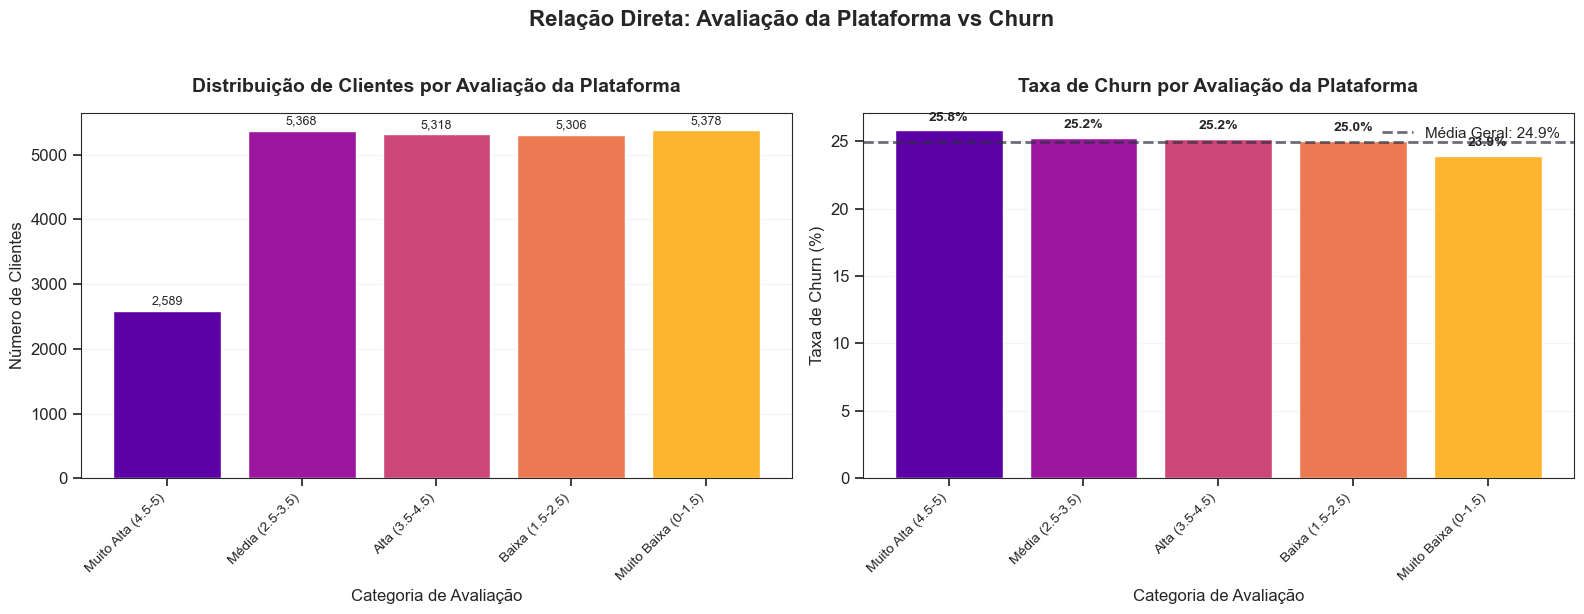


ANÁLISE 2: INTERAÇÃO - AVALIAÇÃO + CONTATOS AO SUPORTE

📊 SEGMENTOS COMBINADOS (Avaliação + Suporte):

   • Alta Avaliação
Alto Suporte:
      Clientes: 4,359 (14.5%)
      Taxa de churn: 33.3%
      Avaliação média: 3.99
      Contatos suporte médios: 2.5

   • Baixa Avaliação
Alto Suporte:
      Clientes: 5,715 (19.1%)
      Taxa de churn: 32.4%
      Avaliação média: 1.74
      Contatos suporte médios: 2.5

   • Alta Avaliação
Baixo Suporte:
      Clientes: 8,916 (29.7%)
      Taxa de churn: 21.4%
      Avaliação média: 3.99
      Contatos suporte médios: 0.5

   • Baixa Avaliação
Baixo Suporte:
      Clientes: 11,010 (36.7%)
      Taxa de churn: 20.5%
      Avaliação média: 1.75
      Contatos suporte médios: 0.5

VISUALIZAÇÃO: HEATMAP DE INTERAÇÃO


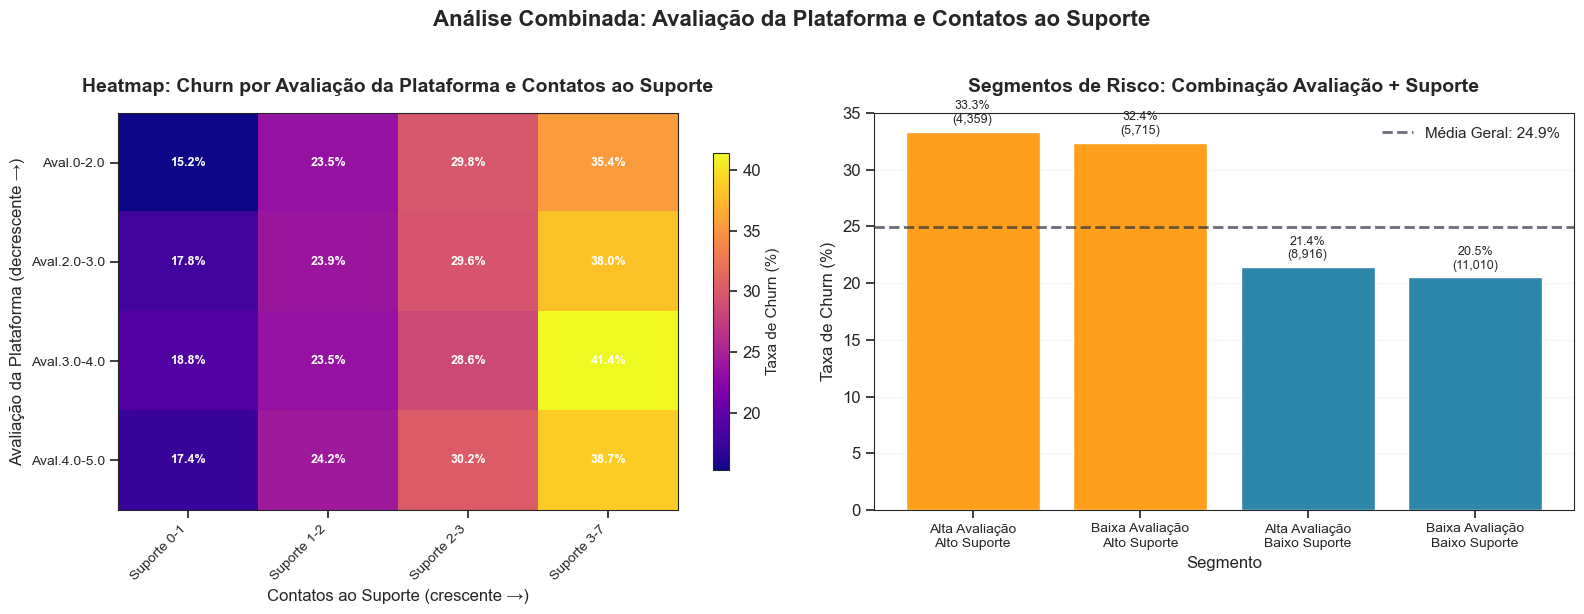


RECOMENDAÇÕES ESTRATÉGICAS BASEADAS NA ANÁLISE

🎯 PRIORIDADE MÁXIMA: Alta Avaliação
Alto Suporte
   • Taxa de churn: 33.3% (+8.4pts vs média)
   • Clientes em risco: 4,359

📝 AÇÕES RECOMENDADAS POR PERFIL:

• Baixa Avaliação
Baixo Suporte:
   1. Pesquisa de satisfação: Entender por que não buscam suporte
   2. Melhoria proativa da UX/UI: Eles podem estar frustrados silenciosamente
   3. Conteúdo educacional: Tutorial sobre funcionalidades pouco conhecidas
   4. Campanha de re-engajamento: Conteúdo personalizado baseado no histórico

• Baixa Avaliação
Alto Suporte:
   1. Análise de causa-raiz: Revisar todos os tickets deste grupo para padrões
   2. Contato proativo: Oferecer solução personalizada antes do cancelamento
   3. Possível problema técnico: Verificar compatibilidade de dispositivo/plataforma
   4. Programa de fidelização agressivo: Desconto ou benefício exclusivo

• Alta Avaliação
Baixo Suporte:
   1. Programa de indicação: Incentivar a trazer novos clientes
   2. Pesquisa NP

In [36]:
# ============================================================================
# 2 ANÁLISE: AVALIAÇÃO DA PLATAFORMA vs CHURN + INTERAÇÃO COM SUPORTE
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. PRÉ-PROCESSAMENTO DA AVALIAÇÃO DA PLATAFORMA
print("=" * 70)
print("PRÉ-PROCESSAMENTO: AVALIAÇÃO DA PLATAFORMA")
print("=" * 70)

# Criar cópia para análise
df_platform = df.copy()

# Converter a coluna de string (com vírgula) para numérico
df_platform['avaliacao_plataforma_num'] = pd.to_numeric(
    df_platform['avaliacao_plataforma'].str.replace(',', '.'), 
    errors='coerce'
)

print(f"Total de avaliações de plataforma disponíveis: {df_platform['avaliacao_plataforma_num'].notna().sum():,}")
print(f"Média de avaliação: {df_platform['avaliacao_plataforma_num'].mean():.2f}")
print(f"Avaliação mais comum (moda): {df_platform['avaliacao_plataforma_num'].mode().values[0]:.1f}")

# 2. ANÁLISE 1: RELAÇÃO DIRETA ENTRE AVALIAÇÃO E CHURN
print("\n" + "=" * 70)
print("ANÁLISE 1: RELAÇÃO DIRETA - AVALIAÇÃO vs CHURN")
print("=" * 70)

# Criar categorias de avaliação
df_platform['categoria_avaliacao'] = pd.cut(
    df_platform['avaliacao_plataforma_num'],
    bins=[0, 1.5, 2.5, 3.5, 4.5, 5],
    labels=['Muito Baixa (0-1.5)', 'Baixa (1.5-2.5)', 'Média (2.5-3.5)', 'Alta (3.5-4.5)', 'Muito Alta (4.5-5)'],
    include_lowest=True
)

# Calcular churn por categoria
churn_por_avaliacao = df_platform.groupby('categoria_avaliacao', observed=False).agg({
    'churn': ['count', 'mean']
})
churn_por_avaliacao.columns = ['clientes', 'taxa_churn']
churn_por_avaliacao['taxa_churn'] = churn_por_avaliacao['taxa_churn'] * 100
churn_por_avaliacao = churn_por_avaliacao.sort_values('taxa_churn', ascending=False)

print("\n📊 TAXA DE CHURN POR CATEGORIA DE AVALIAÇÃO:")
for categoria, dados in churn_por_avaliacao.iterrows():
    print(f"   • {categoria:<20} → {dados['taxa_churn']:5.1f}% churn | {int(dados['clientes']):>5,} clientes")

# 3. VISUALIZAÇÃO DA ANÁLISE 1
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Distribuição das avaliações
categorias_ordem = churn_por_avaliacao.index.tolist()
clientes_vals = churn_por_avaliacao['clientes'].values

# Definir cores baseado no risco (usando gradiente)
cores_risco = sns.color_palette(GRADIENTES_ACESSIVEIS['risco'], len(categorias_ordem))

bars1 = ax1.bar(categorias_ordem, clientes_vals, color=cores_risco)

ax1.set_title('Distribuição de Clientes por Avaliação da Plataforma', 
              fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('Categoria de Avaliação', fontsize=12)
ax1.set_ylabel('Número de Clientes', fontsize=12)
ax1.set_xticklabels(categorias_ordem, rotation=45, ha='right', fontsize=10)
ax1.grid(True, alpha=0.2, axis='y')

# Adicionar valores
for bar, count in zip(bars1, clientes_vals):
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + max(clientes_vals)*0.01,
             f'{int(count):,}', ha='center', va='bottom', fontsize=9)

# Gráfico 2: Taxa de churn por avaliação
taxa_churn_vals = churn_por_avaliacao['taxa_churn'].values

bars2 = ax2.bar(categorias_ordem, taxa_churn_vals, color=cores_risco)

ax2.set_title('Taxa de Churn por Avaliação da Plataforma', 
              fontsize=14, fontweight='bold', pad=15)
ax2.set_xlabel('Categoria de Avaliação', fontsize=12)
ax2.set_ylabel('Taxa de Churn (%)', fontsize=12)
ax2.set_xticklabels(categorias_ordem, rotation=45, ha='right', fontsize=10)
ax2.grid(True, alpha=0.2, axis='y')

# Linha da média geral
media_geral = df_platform['churn'].mean() * 100
ax2.axhline(y=media_geral, color=PALETA_CHURN['neutro_escuro'], 
            linestyle='--', linewidth=2, alpha=0.7,
            label=f'Média Geral: {media_geral:.1f}%')
ax2.legend(loc='upper right', fontsize=11)

# Adicionar valores
for bar, taxa in zip(bars2, taxa_churn_vals):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
             f'{taxa:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.suptitle('Relação Direta: Avaliação da Plataforma vs Churn', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
fig.savefig('Grafico Relação Direta Avaliação da Plataforma vs Churn', dpi=300)
plt.show()

# 4. ANÁLISE 2: COMBINAR AVALIAÇÃO COM CONTATOS AO SUPORTE
print("\n" + "=" * 70)
print("ANÁLISE 2: INTERAÇÃO - AVALIAÇÃO + CONTATOS AO SUPORTE")
print("=" * 70)

# Criar categorias para contatos ao suporte
df_platform['categoria_suporte'] = pd.cut(
    df_platform['contatos_suporte'],
    bins=[-1, 0, 1, 2, 3, df_platform['contatos_suporte'].max()],
    labels=['0 contatos', '1 contato', '2 contatos', '3 contatos', '4+ contatos'],
    include_lowest=True
)

# Criar segmento combinado (simplificado para visualização)
# Vamos usar avaliação baixa vs alta, e suporte baixo vs alto
df_platform['avaliacao_alta'] = df_platform['avaliacao_plataforma_num'] >= 3.0
df_platform['suporte_alto'] = df_platform['contatos_suporte'] >= 2

# Criar 4 segmentos principais
segmentos = []
condicoes = [
    (~df_platform['avaliacao_alta'] & ~df_platform['suporte_alto']),  # Baixa avaliação, baixo suporte
    (~df_platform['avaliacao_alta'] & df_platform['suporte_alto']),   # Baixa avaliação, alto suporte
    (df_platform['avaliacao_alta'] & ~df_platform['suporte_alto']),   # Alta avaliação, baixo suporte
    (df_platform['avaliacao_alta'] & df_platform['suporte_alto'])     # Alta avaliação, alto suporte
]
nomes_segmentos = [
    'Baixa Avaliação\nBaixo Suporte',
    'Baixa Avaliação\nAlto Suporte', 
    'Alta Avaliação\nBaixo Suporte',
    'Alta Avaliação\nAlto Suporte'
]

# Calcular estatísticas para cada segmento
resultados_segmentos = []
for cond, nome in zip(condicoes, nomes_segmentos):
    segmento = df_platform[cond]
    if len(segmento) > 0:
        taxa_churn = segmento['churn'].mean() * 100
        resultados_segmentos.append({
            'segmento': nome,
            'clientes': len(segmento),
            'taxa_churn': taxa_churn,
            'avaliacao_media': segmento['avaliacao_plataforma_num'].mean(),
            'suporte_medio': segmento['contatos_suporte'].mean()
        })

# Criar DataFrame com resultados
df_resultados = pd.DataFrame(resultados_segmentos)
df_resultados = df_resultados.sort_values('taxa_churn', ascending=False)

print("\n📊 SEGMENTOS COMBINADOS (Avaliação + Suporte):")
for _, row in df_resultados.iterrows():
    print(f"\n   • {row['segmento']}:")
    print(f"      Clientes: {row['clientes']:,} ({row['clientes']/len(df_platform)*100:.1f}%)")
    print(f"      Taxa de churn: {row['taxa_churn']:.1f}%")
    print(f"      Avaliação média: {row['avaliacao_media']:.2f}")
    print(f"      Contatos suporte médios: {row['suporte_medio']:.1f}")

# 5. VISUALIZAÇÃO DA ANÁLISE 2 (HEATMAP INTERATIVO)
print("\n" + "=" * 70)
print("VISUALIZAÇÃO: HEATMAP DE INTERAÇÃO")
print("=" * 70)

# Criar heatmap mais detalhado
# Preparar matriz para heatmap
avaliacao_bins = [0, 2.0, 3.0, 4.0, 5.0]
suporte_bins = [0, 1, 2, 3, 7]  # Baseado no máximo observado

# Criar matriz vazia
heatmap_data = pd.DataFrame(
    index=[f'Aval.{avaliacao_bins[i]}-{avaliacao_bins[i+1]}' for i in range(len(avaliacao_bins)-1)],
    columns=[f'Suporte {suporte_bins[i]}-{suporte_bins[i+1]}' for i in range(len(suporte_bins)-1)]
)

# Preencher matriz com taxas de churn
for i in range(len(avaliacao_bins)-1):
    for j in range(len(suporte_bins)-1):
        mask = (
            (df_platform['avaliacao_plataforma_num'] >= avaliacao_bins[i]) & 
            (df_platform['avaliacao_plataforma_num'] < avaliacao_bins[i+1]) &
            (df_platform['contatos_suporte'] >= suporte_bins[j]) & 
            (df_platform['contatos_suporte'] < suporte_bins[j+1])
        )
        segmento = df_platform[mask]
        if len(segmento) > 10:  # Apenas se tiver amostra significativa
            heatmap_data.iloc[i, j] = segmento['churn'].mean() * 100
        else:
            heatmap_data.iloc[i, j] = np.nan

# Converter para numérico
heatmap_data = heatmap_data.astype(float)

# Criar visualização do heatmap
fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap
im = ax3.imshow(heatmap_data.values, cmap=GRADIENTES_ACESSIVEIS['risco'], aspect='auto')
ax3.set_title('Heatmap: Churn por Avaliação da Plataforma e Contatos ao Suporte', 
              fontsize=14, fontweight='bold', pad=15)
ax3.set_xlabel('Contatos ao Suporte (crescente →)', fontsize=12)
ax3.set_ylabel('Avaliação da Plataforma (decrescente →)', fontsize=12)
ax3.set_xticks(range(len(heatmap_data.columns)))
ax3.set_xticklabels(heatmap_data.columns, rotation=45, ha='right', fontsize=10)
ax3.set_yticks(range(len(heatmap_data.index)))
ax3.set_yticklabels(heatmap_data.index, fontsize=10)

# Adicionar valores no heatmap
for i in range(len(heatmap_data.index)):
    for j in range(len(heatmap_data.columns)):
        if not np.isnan(heatmap_data.iloc[i, j]):
            ax3.text(j, i, f'{heatmap_data.iloc[i, j]:.1f}%', 
                    ha='center', va='center', color='white', fontsize=9, fontweight='bold')

# Barra de cores
cbar = plt.colorbar(im, ax=ax3, shrink=0.8)
cbar.set_label('Taxa de Churn (%)', fontsize=11)

# Gráfico de barras dos 4 segmentos principais
segmentos_nomes = df_resultados['segmento'].tolist()
segmentos_churn = df_resultados['taxa_churn'].tolist()
segmentos_size = df_resultados['clientes'].tolist()

# Cores baseadas no risco
cores_segmentos = []
for churn in segmentos_churn:
    if churn > media_geral + 10:
        cores_segmentos.append(PALETA_CHURN['risco_alto'])
    elif churn > media_geral + 5:
        cores_segmentos.append(PALETA_CHURN['risco_medio'])
    elif churn > media_geral:
        cores_segmentos.append(PALETA_CHURN['churn'])
    else:
        cores_segmentos.append(PALETA_CHURN['ativo'])

x_pos = range(len(segmentos_nomes))
ax4.bar(x_pos, segmentos_churn, color=cores_segmentos)

ax4.set_title('Segmentos de Risco: Combinação Avaliação + Suporte', 
              fontsize=14, fontweight='bold', pad=15)
ax4.set_xlabel('Segmento', fontsize=12)
ax4.set_ylabel('Taxa de Churn (%)', fontsize=12)
ax4.set_xticks(x_pos)
ax4.set_xticklabels(segmentos_nomes, fontsize=10)
ax4.grid(True, alpha=0.2, axis='y')

# Linha da média geral
ax4.axhline(y=media_geral, color=PALETA_CHURN['neutro_escuro'], 
            linestyle='--', linewidth=2, alpha=0.7,
            label=f'Média Geral: {media_geral:.1f}%')
ax4.legend(loc='upper right', fontsize=11)

# Adicionar valores
for i, (churn, size) in enumerate(zip(segmentos_churn, segmentos_size)):
    ax4.text(i, churn + 0.5, f'{churn:.1f}%\n({size:,})', 
             ha='center', va='bottom', fontsize=9)

plt.suptitle('Análise Combinada: Avaliação da Plataforma e Contatos ao Suporte', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
fig2.savefig('Grafico Análise Combinada Avaliação da Plataforma e Contatos ao Suporte', dpi=300)
plt.show()

# 6. RECOMENDAÇÕES ESTRATÉGICAS
print("\n" + "=" * 70)
print("RECOMENDAÇÕES ESTRATÉGICAS BASEADAS NA ANÁLISE")
print("=" * 70)

# Identificar segmento de maior risco
segmento_maior_risco = df_resultados.iloc[0]
print(f"\n🎯 PRIORIDADE MÁXIMA: {segmento_maior_risco['segmento']}")
print(f"   • Taxa de churn: {segmento_maior_risco['taxa_churn']:.1f}% (+{segmento_maior_risco['taxa_churn'] - media_geral:.1f}pts vs média)")
print(f"   • Clientes em risco: {segmento_maior_risco['clientes']:,}")

print(f"\n📝 AÇÕES RECOMENDADAS POR PERFIL:")

# Ações específicas baseadas nos perfis da tabela
acoes_por_perfil = {
    'Baixa Avaliação\nAlto Suporte': [
        "Análise de causa-raiz: Revisar todos os tickets deste grupo para padrões",
        "Contato proativo: Oferecer solução personalizada antes do cancelamento",
        "Possível problema técnico: Verificar compatibilidade de dispositivo/plataforma",
        "Programa de fidelização agressivo: Desconto ou benefício exclusivo"
    ],
    'Baixa Avaliação\nBaixo Suporte': [
        "Pesquisa de satisfação: Entender por que não buscam suporte",
        "Melhoria proativa da UX/UI: Eles podem estar frustrados silenciosamente",
        "Conteúdo educacional: Tutorial sobre funcionalidades pouco conhecidas",
        "Campanha de re-engajamento: Conteúdo personalizado baseado no histórico"
    ],
    'Alta Avaliação\nAlto Suporte': [
        "Otimização de suporte: Tornar solução mais eficiente (ex: FAQ melhorada)",
        "Programa de beta testers: Engajá-los com novas funcionalidades",
        "Upsell estratégico: Oferecer plano superior que resolva necessidades frequentes"
    ],
    'Alta Avaliação\nBaixo Suporte': [
        "Programa de indicação: Incentivar a trazer novos clientes",
        "Pesquisa NPS: Coletar feedback para melhorias contínuas",
        "Conteúdo exclusivo: Recompensar fidelidade"
    ]
}

for segmento_nome in nomes_segmentos:
    if segmento_nome in acoes_por_perfil:
        print(f"\n• {segmento_nome}:")
        for i, acao in enumerate(acoes_por_perfil[segmento_nome], 1):
            print(f"   {i}. {acao}")

print("\n" + "=" * 70)
print("PRÓXIMOS PASSOS SUGERIDOS")
print("=" * 70)

print(f"\n1. IMPLEMENTAÇÃO IMEDIATA:")
print(f"   • Criar alerta automático para clientes do segmento '{segmento_maior_risco['segmento']}'")
print(f"   • Treinar equipe de suporte para abordagem específica por segmento")

print(f"\n2. ANÁLISE COMPLEMENTAR (Próxima Iteração):")
print(f"   • Cruzar com 'dispositivo_principal': Problemas são específicos de TV/Mobile?")
print(f"   • Cruzar com 'tempo_assinatura_meses': Clientes novos vs antigos reagem diferente?")
print(f"   • Análise de texto em tickets (se disponível): Tópicos mais comuns por segmento")

print(f"\n3. MONITORAMENTO:")
print(f"   • Acompanhar taxa de churn por segmento mensalmente")
print(f"   • Medir eficácia das ações de retenção implementadas")

print("=" * 70)

##

###### ==================================================
### `ANÁLISE DE PAGAMENTOS E TRANSAÇÕES`
###### ==================================================

Métodos de pagamento encontrados:
['Pix' 'Crédito Recorrente' 'Cartão de Crédito' 'Débito'
 'Débito Automático' 'Boleto']


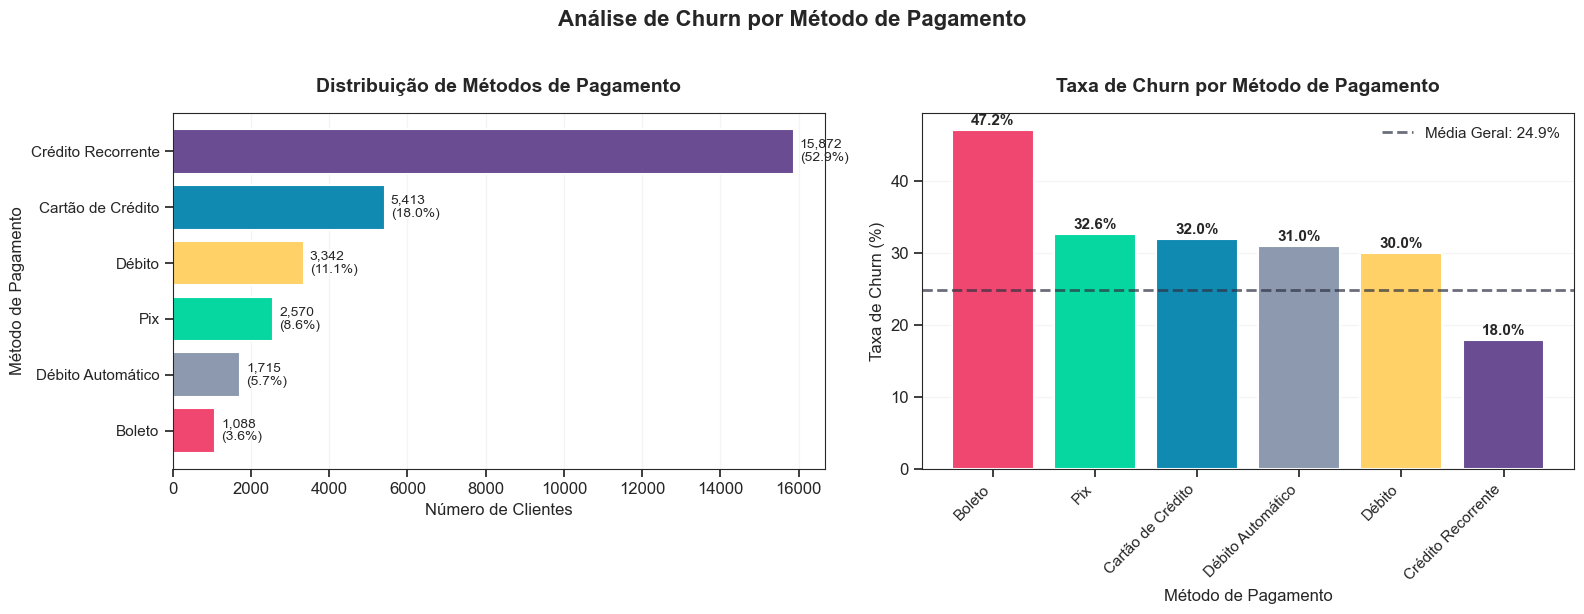

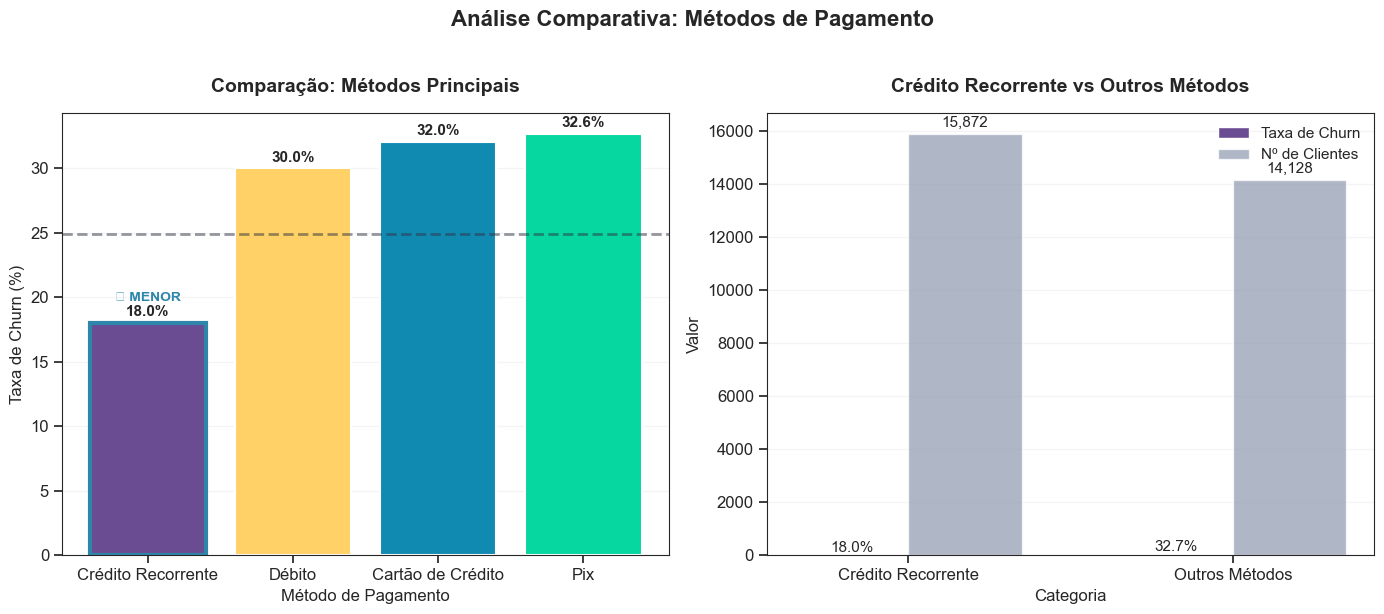

ANÁLISE ESTATÍSTICA: MÉTODO DE PAGAMENTO vs CHURN

📊 VISÃO GERAL:
• Total de métodos: 6
• Método mais popular: Crédito Recorrente (15,872 clientes)
• Média geral de churn: 24.9%

RANKING POR TAXA DE CHURN (do maior para menor):
 1. Boleto               →  47.2% (+22.2pts) |  1,088 clientes | 🔴 ALTO
 2. Pix                  →  32.6% (+7.7pts) |  2,570 clientes | 🔴 ALTO
 3. Cartão de Crédito    →  32.0% (+7.1pts) |  5,413 clientes | 🔴 ALTO
 4. Débito Automático    →  31.0% (+6.1pts) |  1,715 clientes | 🔴 ALTO
 5. Débito               →  30.0% (+5.1pts) |  3,342 clientes | 🔴 ALTO
 6. Crédito Recorrente   →  18.0% (-6.9pts) | 15,872 clientes | 🟢 MUITO BAIXO

RESPOSTAS ÀS SUAS PERGUNTAS:

1. Entre Pix, Cartão e Débito, o método com MENOR churn é:
   → Débito (30.0% de churn)

   Detalhamento:
   3º - Pix: 32.6%
   2º - Cartão de Crédito: 32.0%
   1º - Débito: 30.0%

2. Crédito Recorrente vs Outros Métodos:
   • Crédito Recorrente: 18.0% de churn
   • Outros métodos: 32.7% de churn
   → Créd

In [37]:
# -------------------------------------------
# 1 ANÁLISE DE MÉTODO DE PAGAMENTO vs CHURN
# -------------------------------------------

# 1. PREPARAR OS DADOS
# Verificar métodos de pagamento únicos
print("Métodos de pagamento encontrados:")
print(df['metodo_pagamento'].unique())

# Criar paleta específica para métodos de pagamento
paleta_pagamento = {
    'Pix': '#06D6A0',           # Verde - rápido
    'Cartão de Crédito': '#118AB2',  # Azul - tradicional
    'Débito': '#FFD166',        # Amarelo - intermediário
    'Crédito Recorrente': '#6A4C93', # Roxo - automatizado
    'Boleto': '#EF476F',        # Vermelho - manual
    'Transferência': '#8D99AE'  # Cinza - outros
}

# 2. VISUALIZAÇÃO PRINCIPAL: COMPARAÇÃO COMPLETA
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- GRÁFICO 1: Distribuição dos métodos ---
distribuicao_pag = df['metodo_pagamento'].value_counts()

# Criar barras horizontais para melhor legibilidade
bars_dist = ax1.barh(range(len(distribuicao_pag)), distribuicao_pag.values)

# Aplicar cores
for i, (bar, metodo) in enumerate(zip(bars_dist, distribuicao_pag.index)):
    cor = paleta_pagamento.get(metodo, PALETA_CHURN['neutro_medio'])
    bar.set_color(cor)
    bar.set_edgecolor('white')
    bar.set_linewidth(1.5)

ax1.set_title('Distribuição de Métodos de Pagamento', fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('Número de Clientes', fontsize=12)
ax1.set_ylabel('Método de Pagamento', fontsize=12)
ax1.set_yticks(range(len(distribuicao_pag)))
ax1.set_yticklabels(distribuicao_pag.index, fontsize=11)
ax1.invert_yaxis()  # Maior no topo
ax1.grid(True, alpha=0.2, axis='x')

# Adicionar valores e porcentagens
for bar, count in zip(bars_dist, distribuicao_pag.values):
    porcentagem = (count / len(df)) * 100
    ax1.text(bar.get_width() + max(distribuicao_pag.values)*0.01, 
             bar.get_y() + bar.get_height()/2,
             f'{count:,}\n({porcentagem:.1f}%)', 
             va='center', fontsize=10)

# --- GRÁFICO 2: Taxa de churn por método ---
churn_pagamento = df.groupby('metodo_pagamento')['churn'].agg(['count', 'mean'])
churn_pagamento['taxa_churn'] = churn_pagamento['mean'] * 100
churn_pagamento = churn_pagamento.sort_values('taxa_churn', ascending=False)

bars_churn = ax2.bar(churn_pagamento.index, churn_pagamento['taxa_churn'])

# Aplicar cores
for bar, metodo in zip(bars_churn, churn_pagamento.index):
    cor = paleta_pagamento.get(metodo, PALETA_CHURN['neutro_medio'])
    bar.set_color(cor)
    bar.set_edgecolor('white')
    bar.set_linewidth(1.5)

ax2.set_title('Taxa de Churn por Método de Pagamento', fontsize=14, fontweight='bold', pad=15)
ax2.set_xlabel('Método de Pagamento', fontsize=12)
ax2.set_ylabel('Taxa de Churn (%)', fontsize=12)
ax2.set_xticklabels(churn_pagamento.index, rotation=45, ha='right', fontsize=11)
ax2.grid(True, alpha=0.2, axis='y')

# Linha da média geral
media_geral = df['churn'].mean() * 100
ax2.axhline(y=media_geral, color=PALETA_CHURN['neutro_escuro'], 
            linestyle='--', linewidth=2, alpha=0.7,
            label=f'Média Geral: {media_geral:.1f}%')
ax2.legend(loc='upper right', fontsize=11)

# Adicionar valores
for bar, taxa in zip(bars_churn, churn_pagamento['taxa_churn']):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.3,
             f'{taxa:.1f}%', ha='center', va='bottom', 
             fontsize=11, fontweight='bold')

plt.suptitle('Análise de Churn por Método de Pagamento', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
fig.savefig('Grafico Análise de Churn por Método de Pagamento', dpi=300)
plt.show()

# ============================================================================
# ANÁLISE ESPECÍFICA: PIX, CARTÃO, DÉBITO vs CRÉDITO RECORRENTE
# ============================================================================

# 3. COMPARAÇÃO DIRETA: Métodos tradicionais vs crédito recorrente
fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(14, 6))

# --- GRÁFICO 3: Foco nos métodos principais ---
metodos_foco = ['Pix', 'Cartão de Crédito', 'Débito', 'Crédito Recorrente']
churn_foco = churn_pagamento.loc[metodos_foco]

# Ordenar do menor para maior churn
churn_foco = churn_foco.sort_values('taxa_churn')

bars_foco = ax3.bar(churn_foco.index, churn_foco['taxa_churn'],
                    color=[paleta_pagamento[m] for m in churn_foco.index],
                    edgecolor='white', linewidth=1.5)

ax3.set_title('Comparação: Métodos Principais', fontsize=14, fontweight='bold', pad=15)
ax3.set_xlabel('Método de Pagamento', fontsize=12)
ax3.set_ylabel('Taxa de Churn (%)', fontsize=12)
ax3.grid(True, alpha=0.2, axis='y')

# Destacar o menor churn
menor_churn_idx = churn_foco['taxa_churn'].idxmin()
for bar, metodo in zip(bars_foco, churn_foco.index):
    if metodo == menor_churn_idx:
        bar.set_edgecolor('#2E86AB')
        bar.set_linewidth(3)
        # Adicionar estrela de destaque
        ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1.5,
                 '⭐ MENOR', ha='center', va='bottom', 
                 fontsize=10, fontweight='bold', color='#2E86AB')

# Adicionar valores
for bar, taxa in zip(bars_foco, churn_foco['taxa_churn']):
    ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.3,
             f'{taxa:.1f}%', ha='center', va='bottom', 
             fontsize=11, fontweight='bold')

# Linha da média
ax3.axhline(y=media_geral, color=PALETA_CHURN['neutro_escuro'], 
            linestyle='--', linewidth=2, alpha=0.5)

# --- GRÁFICO 4: Crédito Recorrente vs Outros ---
# Calcular médias para comparação
churn_credito_rec = df[df['metodo_pagamento'] == 'Crédito Recorrente']['churn'].mean() * 100
churn_outros = df[df['metodo_pagamento'] != 'Crédito Recorrente']['churn'].mean() * 100

# Contagem de clientes
count_credito_rec = len(df[df['metodo_pagamento'] == 'Crédito Recorrente'])
count_outros = len(df) - count_credito_rec

categorias = ['Crédito Recorrente', 'Outros Métodos']
valores_churn = [churn_credito_rec, churn_outros]
valores_count = [count_credito_rec, count_outros]

# Criar barras lado a lado
x = np.arange(len(categorias))
largura = 0.35

bars_churn_comp = ax4.bar(x - largura/2, valores_churn, largura,
                          label='Taxa de Churn', color=paleta_pagamento['Crédito Recorrente'])
bars_count_comp = ax4.bar(x + largura/2, valores_count, largura,
                          label='Nº de Clientes', color=PALETA_CHURN['neutro_medio'], alpha=0.7)

ax4.set_title('Crédito Recorrente vs Outros Métodos', fontsize=14, fontweight='bold', pad=15)
ax4.set_xlabel('Categoria', fontsize=12)
ax4.set_ylabel('Valor', fontsize=12)
ax4.set_xticks(x)
ax4.set_xticklabels(categorias, fontsize=12)
ax4.legend(loc='upper right', fontsize=11)
ax4.grid(True, alpha=0.2, axis='y')

# Adicionar valores
for bars, valores in zip([bars_churn_comp, bars_count_comp], [valores_churn, valores_count]):
    for bar, valor in zip(bars, valores):
        if bars == bars_churn_comp:
            text = f'{valor:.1f}%'
            y_offset = 0.5
        else:
            text = f'{valor:,}'
            y_offset = max(valores_count) * 0.01
        
        ax4.text(bar.get_x() + bar.get_width()/2., bar.get_height() + y_offset,
                 text, ha='center', va='bottom', fontsize=11)

plt.suptitle('Análise Comparativa: Métodos de Pagamento', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
fig2.savefig('Grafico Análise Comparativa Métodos de Pagamento', dpi=300)
plt.show()

# ============================================================================
# ANÁLISE ESTATÍSTICA DETALHADA
# ============================================================================
print("=" * 70)
print("ANÁLISE ESTATÍSTICA: MÉTODO DE PAGAMENTO vs CHURN")
print("=" * 70)

print(f"\n📊 VISÃO GERAL:")
print(f"• Total de métodos: {len(distribuicao_pag)}")
print(f"• Método mais popular: {distribuicao_pag.index[0]} ({distribuicao_pag.iloc[0]:,} clientes)")
print(f"• Média geral de churn: {media_geral:.1f}%")

print("\n" + "=" * 70)
print("RANKING POR TAXA DE CHURN (do maior para menor):")
print("=" * 70)

for i, (metodo, dados) in enumerate(churn_pagamento.iterrows(), 1):
    taxa = dados['taxa_churn']
    total = int(dados['count'])
    diferenca = taxa - media_geral
    sinal = "+" if diferenca > 0 else ""
    
    # Classificar risco
    if diferenca > 5:
        risco = "🔴 ALTO"
    elif diferenca > 2:
        risco = "🟡 MÉDIO"
    elif diferenca > -2:
        risco = "🟢 BAIXO"
    else:
        risco = "🟢 MUITO BAIXO"
    
    print(f"{i:2}. {metodo:<20} → {taxa:5.1f}% ({sinal}{diferenca:.1f}pts) | {total:>6,} clientes | {risco}")

print("\n" + "=" * 70)
print("RESPOSTAS ÀS SUAS PERGUNTAS:")
print("=" * 70)

# 1. Pix, Cartão, Débito - qual tem menor churn?
metodos_tradicionais = ['Pix', 'Cartão de Crédito', 'Débito']
churn_tradicionais = churn_pagamento.loc[metodos_tradicionais]

menor_tradicional = churn_tradicionais['taxa_churn'].idxmin()
menor_taxa = churn_tradicionais['taxa_churn'].min()

print(f"\n1. Entre Pix, Cartão e Débito, o método com MENOR churn é:")
print(f"   → {menor_tradicional} ({menor_taxa:.1f}% de churn)")

# Comparação entre eles
print(f"\n   Detalhamento:")
for metodo in metodos_tradicionais:
    taxa = churn_pagamento.loc[metodo, 'taxa_churn']
    posicao = list(churn_tradicionais['taxa_churn'].sort_values().index).index(metodo) + 1
    print(f"   {posicao}º - {metodo}: {taxa:.1f}%")

# 2. Crédito recorrente vs outros
print(f"\n2. Crédito Recorrente vs Outros Métodos:")
print(f"   • Crédito Recorrente: {churn_credito_rec:.1f}% de churn")
print(f"   • Outros métodos: {churn_outros:.1f}% de churn")

diferenca_credito = churn_credito_rec - churn_outros
if diferenca_credito > 0:
    print(f"   → Crédito Recorrente tem {diferenca_credito:.1f}pts MAIS churn")
else:
    print(f"   → Crédito Recorrente tem {abs(diferenca_credito):.1f}pts MENOS churn")

# Análise de proporção
print(f"\n   Proporção de clientes:")
print(f"   • Crédito Recorrente: {count_credito_rec:,} ({count_credito_rec/len(df)*100:.1f}%)")
print(f"   • Outros métodos: {count_outros:,} ({count_outros/len(df)*100:.1f}%)")

print("\n" + "=" * 70)
print("RECOMENDAÇÕES ESTRATÉGICAS:")
print("=" * 70)

print(f"\n• INCENTIVAR: {menor_tradicional} (menor churn entre métodos tradicionais)")
print(f"• INVESTIGAR: {churn_pagamento['taxa_churn'].idxmax()} (maior taxa de churn)")

if churn_credito_rec > churn_outros:
    print("• REVISAR: Processo de Crédito Recorrente (churn acima da média)")
else:
    print("• EXPANDIR: Uso de Crédito Recorrente (churn abaixo da média)")

print("\n• Ações sugeridas:")
print("  1. Criar incentivos para migração para métodos de menor churn")
print("  2. Analisar falhas no processo de pagamento recorrente")
print("  3. Simplificar renovação para métodos problemáticos")
print("  4. Monitorar churn por método mensalmente")

print("=" * 70)

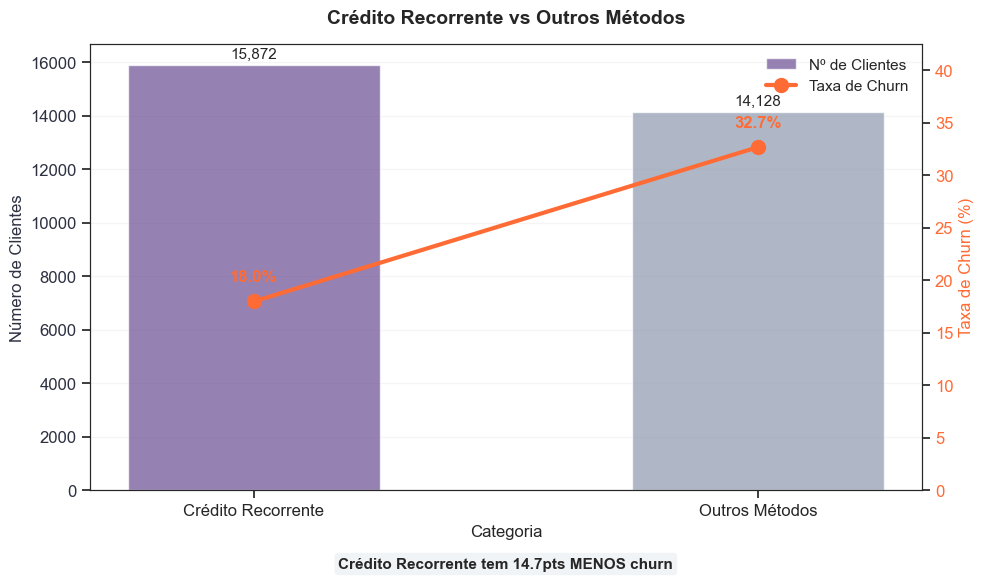

COMPARAÇÃO: CRÉDITO RECORRENTE vs OUTROS

📊 CRÉDITO RECORRENTE:
   • Clientes: 15,872 (52.9%)
   • Taxa de churn: 18.0%

📊 OUTROS MÉTODOS (5 métodos):
   • Clientes: 14,128 (47.1%)
   • Taxa de churn: 32.7%

📈 DIFERENÇA:
   • Crédito Recorrente tem 14.7pts MENOS churn

🔍 SIGNIFICÂNCIA ESTATÍSTICA:
   • Estatística t: -29.489
   • Valor-p: 0.000
   • Diferença estatisticamente SIGNIFICATIVA (p < 0.05)


In [38]:
# -------------------------------------------------------
# 2 Crédito Recorrente vs Outros Métodos (com dual axis)
# -------------------------------------------------------

# 1. CRIAR FIGURA CORRIGIDA
fig, ax1 = plt.subplots(figsize=(10, 6))

# 2. CALCULAR OS DADOS
churn_credito_rec = df[df['metodo_pagamento'] == 'Crédito Recorrente']['churn'].mean() * 100
churn_outros = df[df['metodo_pagamento'] != 'Crédito Recorrente']['churn'].mean() * 100

count_credito_rec = len(df[df['metodo_pagamento'] == 'Crédito Recorrente'])
count_outros = len(df) - count_credito_rec

categorias = ['Crédito Recorrente', 'Outros Métodos']

# 3. CRIAR BARRAS PARA NÚMERO DE CLIENTES (eixo primário)
x = np.arange(len(categorias))
largura = 0.5

# Barras de contagem de clientes
bars_count = ax1.bar(x, [count_credito_rec, count_outros], largura,
                     color=[paleta_pagamento['Crédito Recorrente'], PALETA_CHURN['neutro_medio']],
                     alpha=0.7, label='Nº de Clientes')

ax1.set_xlabel('Categoria', fontsize=12)
ax1.set_ylabel('Número de Clientes', fontsize=12, color=PALETA_CHURN['neutro_escuro'])
ax1.set_xticks(x)
ax1.set_xticklabels(categorias, fontsize=12)
ax1.tick_params(axis='y', labelcolor=PALETA_CHURN['neutro_escuro'])

# Adicionar valores das barras de contagem
for bar, count in zip(bars_count, [count_credito_rec, count_outros]):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + max(count_credito_rec, count_outros)*0.01,
             f'{count:,}', ha='center', va='bottom', fontsize=11)

# 4. CRIAR EIXO SECUNDÁRIO PARA TAXA DE CHURN
ax2 = ax1.twinx()

# Plotar linha para taxa de churn
line_churn = ax2.plot(x, [churn_credito_rec, churn_outros], 'o-', 
                     color=PALETA_CHURN['churn'], linewidth=3, markersize=10,
                     label='Taxa de Churn')

ax2.set_ylabel('Taxa de Churn (%)', fontsize=12, color=PALETA_CHURN['churn'])
ax2.tick_params(axis='y', labelcolor=PALETA_CHURN['churn'])
ax2.set_ylim(0, max(churn_credito_rec, churn_outros) * 1.3)  # Ajustar limites

# Adicionar valores da taxa de churn
for i, (categoria, taxa) in enumerate(zip(categorias, [churn_credito_rec, churn_outros])):
    ax2.text(i, taxa + (max(churn_credito_rec, churn_outros) * 0.05),
             f'{taxa:.1f}%', ha='center', va='bottom', 
             fontsize=12, fontweight='bold', color=PALETA_CHURN['churn'])

# 5. CONFIGURAÇÕES FINAIS
ax1.set_title('Crédito Recorrente vs Outros Métodos', fontsize=14, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.2, axis='y')

# Combinar legendas
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=11)

# Adicionar análise comparativa
diferenca = churn_credito_rec - churn_outros
if diferenca > 0:
    analise_text = f"Crédito Recorrente tem {diferenca:.1f}pts MAIS churn"
else:
    analise_text = f"Crédito Recorrente tem {abs(diferenca):.1f}pts MENOS churn"

ax1.text(0.5, -0.15, analise_text, transform=ax1.transAxes,
         ha='center', va='top', fontsize=11, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor=PALETA_CHURN['neutro_claro'], alpha=0.8))

plt.tight_layout()
fig.savefig('Grafico Crédito Recorrente vs Outros Métodos', dpi = 300)
plt.show()

# 6. RESUMO ESTATÍSTICO
print("=" * 60)
print("COMPARAÇÃO: CRÉDITO RECORRENTE vs OUTROS")
print("=" * 60)

print(f"\n📊 CRÉDITO RECORRENTE:")
print(f"   • Clientes: {count_credito_rec:,} ({count_credito_rec/len(df)*100:.1f}%)")
print(f"   • Taxa de churn: {churn_credito_rec:.1f}%")

print(f"\n📊 OUTROS MÉTODOS ({len(df['metodo_pagamento'].unique())-1} métodos):")
print(f"   • Clientes: {count_outros:,} ({count_outros/len(df)*100:.1f}%)")
print(f"   • Taxa de churn: {churn_outros:.1f}%")

print(f"\n📈 DIFERENÇA:")
print(f"   • {analise_text}")

# Verificar se a diferença é estatisticamente significativa
from scipy import stats

churn_credito = df[df['metodo_pagamento'] == 'Crédito Recorrente']['churn']
churn_outros_data = df[df['metodo_pagamento'] != 'Crédito Recorrente']['churn']

# Teste t para amostras independentes
t_stat, p_value = stats.ttest_ind(churn_credito, churn_outros_data, equal_var=False)

print(f"\n🔍 SIGNIFICÂNCIA ESTATÍSTICA:")
print(f"   • Estatística t: {t_stat:.3f}")
print(f"   • Valor-p: {p_value:.3f}")
if p_value < 0.05:
    print(f"   • Diferença estatisticamente SIGNIFICATIVA (p < 0.05)")
else:
    print(f"   • Diferença NÃO estatisticamente significativa")

print("=" * 60)

In [39]:
df

,cliente_id,idade,genero,regiao,tipo_contrato,metodo_pagamento,plano_assinatura,valor_mensal,tempo_assinatura_meses,dias_ultimo_acesso,...,churn,avaliacao_conteudo_ultimo_mes_missing,avaliacao_conteudo_media_missing,avaliacao_plataforma_missing,genero_missing,faixa_etaria,geracao_simples,categoria_acesso,categoria_engajamento,categoria_contatos
0,CLI_000001,44,Feminino,Sudeste,Mensal,Pix,Padrão,38.0,42,27,...,0,0,0,0,0,36-45,Geração X,Inativo (8-30 dias),Médio Engajamento,2 contatos
1,CLI_000002,36,Feminino,Sudeste,Mensal,Crédito Recorrente,Premium,49.9,20,23,...,0,1,0,0,0,36-45,Millennials,Inativo (8-30 dias),Médio Engajamento,1 contato
2,CLI_000003,46,Feminino,Sudeste,Mensal,Cartão de Crédito,Básico,24.9,6,14,...,0,1,0,1,0,46-55,Geração X,Inativo (8-30 dias),Alto Engajamento,2 contatos
3,CLI_000004,57,Masculino,Nordeste,Mensal,Crédito Recorrente,Básico,24.9,10,70,...,1,1,0,1,0,56-65,Geração X,Churn Iminente (> 60 dias),Baixo Engajamento,Nenhum contato
4,CLI_000005,34,Outros,Nordeste,Mensal,Crédito Recorrente,Premium,49.9,22,31,...,0,1,0,0,0,26-35,Millennials,Risco Médio (31-60 dias),Baixo Engajamento,1 contato
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,CLI_029996,30,Feminino,Nordeste,Anual,Crédito Recorrente,Padrão,32.0,0,1,...,0,0,1,0,0,26-35,Millennials,Ativo (≤ 7 dias),Alto Engajamento,2 contatos
29996,CLI_029997,56,Feminino,Nordeste,Mensal,Crédito Recorrente,Básico,24.9,0,0,...,0,0,1,1,0,56-65,Geração X,Ativo (≤ 7 dias),Médio Engajamento,1 contato
29997,CLI_029998,31,Feminino,Nordeste,Anual,Crédito Recorrente,Premium,38.0,0,1,...,0,0,1,0,0,26-35,Millennials,Ativo (≤ 7 dias),Baixo Engajamento,4+ contatos
29998,CLI_029999,18,Masculino,Sudeste,Anual,Crédito Recorrente,Premium,38.0,9,29,...,0,0,0,0,0,NaN,Geração Z,Inativo (8-30 dias),Médio Engajamento,3 contatos


In [40]:
list(df.columns)

['cliente_id',
 'idade',
 'genero',
 'regiao',
 'tipo_contrato',
 'metodo_pagamento',
 'plano_assinatura',
 'valor_mensal',
 'tempo_assinatura_meses',
 'dias_ultimo_acesso',
 'acessibilidade',
 'contatos_suporte',
 'visualizacoes_mes',
 'tempo_medio_sessao_min',
 'dispositivo_principal',
 'categoria_favorita',
 'avaliacao_conteudo_media',
 'avaliacao_conteudo_ultimo_mes',
 'avaliacao_plataforma',
 'churn',
 'avaliacao_conteudo_ultimo_mes_missing',
 'avaliacao_conteudo_media_missing',
 'avaliacao_plataforma_missing',
 'genero_missing',
 'faixa_etaria',
 'geracao_simples',
 'categoria_acesso',
 'categoria_engajamento',
 'categoria_contatos']

In [46]:
dados_streaming_explorado = df[['cliente_id','idade','faixa_etaria','geracao_simples','genero','regiao','tipo_contrato',
                                'metodo_pagamento','plano_assinatura','valor_mensal','tempo_assinatura_meses',
                                'dias_ultimo_acesso','categoria_acesso','categoria_engajamento','acessibilidade','contatos_suporte',
                                'categoria_contatos','visualizacoes_mes','tempo_medio_sessao_min','dispositivo_principal','categoria_favorita',
                                'avaliacao_conteudo_media','avaliacao_conteudo_ultimo_mes','avaliacao_plataforma','churn']]


In [47]:
display(dados_streaming.head())
print('\n')
display(df.head())
print('\n')
display(dados_streaming_explorado.head())

,cliente_id,idade,genero,regiao,tipo_contrato,metodo_pagamento,plano_assinatura,valor_mensal,tempo_assinatura_meses,dias_ultimo_acesso,acessibilidade,contatos_suporte,visualizacoes_mes,tempo_medio_sessao_min,dispositivo_principal,categoria_favorita,avaliacao_conteudo_media,avaliacao_conteudo_ultimo_mes,avaliacao_plataforma,churn
0,CLI_000001,44,Feminino,Sudeste,Mensal,Pix,Padrão,38.0,42,27,0,2,15,169,Mobile,Séries,"5,0","3,0","2,0",0
1,CLI_000002,36,Feminino,Sudeste,Mensal,Crédito Recorrente,Premium,49.9,20,23,0,1,15,97,Mobile,Filmes,"2,0",NaN,"3,0",0
2,CLI_000003,46,Feminino,Sudeste,Mensal,Cartão de Crédito,Básico,24.9,6,14,0,2,56,118,Desktop,Séries,"1,5",NaN,NaN,0
3,CLI_000004,57,Masculino,Nordeste,Mensal,Crédito Recorrente,Básico,24.9,10,70,0,0,0,31,TV,Séries,"4,0",NaN,NaN,1
4,CLI_000005,34,Outros,Nordeste,Mensal,Crédito Recorrente,Premium,49.9,22,31,0,1,0,46,mobile,Esportes,"4,0",NaN,"1,5",0


,cliente_id,idade,genero,regiao,tipo_contrato,metodo_pagamento,plano_assinatura,valor_mensal,tempo_assinatura_meses,dias_ultimo_acesso,...,churn,avaliacao_conteudo_ultimo_mes_missing,avaliacao_conteudo_media_missing,avaliacao_plataforma_missing,genero_missing,faixa_etaria,geracao_simples,categoria_acesso,categoria_engajamento,categoria_contatos
0,CLI_000001,44,Feminino,Sudeste,Mensal,Pix,Padrão,38.0,42,27,...,0,0,0,0,0,36-45,Geração X,Inativo (8-30 dias),Médio Engajamento,2 contatos
1,CLI_000002,36,Feminino,Sudeste,Mensal,Crédito Recorrente,Premium,49.9,20,23,...,0,1,0,0,0,36-45,Millennials,Inativo (8-30 dias),Médio Engajamento,1 contato
2,CLI_000003,46,Feminino,Sudeste,Mensal,Cartão de Crédito,Básico,24.9,6,14,...,0,1,0,1,0,46-55,Geração X,Inativo (8-30 dias),Alto Engajamento,2 contatos
3,CLI_000004,57,Masculino,Nordeste,Mensal,Crédito Recorrente,Básico,24.9,10,70,...,1,1,0,1,0,56-65,Geração X,Churn Iminente (> 60 dias),Baixo Engajamento,Nenhum contato
4,CLI_000005,34,Outros,Nordeste,Mensal,Crédito Recorrente,Premium,49.9,22,31,...,0,1,0,0,0,26-35,Millennials,Risco Médio (31-60 dias),Baixo Engajamento,1 contato


,cliente_id,idade,faixa_etaria,geracao_simples,genero,regiao,tipo_contrato,metodo_pagamento,plano_assinatura,valor_mensal,...,contatos_suporte,categoria_contatos,visualizacoes_mes,tempo_medio_sessao_min,dispositivo_principal,categoria_favorita,avaliacao_conteudo_media,avaliacao_conteudo_ultimo_mes,avaliacao_plataforma,churn
0,CLI_000001,44,36-45,Geração X,Feminino,Sudeste,Mensal,Pix,Padrão,38.0,...,2,2 contatos,15,169,Mobile,Séries,"5,0","3,0","2,0",0
1,CLI_000002,36,36-45,Millennials,Feminino,Sudeste,Mensal,Crédito Recorrente,Premium,49.9,...,1,1 contato,15,97,Mobile,Filmes,"2,0",Nao_avaliado,"3,0",0
2,CLI_000003,46,46-55,Geração X,Feminino,Sudeste,Mensal,Cartão de Crédito,Básico,24.9,...,2,2 contatos,56,118,Desktop,Séries,"1,5",Nao_avaliado,Nao_avaliado,0
3,CLI_000004,57,56-65,Geração X,Masculino,Nordeste,Mensal,Crédito Recorrente,Básico,24.9,...,0,Nenhum contato,0,31,Tv,Séries,"4,0",Nao_avaliado,Nao_avaliado,1
4,CLI_000005,34,26-35,Millennials,Outros,Nordeste,Mensal,Crédito Recorrente,Premium,49.9,...,1,1 contato,0,46,Mobile,Esportes,"4,0",Nao_avaliado,"1,5",0


In [48]:
dados_streaming_explorado.to_csv('Dados_Streaming_Explorados.csv', index = False)